# **Ensemble Learning for Fire Calorimetry Database**

## By: Bhaskar, Ekanki, Srish and Kuldeep

# Project Overview

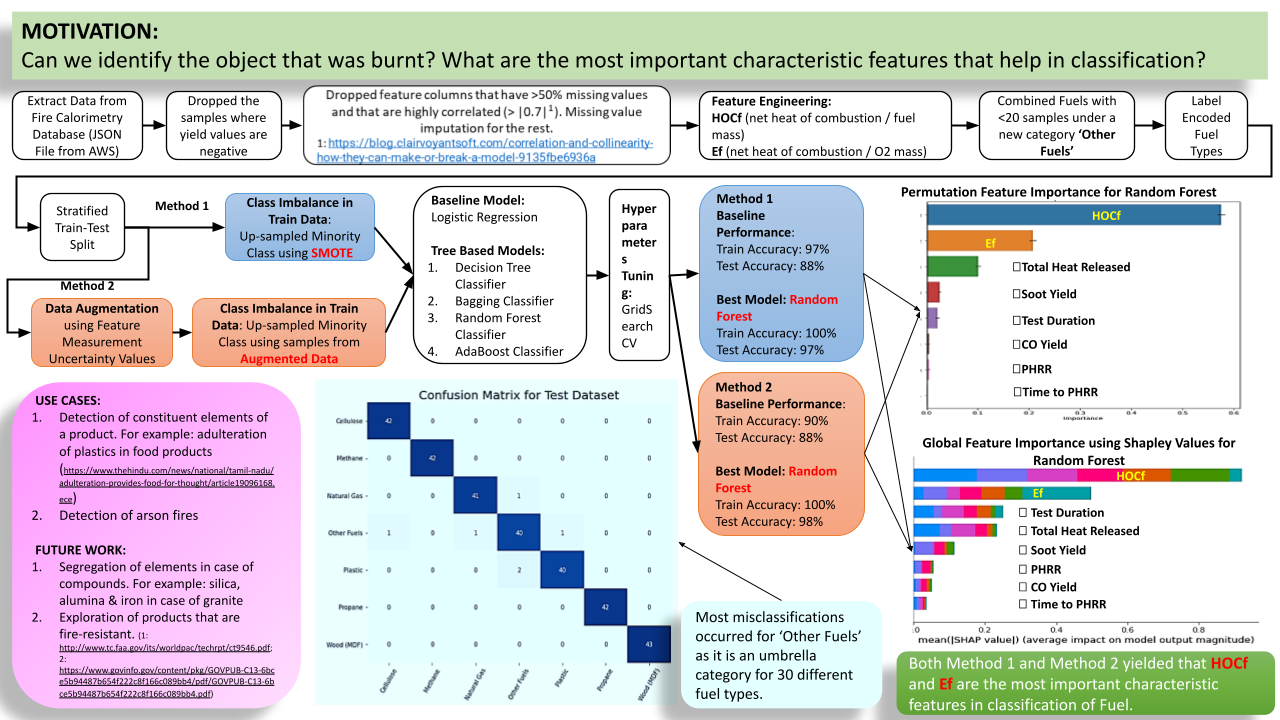

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library to Calculate Feature Importance
!pip install shap

     |████████████████████████████████| 564 kB 25.3 MB/s 


In [3]:
import json
import urllib.request
import pandas as pd
import numpy as np
from prettytable import PrettyTable

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.manifold import TSNE

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix

from sklearn.inspection import permutation_importance
import shap
shap.initjs()

from itertools import product, permutations
from collections import OrderedDict

In [4]:
# Setting random state for the project to ensure reproducibility
rs = 42

# Defining Necessary Paths

In [5]:
# Data Directory Path (Please replace this by your system's data directory path)
ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/DS-2 Project/Kuldeep Proposal/"
DATA_PATH = ROOT_PATH + "data/"
json_url_filename1 = DATA_PATH+"S3_AWS_JSON_LIST.csv"
json_url_filename2 = DATA_PATH+"HTTP_NFRL1_JSON_FileList.csv"

# Creating Our Dataset

In [ ]:
# df1 = pd.read_csv(json_url_filename1)
# # df2 = pd.read_csv(json_url_filename2)
# # df3 = pd.concat([df1, df2], axis=0)

In [ ]:
# json_urls = df1["url_name"].values

In [ ]:
# json_urls[0]

'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528807400.json'

In [ ]:
# with urllib.request.urlopen(json_urls[0]) as url:
#   json_data = json.loads(url.read().decode())
# json_data

{'CO2_plot': {'caption': 'Plot of Carbon Dioxide Dry Volume Fraction in hood exhaust stream.',
  'image': 'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/data/1528807400-CO2.png'},
 'CO_plot': {'caption': 'Plot of Carbon Monoxide Dry Volume Fraction in hood exhaust stream.',
  'image': 'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/data/1528807400-CO.png'},
 'HeatFlux_plot': {'caption': 'Plot of Radiant Heat Flux data with event markers. r= radial distance from center of hood, h=height above floor. ',
  'image': 'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/data/1528807400-HeatFlux.png'},
 'MFRe_plot': {'caption': 'Plot of Exhaust Duct Mass Flow Rate.',
  'image': 'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/Chair_Mockup/data/1528807400-MFRe.png'},
 'O2_plot': {'caption': 'Plot of Oxygen Dry Volume Fraction in hood exhaust stream.',
  'image': 'https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/ASSET_FILES/C

In [ ]:
# json_data.keys()

dict_keys(['id', 'publish', 'created', 'updated', 'name', 'date', 'description', 'specimen', 'ignition', 'project_ids', 'test_director', 'timelapse_video_with_heat_release_rate_plot', 'csv_data_file', 'peak_heat_release_rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned', 'net_effective_heat_of_combustion', 'o2_yield', 'co2_yield', 'co_yield', 'soot_yield', 'baseline_hood_exhaust_flow', 'test_duration', 'hrqc', 'burner_total_heat_released', 'fuel_type', 'hood_size', 'effective_duct_diameter', 'exhaust_flow_correction_factor', 'net_heat_of_combustion_per_mass_o2', 'net_heat_of_combustion_per_mass_fuel', 'initial_fuel_mass', 'final_fuel_mass', 'net_fuel_mass', 'doi', 'hrr_plot', 'O2_plot', 'CO2_plot', 'CO_plot', 'HeatFlux_plot', 'Soot_plot', 'MFRe_plot', 'summary_of_observed_test_events', 'report_process_script_version'])

In [ ]:
# cols = [
#         "id",
#         "url_name",
#         "Peak_Heat_Release_Rate",
#         "time_to_peak_heat_release_rate",
#         "total_heat_released",
#         "total_fuel_mass_burned",
#         "net_fuel_mass",
#         "net_effective_heat_of_combustion",
#         "net_heat_of_combustion_per_mass_fuel",
#         "net_heat_of_combustion_per_mass_o2",
#         "o2_yield",
#         "co2_yield",
#         "co_yield",
#         "soot_yield",
#         "test_duration",
#         "fuel_type"
#        ]
# FCDSummaryValues = pd.DataFrame(columns=cols)

In [ ]:
# # set to True, if you want to read a short dataset for testing (save time).
# # else set it to False

# read_short_dataset = False

In [ ]:
# num_of_datasets =0
# for json_url in json_urls:
#     print(f'Reading json file : {num_of_datasets} : {json_url}')
#     num_of_datasets += 1
#     if ((num_of_datasets > 10) & read_short_dataset): 
#         break
#     with urllib.request.urlopen(json_url) as url:
#         json_data = json.loads(url.read().decode())
#         new_df = pd.DataFrame([[
#                                 json_data["id"],
#                                 json_url, 
#                                 json_data["peak_heat_release_rate"]["value"],
#                                 json_data["time_to_peak_heat_release_rate"]["value"],
#                                 json_data["total_heat_released"]["value"],
#                                 json_data["total_fuel_mass_burned"]["value"],
#                                 json_data["net_effective_heat_of_combustion"]["value"],
#                                 json_data["net_heat_of_combustion_per_mass_fuel"]["value"],
#                                 json_data["net_heat_of_combustion_per_mass_o2"]["value"],
#                                 json_data["o2_yield"]["value"],
#                                 json_data["co2_yield"]["value"],
#                                 json_data["co_yield"]["value"],
#                                 json_data["soot_yield"]["value"],
#                                 json_data["test_duration"]["value"],
#                                 json_data["fuel_type"]["value"]
#                                ]],
#                                 columns=cols, index={str(num_of_datasets-1)})

#         FCDSummaryValues = pd.concat([FCDSummaryValues, new_df])

Reading json file : 0 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528807400.json
Reading json file : 1 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528814873.json
Reading json file : 2 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528823581.json
Reading json file : 3 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528827554.json
Reading json file : 4 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1528896022.json
Reading json file : 5 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1529333117.json
Reading json file : 6 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1529344888.json
Reading json file : 7 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1529500540.json
Reading json file : 8 : https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/JSON_FILES/EXPERIMENTS/1531847148.json
Reading json file : 9 : http

In [ ]:
# FCDSummaryValues.head()

id                                           url_name  \
0  1528807400  https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/J...   
1  1528814873  https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/J...   
2  1528823581  https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/J...   
3  1528827554  https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/J...   
4  1528896022  https://nist-el-nfrlhrr.s3.amazonaws.com/HRR/J...   

   Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                 1080.02                           24.87   
1                 1547.04                           12.32   
2                  656.86                           13.43   
3                 2320.35                           10.52   
4                 1062.64                           19.70   

   total_heat_released  total_fuel_mass_burned  \
0            300.87275               15.043637   
1            326.84322               16.342161   
2            339.09757               16.954879   
3            314.44367               15.722184   
4            313.20324               15.660162   

  net_effective_heat_of_combustion net_heat_of_combustion_per_mass_fuel  \
0                        22.781309                                   20   
1                        24.742106                                   20   
2                        24.487115                                   20   
3                        25.487855                                   20   
4                        23.135119                                   20   

   net_heat_of_combustion_per_mass_o2  o2_yield  co2_yield  co_yield  \
0                                13.1  1.754014   1.936128  0.051122   
1                                13.1  1.853245   2.069798  0.025816   
2                                13.1  1.834621   2.055662  0.028453   
3                                13.1  1.906736   2.135209  0.019594   
4                                13.1  1.738788   1.995297  0.037192   

  soot_yield  test_duration          fuel_type  
0        NaN      41.066667  Polyurethane Foam  
1        NaN      22.950000  Polyurethane Foam  
2        NaN      22.333333  Polyurethane Foam  
3        NaN      20.383333  Polyurethane Foam  
4        NaN      37.683333  Polyurethane Foam

In [ ]:
# FCDSummaryValues.to_csv(ROOT_PATH+'data/FCDSummaryValues.csv', index=False)

# 'fuel_type' Classification Using Non-Augmented Dataset

## Importing Dataset

In [6]:
dataset = pd.read_csv(DATA_PATH+'FCDSummaryValues.csv')

In [7]:
dataset.head()

Unnamed: 0          id                                           url_name  \
0           0  1647008482  http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERI...   
1           1  1646936290  http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERI...   
2           2  1646410394  http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERI...   
3           3  1646317604  http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERI...   
4           4  1646236342  http://nfrl1.el.nist.gov/HRR/JSON_FILES/EXPERI...   

   Peak_Heat_Release_Rate  Peak_Heat_Release_Rate - Uncertainty  \
0                   96.46                              6.237851   
1                  127.17                              7.774227   
2                   44.72                              3.272653   
3                  279.98                             15.619808   
4                  476.98                             25.109751   

   time_to_peak_heat_release_rate  \
0                           21.45   
1                           11.38   
2                           15.55   
3                            9.73   
4                           18.90   

   time_to_peak_heat_release_rate - Uncertainty  total_heat_released  \
0                                      0.166667            173.80297   
1                                      0.166667            126.85369   
2                                      0.166667             36.46506   
3                                      0.166667            199.53617   
4                                      0.166667            260.05008   

   total_heat_released - Uncertainty  total_fuel_mass_burned  ...  co_yield  \
0                          12.235370               10.284199  ...  0.112912   
1                           9.133598                7.506136  ...  0.087455   
2                           3.146284                2.157696  ...  0.026711   
3                          12.053160                4.988404  ...  0.094687   
4                          15.068432                6.501252  ...  0.020452   

   co_yield - Uncertainty  soot_yield  soot_yield - Uncertainty  \
0                0.009549    0.009760                  0.003991   
1                0.007513    0.018994                  0.004511   
2                0.002623    0.011638                  0.001902   
3                0.007239    0.039490                  0.008568   
4                0.001524    0.052682                  0.008195   

   test_duration  test_duration - Uncertainty              fuel_type  \
0      55.816667                     0.033333       PVC, Natural Gas   
1      39.666667                     0.033333       PVC, Natural Gas   
2      26.150000                     0.033333       PVC, Natural Gas   
3      33.750000                     0.033333  Plastics, Natural Gas   
4      34.866667                     0.033333  Plastics, Natural Gas   

   fuel_type - Uncertainty  net_fuel_mass  net_fuel_mass - Uncertainty  
0                       []            NaN                          NaN  
1                       []            NaN                          NaN  
2                       []            NaN                          NaN  
3                       []            NaN                          NaN  
4                       []            NaN                          NaN  

[5 rows x 31 columns]

In [8]:
print(f"\033[1;91m Shape of the dataset: {dataset.shape}")

 Shape of the dataset: (1021, 31)


In [9]:
# Print the columns of the dataset
print(f"\033[1;91m Initial Feature Columns in the Dataset: {dataset.columns}")

 Initial Feature Columns in the Dataset: Index(['Unnamed: 0', 'id', 'url_name', 'Peak_Heat_Release_Rate',
       'Peak_Heat_Release_Rate - Uncertainty',
       'time_to_peak_heat_release_rate',
       'time_to_peak_heat_release_rate - Uncertainty', 'total_heat_released',
       'total_heat_released - Uncertainty', 'total_fuel_mass_burned',
       'total_fuel_mass_burned - Uncertainty',
       'net_effective_heat_of_combustion',
       'net_effective_heat_of_combustion - Uncertainty',
       'net_heat_of_combustion_per_mass_fuel',
       'net_heat_of_combustion_per_mass_fuel - Uncertainty',
       'net_heat_of_combustion_per_mass_o2',
       'net_heat_of_combustion_per_mass_o2 - Uncertainty', 'o2_yield',
       'o2_yield - Uncertainty', 'co2_yield', 'co2_yield - Uncertainty',
       'co_yield', 'co_yield - Uncertainty', 'soot_yield',
       'soot_yield - Uncertainty', 'test_duration',
       'test_duration - Uncertainty', 'fuel_type', 'fuel_type - Uncertainty',
       'net_fuel_mass', '

In [10]:
# We will use the uncertainty values for data augmentation. So, dropping those columns for the analysis and predictions on the non-augmented data.
# Also, dropping the 'Unnamed: 0', 'id' and 'url_name' columns as they are not relevant for modeling.
useful_cols = ['Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned', 'net_fuel_mass', 'net_effective_heat_of_combustion',
               'net_heat_of_combustion_per_mass_fuel', 'net_heat_of_combustion_per_mass_o2', 'o2_yield', 'co2_yield', 'co_yield', 'soot_yield', 'test_duration', 'fuel_type']

df = dataset[useful_cols]
df.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                   96.46                           21.45   
1                  127.17                           11.38   
2                   44.72                           15.55   
3                  279.98                            9.73   
4                  476.98                           18.90   

   total_heat_released  total_fuel_mass_burned  net_fuel_mass  \
0            173.80297               10.284199            NaN   
1            126.85369                7.506136            NaN   
2             36.46506                2.157696            NaN   
3            199.53617                4.988404            NaN   
4            260.05008                6.501252            NaN   

   net_effective_heat_of_combustion  net_heat_of_combustion_per_mass_fuel  \
0                               NaN                                  16.9   
1                               NaN                                  16.9   
2                               NaN                                  16.9   
3                               NaN                                  40.0   
4                               NaN                                  40.0   

   net_heat_of_combustion_per_mass_o2  o2_yield  co2_yield  co_yield  \
0                               12.84  1.215211   1.020752  0.112912   
1                               12.84  1.312967   1.157866  0.087455   
2                               12.84  1.229338   1.100835  0.026711   
3                               13.10  2.901444   2.641933  0.094687   
4                               13.10  2.824405   2.586653  0.020452   

   soot_yield  test_duration              fuel_type  
0    0.009760      55.816667       PVC, Natural Gas  
1    0.018994      39.666667       PVC, Natural Gas  
2    0.011638      26.150000       PVC, Natural Gas  
3    0.039490      33.750000  Plastics, Natural Gas  
4    0.052682      34.866667  Plastics, Natural Gas

<font color='red'>**'fuel_type' is our target variable for classification task.**</font>

In [11]:
print(f"\033[1;91m Shape of the dataset after dropping the non-relevant columns: {df.shape}")

 Shape of the dataset after dropping the non-relevant columns: (1021, 14)


## Exploratory Data Analysis

In [12]:
# Checking Column names and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Peak_Heat_Release_Rate                1021 non-null   float64
 1   time_to_peak_heat_release_rate        1021 non-null   float64
 2   total_heat_released                   1021 non-null   float64
 3   total_fuel_mass_burned                1021 non-null   float64
 4   net_fuel_mass                         206 non-null    float64
 5   net_effective_heat_of_combustion      206 non-null    float64
 6   net_heat_of_combustion_per_mass_fuel  1021 non-null   float64
 7   net_heat_of_combustion_per_mass_o2    1021 non-null   float64
 8   o2_yield                              1021 non-null   float64
 9   co2_yield                             1021 non-null   float64
 10  co_yield                              1021 non-null   float64
 11  soot_yield       

In [13]:
# Checking the statistics of numerical columns
df.describe()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
count             1021.000000                     1021.000000   
mean               962.104182                       10.152057   
std               2439.867667                       14.517925   
min                  0.010000                        0.030000   
25%                 72.490000                        4.150000   
50%                217.130000                        5.780000   
75%                444.860000                       11.000000   
max              23534.940000                      202.650000   

       total_heat_released  total_fuel_mass_burned  net_fuel_mass  \
count          1021.000000            1.021000e+03     206.000000   
mean            990.737018            2.995084e+01      14.043680   
std            5939.714372            1.974975e+02      31.869341   
min               0.000020            4.319654e-07       0.000100   
25%               3.518380            7.344828e-02       0.390700   
50%               6.992730            1.496578e-01       2.620550   
75%             140.795900            4.381393e+00      16.975000   
max           90479.481550            3.929646e+03     307.470000   

       net_effective_heat_of_combustion  net_heat_of_combustion_per_mass_fuel  \
count                        206.000000                           1021.000000   
mean                          38.480033                             39.208472   
std                          170.248866                             12.438269   
min                            0.532246                             15.000000   
25%                           15.289747                             30.000000   
50%                           24.731975                             46.400000   
75%                           36.460078                             50.000000   
max                         2446.800000                             50.000000   

       net_heat_of_combustion_per_mass_o2     o2_yield    co2_yield  \
count                         1021.000000  1021.000000  1021.000000   
mean                            13.057228     2.940607     2.526776   
std                              1.036665     9.196242     6.456616   
min                             11.900000  -219.874777   -81.809539   
25%                             12.540000     1.888454     2.031006   
50%                             12.780000     3.543544     2.680585   
75%                             13.100000     3.780794     3.005756   
max                             17.800000   180.629735   180.711317   

          co_yield  soot_yield  test_duration  
count  1021.000000  824.000000    1011.000000  
mean      0.060396    0.035566      20.485608  
std       0.128093    1.270404      24.734489  
min      -1.691749  -15.778332       0.383333  
25%       0.016144    0.000262       6.491667  
50%       0.048195    0.002731       9.466667  
75%       0.090053    0.006446      24.316667  
max       3.199748   32.198598     247.300000

<font color='red'>'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' should not be negative. Therefore, dropping those observations.</font>

### Dropping the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative

In [14]:
df = df[df['o2_yield']>=0.0]
df = df[df['co2_yield']>=0.0]
df = df[df['co_yield']>=0.0]
df = df[df['soot_yield']>=0.0]

print(f"\033[1;91m Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: {df.shape}")

 Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: (678, 14)


In [15]:
# Percentage of Null values in each column
100 * (df.isnull().sum() / len(df))

Peak_Heat_Release_Rate                   0.000000
time_to_peak_heat_release_rate           0.000000
total_heat_released                      0.000000
total_fuel_mass_burned                   0.000000
net_fuel_mass                           74.778761
net_effective_heat_of_combustion        74.778761
net_heat_of_combustion_per_mass_fuel     0.000000
net_heat_of_combustion_per_mass_o2       0.000000
o2_yield                                 0.000000
co2_yield                                0.000000
co_yield                                 0.000000
soot_yield                               0.000000
test_duration                            0.147493
fuel_type                                0.000000
dtype: float64

In [16]:
# Replacing NULL values in 'net_fuel_mass' by np.nan
idx = df[df['net_fuel_mass'].isnull()].index.to_list()
df.loc[idx, 'net_fuel_mass'] = np.nan

# Replacing NULL values in 'net_effective_heat_of_combustion' by np.nan
idx = df[df['net_effective_heat_of_combustion'].isnull()].index.to_list()
df.loc[idx, 'net_effective_heat_of_combustion'] = np.nan

# # Replacing NULL values in 'soot_yield' by np.nan
# idx = df[df['soot_yield'].isnull()].index.to_list()
# df.loc[idx, 'soot_yield'] = np.nan

# Replacing NULL values in 'test_duration' by np.nan
idx = df[df['test_duration'].isnull()].index.to_list()
df.loc[idx, 'test_duration'] = np.nan

In [17]:
print("\033[1;91m Number of Unique Values in each column: ")
for col in df.columns.to_list():
  print(f"\033[1;91m {col} : {df[col].nunique()}")

 Number of Unique Values in each column: 
 Peak_Heat_Release_Rate : 671
 time_to_peak_heat_release_rate : 385
 total_heat_released : 678
 total_fuel_mass_burned : 678
 net_fuel_mass : 163
 net_effective_heat_of_combustion : 171
 net_heat_of_combustion_per_mass_fuel : 27
 net_heat_of_combustion_per_mass_o2 : 16
 o2_yield : 678
 co2_yield : 678
 co_yield : 678
 soot_yield : 678
 test_duration : 464
 fuel_type : 42


In [18]:
# # Checking how NULL values in 'soot_yield' are distributed across 'fuel_type'
# df[df['soot_yield'].isnull()]['fuel_type'].value_counts()

In [19]:
# Checking how NULL values in 'net_effective_heat_of_combustion' are distributed across 'fuel_type'
df[df['net_effective_heat_of_combustion'].isnull()]['fuel_type'].value_counts()

Propane                                                 211
Methane                                                 138
Wood (MDF)                                               42
Natural Gas                                              34
Propylene                                                17
Cellulose                                                12
Plastics, Natural Gas                                     7
Heptane                                                   6
PVC, Natural Gas                                          4
Plastic                                                   4
Methanol                                                  4
Corn Oil                                                  4
Acetone                                                   3
Cellulose, Plastic                                        3
Glass-reinforced polyester resin (GPO-3, 'Redboard')      3
Polyvinyl chloride (PVC)                                  2
Oriented Strand Board (OSB)             

In [20]:
# Checking what's the mean 'net_effective_heat_of_combustion' and 'soot_yield' across different 'fuel_type'
tmp1 = df.groupby(['fuel_type'])[['net_effective_heat_of_combustion', 'soot_yield']].agg('mean')
tmp1

net_effective_heat_of_combustion  \
fuel_type                                                                              
Acetone                                                                          NaN   
Acrylonitrile Butadiene Styrene (ABS)                                      29.708816   
Cellulose                                                                  14.473174   
Cellulose, Oil                                                             26.926979   
Cellulose, Plastic                                                         24.731329   
Cellulose, Polystyrene                                                     25.430575   
Corn Oil                                                                         NaN   
Cross-linked polyethylene foam (XLPE)                                      39.088245   
Ethanol                                                                          NaN   
Extruded Polystyrene Foam (XPS)                                            41.853878   
Fiberglass                                                                821.670404   
Gasoline                                                                   41.028400   
Glass-reinforced polyester resin (GPO-1)                                   22.982549   
Glass-reinforced polyester resin (GPO-3, 'Redbo...                               NaN   
HDPE and Cellulose                                                               NaN   
Heptane                                                                    43.572357   
High Density Polyethelyne (HDPE)                                                 NaN   
High Impact Polystyrene (HIPS)                                             28.413118   
Kydex (PVC-acrylic copolymer)                                              12.628717   
Methane                                                                          NaN   
Methanol                                                                         NaN   
Natural Gas                                                                      NaN   
Nylon                                                                      27.077589   
Oriented Strand Board (OSB)                                                      NaN   
PVC, Natural Gas                                                                 NaN   
Plastic                                                                    32.462902   
Plastics, Natural Gas                                                            NaN   
Polybutylene terephthalate (PBT)                                                 NaN   
Polyester                                                                  15.036389   
Polyisocyanurate Foam (foil-backed)                                        31.603461   
Polymethyl methacrylate (PMMA)                                             24.696175   
Polyoxymethylene with 20 wt% chopped glass fibe...                         16.012591   
Polypropylene and Cellulose                                                      NaN   
Polystyrene                                                                      NaN   
Polyvinyl chloride (PVC)                                                         NaN   
Propane                                                                          NaN   
Propylene                                                                        NaN   
Rubber                                                                     24.771069   
Western Red Cedar                                                          15.404671   
Wood (MDF)                                                                       NaN   
XLPE-jacketed Copper wire (SIS Wire)                                             NaN   
XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)                                 NaN   

                                                    soot_yield  
fuel_type                                                       
Acetone                                          

In [21]:
# Checking what's the mean 'total_heat_released' and 'total_fuel_mass_burned' across different 'fuel_type'
tmp2 = df.groupby(['fuel_type'])[['total_heat_released', 'total_fuel_mass_burned']].agg('mean')
tmp2

total_heat_released  \
fuel_type                                                                 
Acetone                                                      192.886517   
Acrylonitrile Butadiene Styrene (ABS)                        561.089245   
Cellulose                                                    692.451478   
Cellulose, Oil                                                 8.094250   
Cellulose, Plastic                                           646.109768   
Cellulose, Polystyrene                                       675.630132   
Corn Oil                                                       1.576957   
Cross-linked polyethylene foam (XLPE)                        215.695464   
Ethanol                                                      223.548760   
Extruded Polystyrene Foam (XPS)                              103.337509   
Fiberglass                                                     0.179093   
Gasoline                                                       2.051420   
Glass-reinforced polyester resin (GPO-1)                     250.740513   
Glass-reinforced polyester resin (GPO-3, 'Redbo...           111.082670   
HDPE and Cellulose                                          4197.070610   
Heptane                                                      179.263349   
High Density Polyethelyne (HDPE)                             297.833240   
High Impact Polystyrene (HIPS)                               520.518620   
Kydex (PVC-acrylic copolymer)                                183.864685   
Methane                                                        4.695975   
Methanol                                                     383.368862   
Natural Gas                                                  680.132720   
Nylon                                                         60.803605   
Oriented Strand Board (OSB)                                  271.989360   
PVC, Natural Gas                                              99.397493   
Plastic                                                       74.043002   
Plastics, Natural Gas                                        228.988714   
Polybutylene terephthalate (PBT)                             387.442090   
Polyester                                                      4.082915   
Polyisocyanurate Foam (foil-backed)                           42.739357   
Polymethyl methacrylate (PMMA)                               512.445632   
Polyoxymethylene with 20 wt% chopped glass fibe...           378.057270   
Polypropylene and Cellulose                                 1541.610010   
Polystyrene                                                  193.942490   
Polyvinyl chloride (PVC)                                     152.767655   
Propane                                                       13.232339   
Propylene                                                      3.999940   
Rubber                                                        14.314177   
Western Red Cedar                                            112.054360   
Wood (MDF)                                                    45.764964   
XLPE-jacketed Copper wire (SIS Wire)                          69.837450   
XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)             137.233100   

                                                    total_fuel_mass_burned  
fuel_type                                                                   
Acetone                                                           6.256455  
Acrylonitrile Butadiene Styrene (ABS)                            18.702975  
Cellulose                                                        42.958060  
Cellulose, Oil                                                    0.502125  
Cellulose, Plastic                                               23.972051  
Cellulose, Polystyrene                                           27.025205  
Corn Oil                                                          0.042278  
Cross-linked polyethylene foam (XLPE)                     

In [22]:
# Checking what's the 'soot_yield' per 'total_fuel_mass_burned'
tmp1['soot_yield'] / tmp2['total_fuel_mass_burned']

fuel_type
Acetone                                                      0.000134
Acrylonitrile Butadiene Styrene (ABS)                        0.006622
Cellulose                                                    0.000041
Cellulose, Oil                                               0.004486
Cellulose, Plastic                                           0.000453
Cellulose, Polystyrene                                       0.003609
Corn Oil                                                     2.517992
Cross-linked polyethylene foam (XLPE)                        0.004485
Ethanol                                                      0.000005
Extruded Polystyrene Foam (XPS)                              0.044759
Fiberglass                                                   0.738021
Gasoline                                                     1.717736
Glass-reinforced polyester resin (GPO-1)                     0.003827
Glass-reinforced polyester resin (GPO-3, 'Redboard')         0.003598
HDPE and C

In [23]:
# Checking what's the 'net_effective_heat_of_combustion' per 'total_heat_released'
tmp1['net_effective_heat_of_combustion'] / tmp2['total_heat_released']

fuel_type
Acetone                                                              NaN
Acrylonitrile Butadiene Styrene (ABS)                           0.052948
Cellulose                                                       0.020901
Cellulose, Oil                                                  3.326680
Cellulose, Plastic                                              0.038277
Cellulose, Polystyrene                                          0.037640
Corn Oil                                                             NaN
Cross-linked polyethylene foam (XLPE)                           0.181220
Ethanol                                                              NaN
Extruded Polystyrene Foam (XPS)                                 0.405021
Fiberglass                                                   4587.945229
Gasoline                                                       20.000000
Glass-reinforced polyester resin (GPO-1)                        0.091659
Glass-reinforced polyester resin (GPO-3, 

### Checking Class Balance of 'fuel_type'

In [24]:
print(f"\033[1;91m Number of Unique 'fuel_type' : {df['fuel_type'].nunique()}")
print(f"\033[1;91m Unique 'fuel_type' : {df['fuel_type'].unique()}")

 Number of Unique 'fuel_type' : 42
 Unique 'fuel_type' : ['PVC, Natural Gas' 'Plastics, Natural Gas' 'Natural Gas' 'Polystyrene'
 'Wood (MDF)' 'Propane' 'Methane' 'Polyisocyanurate Foam (foil-backed)'
 'Extruded Polystyrene Foam (XPS)' 'Cross-linked polyethylene foam (XLPE)'
 'Western Red Cedar' 'High Impact Polystyrene (HIPS)'
 'Acrylonitrile Butadiene Styrene (ABS)'
 'Polyoxymethylene with 20 wt% chopped glass fibers(POM-GF)'
 'Glass-reinforced polyester resin (GPO-1)' 'Oriented Strand Board (OSB)'
 'Kydex (PVC-acrylic copolymer)' 'High Density Polyethelyne (HDPE)'
 'Heptane' 'Cellulose' 'Polymethyl methacrylate (PMMA)'
 "Glass-reinforced polyester resin (GPO-3, 'Redboard')"
 'Polyvinyl chloride (PVC)' 'Polybutylene terephthalate (PBT)'
 'XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)'
 'XLPE-jacketed Copper wire (SIS Wire)' 'Polypropylene and Cellulose'
 'HDPE and Cellulose' 'Propylene' 'Acetone' 'Ethanol' 'Methanol' 'Plastic'
 'Rubber' 'Nylon' 'Cellulose, Oil' 'Cellulose, Plastic

<font color='red'>- There are 42 unique 'fuel_type'.</font>

In [25]:
# Checking Class Balance of 'fuel_type'
df['fuel_type'].value_counts()

Propane                                                      211
Methane                                                      138
Cellulose                                                     60
Plastic                                                       54
Wood (MDF)                                                    42
Natural Gas                                                   34
Cellulose, Plastic                                            18
Propylene                                                     17
Polyisocyanurate Foam (foil-backed)                            8
Heptane                                                        8
Plastics, Natural Gas                                          7
Extruded Polystyrene Foam (XPS)                                7
Polymethyl methacrylate (PMMA)                                 6
Cross-linked polyethylene foam (XLPE)                          5
Cellulose, Polystyrene                                         5
Methanol                 

<font color='red'>We can see that the 'fuel_type' class is highly imbalanced. We need to either oversample or use class_weight during model training to take into consideration the imbalance.</font>

In [26]:
# ### Dropping the observations corresponding to the 'Generic' and 'debug123' 'fuel_type'
# idx = df[df['fuel_type'].isin(['Generic', 'debug123'])].index.to_list()
# df = df.drop(idx, axis=0)

# print(f"\033[1;91m Shape of the dataframe after dropping 'Generic' and 'debug123' 'fuel_type': {df.shape}")

In [27]:
print(f"\033[1;91m Number of Unique 'fuel_type' : {df['fuel_type'].nunique()}")

 Number of Unique 'fuel_type' : 42


### Categorizing all the observations corresponding to the 'fuel_type' whose value_counts < 20 as 'Other Fuels'

In [28]:
value_counts_thresh = 20

fuel_type_tobe_dropped = df['fuel_type'].value_counts()[df['fuel_type'].value_counts() < value_counts_thresh].index.to_list()
fuel_type_tobe_dropped

['Cellulose, Plastic',
 'Propylene',
 'Polyisocyanurate Foam (foil-backed)',
 'Heptane',
 'Plastics, Natural Gas',
 'Extruded Polystyrene Foam (XPS)',
 'Polymethyl methacrylate (PMMA)',
 'Cross-linked polyethylene foam (XLPE)',
 'Cellulose, Polystyrene',
 'Methanol',
 'Corn Oil',
 'PVC, Natural Gas',
 "Glass-reinforced polyester resin (GPO-3, 'Redboard')",
 'Glass-reinforced polyester resin (GPO-1)',
 'Gasoline',
 'Fiberglass',
 'Western Red Cedar',
 'Acetone',
 'High Impact Polystyrene (HIPS)',
 'Rubber',
 'Nylon',
 'Oriented Strand Board (OSB)',
 'Polyvinyl chloride (PVC)',
 'Polyester',
 'Kydex (PVC-acrylic copolymer)',
 'Acrylonitrile Butadiene Styrene (ABS)',
 'Polystyrene',
 'Cellulose, Oil',
 'High Density Polyethelyne (HDPE)',
 'Polyoxymethylene with 20 wt% chopped glass fibers(POM-GF)',
 'HDPE and Cellulose',
 'Polypropylene and Cellulose',
 'XLPE-jacketed Copper wire (SIS Wire)',
 'XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)',
 'Polybutylene terephthalate (PBT)',
 'Ethan

In [29]:
print(f"\033[1;91m The number of observations that will be newly categorized are: {df['fuel_type'].value_counts()[df['fuel_type'].value_counts() < value_counts_thresh].sum()}")

 The number of observations that will be newly categorized are: 139


In [30]:
# Categorizing the observations
# fuel_type_nottobe_dropped = df['fuel_type'].value_counts()[df['fuel_type'].value_counts() >= value_counts_thresh].index.to_list()
# df = df[df['fuel_type'].isin(fuel_type_nottobe_dropped)]

idx = df[df['fuel_type'].isin(fuel_type_tobe_dropped)].index.to_list()
df.loc[idx, 'fuel_type'] = 'Other Fuels'

df.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                   96.46                           21.45   
1                  127.17                           11.38   
2                   44.72                           15.55   
3                  279.98                            9.73   
4                  476.98                           18.90   

   total_heat_released  total_fuel_mass_burned  net_fuel_mass  \
0            173.80297               10.284199            NaN   
1            126.85369                7.506136            NaN   
2             36.46506                2.157696            NaN   
3            199.53617                4.988404            NaN   
4            260.05008                6.501252            NaN   

   net_effective_heat_of_combustion  net_heat_of_combustion_per_mass_fuel  \
0                               NaN                                  16.9   
1                               NaN                                  16.9   
2                               NaN                                  16.9   
3                               NaN                                  40.0   
4                               NaN                                  40.0   

   net_heat_of_combustion_per_mass_o2  o2_yield  co2_yield  co_yield  \
0                               12.84  1.215211   1.020752  0.112912   
1                               12.84  1.312967   1.157866  0.087455   
2                               12.84  1.229338   1.100835  0.026711   
3                               13.10  2.901444   2.641933  0.094687   
4                               13.10  2.824405   2.586653  0.020452   

   soot_yield  test_duration    fuel_type  
0    0.009760      55.816667  Other Fuels  
1    0.018994      39.666667  Other Fuels  
2    0.011638      26.150000  Other Fuels  
3    0.039490      33.750000  Other Fuels  
4    0.052682      34.866667  Other Fuels

In [31]:
print(f"\033[1;91m Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < {value_counts_thresh}: {df.shape}")

 Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < 20: (678, 14)


In [32]:
print(f"\033[1;91m Number of Unique 'fuel_type' : {df['fuel_type'].nunique()}")

 Number of Unique 'fuel_type' : 7


In [33]:
# Checking Class Balance of 'fuel_type'
df['fuel_type'].value_counts()

Propane        211
Other Fuels    139
Methane        138
Cellulose       60
Plastic         54
Wood (MDF)      42
Natural Gas     34
Name: fuel_type, dtype: int64

In [34]:
# Percentage of Null values in each column
100 * (df.isnull().sum() / len(df))

Peak_Heat_Release_Rate                   0.000000
time_to_peak_heat_release_rate           0.000000
total_heat_released                      0.000000
total_fuel_mass_burned                   0.000000
net_fuel_mass                           74.778761
net_effective_heat_of_combustion        74.778761
net_heat_of_combustion_per_mass_fuel     0.000000
net_heat_of_combustion_per_mass_o2       0.000000
o2_yield                                 0.000000
co2_yield                                0.000000
co_yield                                 0.000000
soot_yield                               0.000000
test_duration                            0.147493
fuel_type                                0.000000
dtype: float64

### Dropping 'net_fuel_mass' and 'net_effective_heat_of_combustion' column as the missing values = ~75%

In [35]:
df = df.drop(['net_fuel_mass', 'net_effective_heat_of_combustion'], axis=1)

### Applying 'LabelEncoder' to 'fuel_type' target column

In [36]:
X = df.drop('fuel_type', axis=1)
y = df['fuel_type']

In [37]:
y

0       Other Fuels
1       Other Fuels
2       Other Fuels
3       Other Fuels
4       Other Fuels
           ...     
1016    Natural Gas
1017    Natural Gas
1018    Natural Gas
1019    Natural Gas
1020    Other Fuels
Name: fuel_type, Length: 678, dtype: object

In [38]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 1, 1, 3, 3, 3, 3, 1, 1, 5, 5, 5, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3,
       3, 3, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 0, 0, 0, 3, 0, 0,
       0, 0, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Stratified Train-Test Split

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

print(f"\033[1;91m Shape of xtrain: {xtrain.shape}")
print(f"\033[1;91m Shape of ytrain: {ytrain.shape}")
print(f"\033[1;91m Shape of xtest: {xtest.shape}")
print(f"\033[1;91m Shape of ytest: {ytest.shape}")

 Shape of xtrain: (542, 11)
 Shape of ytrain: (542,)
 Shape of xtest: (136, 11)
 Shape of ytest: (136,)


In [40]:
pd.Series(ytrain).value_counts()

5    169
3    111
1    110
0     48
4     43
6     34
2     27
dtype: int64

In [41]:
pd.Series(ytrain).value_counts(normalize=True)

5    0.311808
3    0.204797
1    0.202952
0    0.088561
4    0.079336
6    0.062731
2    0.049815
dtype: float64

In [42]:
pd.Series(ytest).value_counts(normalize=True)

5    0.308824
3    0.205882
1    0.205882
0    0.088235
4    0.080882
6    0.058824
2    0.051471
dtype: float64

In [43]:
# Imputing the missing values in xtrain using IterativeImputer

imp_mean = IterativeImputer(max_iter=30, initial_strategy='mean', imputation_order='random', random_state=rs)
xtrain_imp = pd.DataFrame(imp_mean.fit_transform(xtrain), columns=xtrain.columns)
xtrain_imp.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                  894.05                            7.57   
1                  289.20                            5.45   
2                  301.98                            5.17   
3                  219.22                            4.70   
4                  275.31                            5.82   

   total_heat_released  total_fuel_mass_burned  \
0            269.84801               13.492400   
1              4.87407                0.105045   
2              5.25834                0.114836   
3              4.86809                0.097362   
4              4.86546                0.104859   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                                 20.00                               13.10   
1                                 46.40                               12.78   
2                                 45.79                               13.38   
3                                 50.00                               12.54   
4                                 46.40                               12.78   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration  
0  1.515591   1.901496  0.032589    0.004071      16.366667  
1  3.706597   3.175964  0.077052    0.002650       6.633333  
2  3.383879   3.198374  0.139951    0.018712       6.466667  
3  3.998767   2.689103  0.111917    0.000498       5.883333  
4  3.756886   3.080167  0.243172    0.003482       6.983333

In [44]:
# Imputing the missing values in xtest using IterativeImputer

xtest_imp = pd.DataFrame(imp_mean.transform(xtest), columns=xtest.columns)
xtest_imp.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                   12.80                           13.80   
1                  595.24                            2.43   
2                  273.12                            5.73   
3                  428.91                            5.40   
4                  317.68                            5.22   

   total_heat_released  total_fuel_mass_burned  \
0             19.22069                1.192350   
1             38.03650                1.521460   
2              4.91183                0.105858   
3              6.01471                0.129627   
4              5.49772                0.118485   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                                 16.12                               13.61   
1                                 25.00                               13.10   
2                                 46.40                               12.78   
3                                 46.40                               12.78   
4                                 46.40                               12.78   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration  
0  0.870482   1.097497  0.089743    0.000733      60.250000  
1  1.366279   1.707818  0.032392    0.002306       6.866667  
2  3.764770   3.092211  0.204243    0.003186       7.000000  
3  3.686451   3.036151  0.096687    0.002339       6.566667  
4  3.420728   3.000545  0.089918    0.002701       6.466667

In [45]:
xtrain_imp.isnull().sum()

Peak_Heat_Release_Rate                  0
time_to_peak_heat_release_rate          0
total_heat_released                     0
total_fuel_mass_burned                  0
net_heat_of_combustion_per_mass_fuel    0
net_heat_of_combustion_per_mass_o2      0
o2_yield                                0
co2_yield                               0
co_yield                                0
soot_yield                              0
test_duration                           0
dtype: int64

<font color='red'>There are no NULL values now.</font>

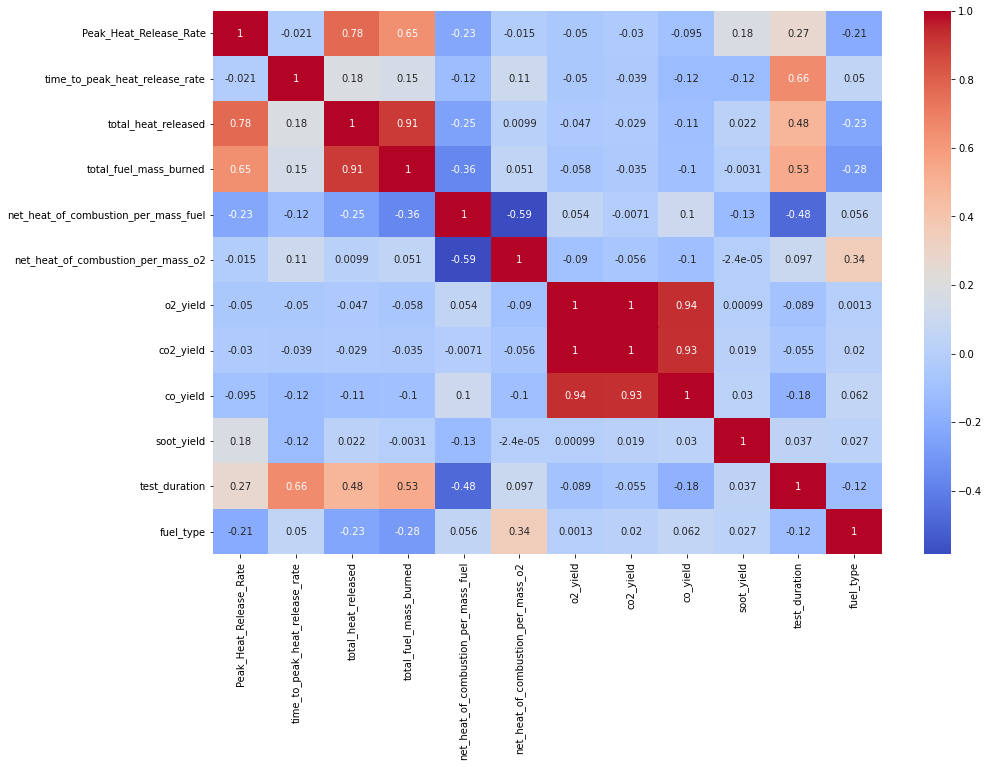

In [46]:
# Checking the Correlation Map of features and target
df_train = pd.concat([xtrain_imp, pd.DataFrame(ytrain, columns=['fuel_type'])], axis=1)

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train.corr(), cmap=col_palette, annot=True)

<font color='red'>Collinearity is a linear association between two predictors. Multicollinearity is a situation where two or more predictors are highly linearly related. In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.

Source: https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a#:~:text=Collinearity%20is%20a%20linear%20association%20between%20two%20predictors.%20Multicollinearity%20is%20a%20situation%20where%20two%20or%20more%20predictors%20are%20highly%20linearly%20related.%20In%20general%2C%20an%20absolute%20correlation%20coefficient%20of%20%3E0.7%20among%20two%20or%20more%20predictors%20indicates%20the%20presence%20of%20multicollinearity.</font>

### Dropping 'total_fuel_mass_burned', 'o2_yield' and 'co2_yield' as they are highly correlated with 'total_heat_released'(correlation=0.91), 'co_yield'(correlation=0.94) and 'co_yield'(correlation=0.93) respectively

In [47]:
xtrain_imp = xtrain_imp.drop(['total_fuel_mass_burned', 'o2_yield', 'co2_yield'], axis=1)
xtest_imp = xtest_imp.drop(['total_fuel_mass_burned', 'o2_yield', 'co2_yield'], axis=1)

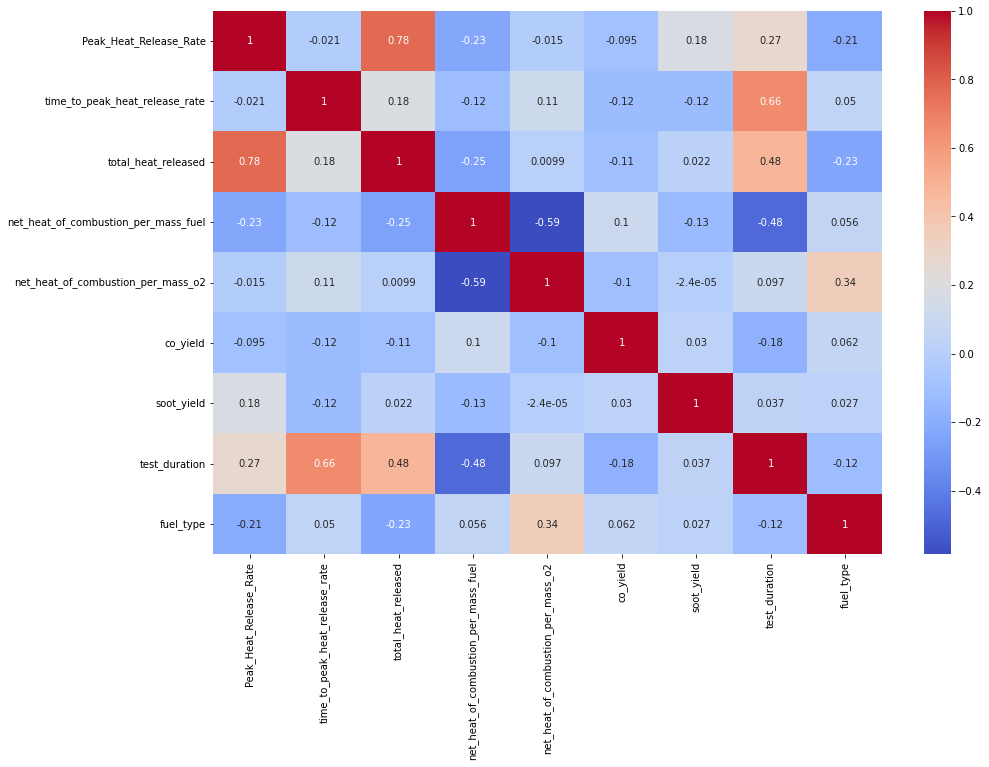

In [48]:
# Checking the Correlation Map of features and target
df_train = pd.concat([xtrain_imp, pd.DataFrame(ytrain, columns=['fuel_type'])], axis=1)

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train.corr(), cmap=col_palette, annot=True)

<Figure size 3600x3600 with 0 Axes>

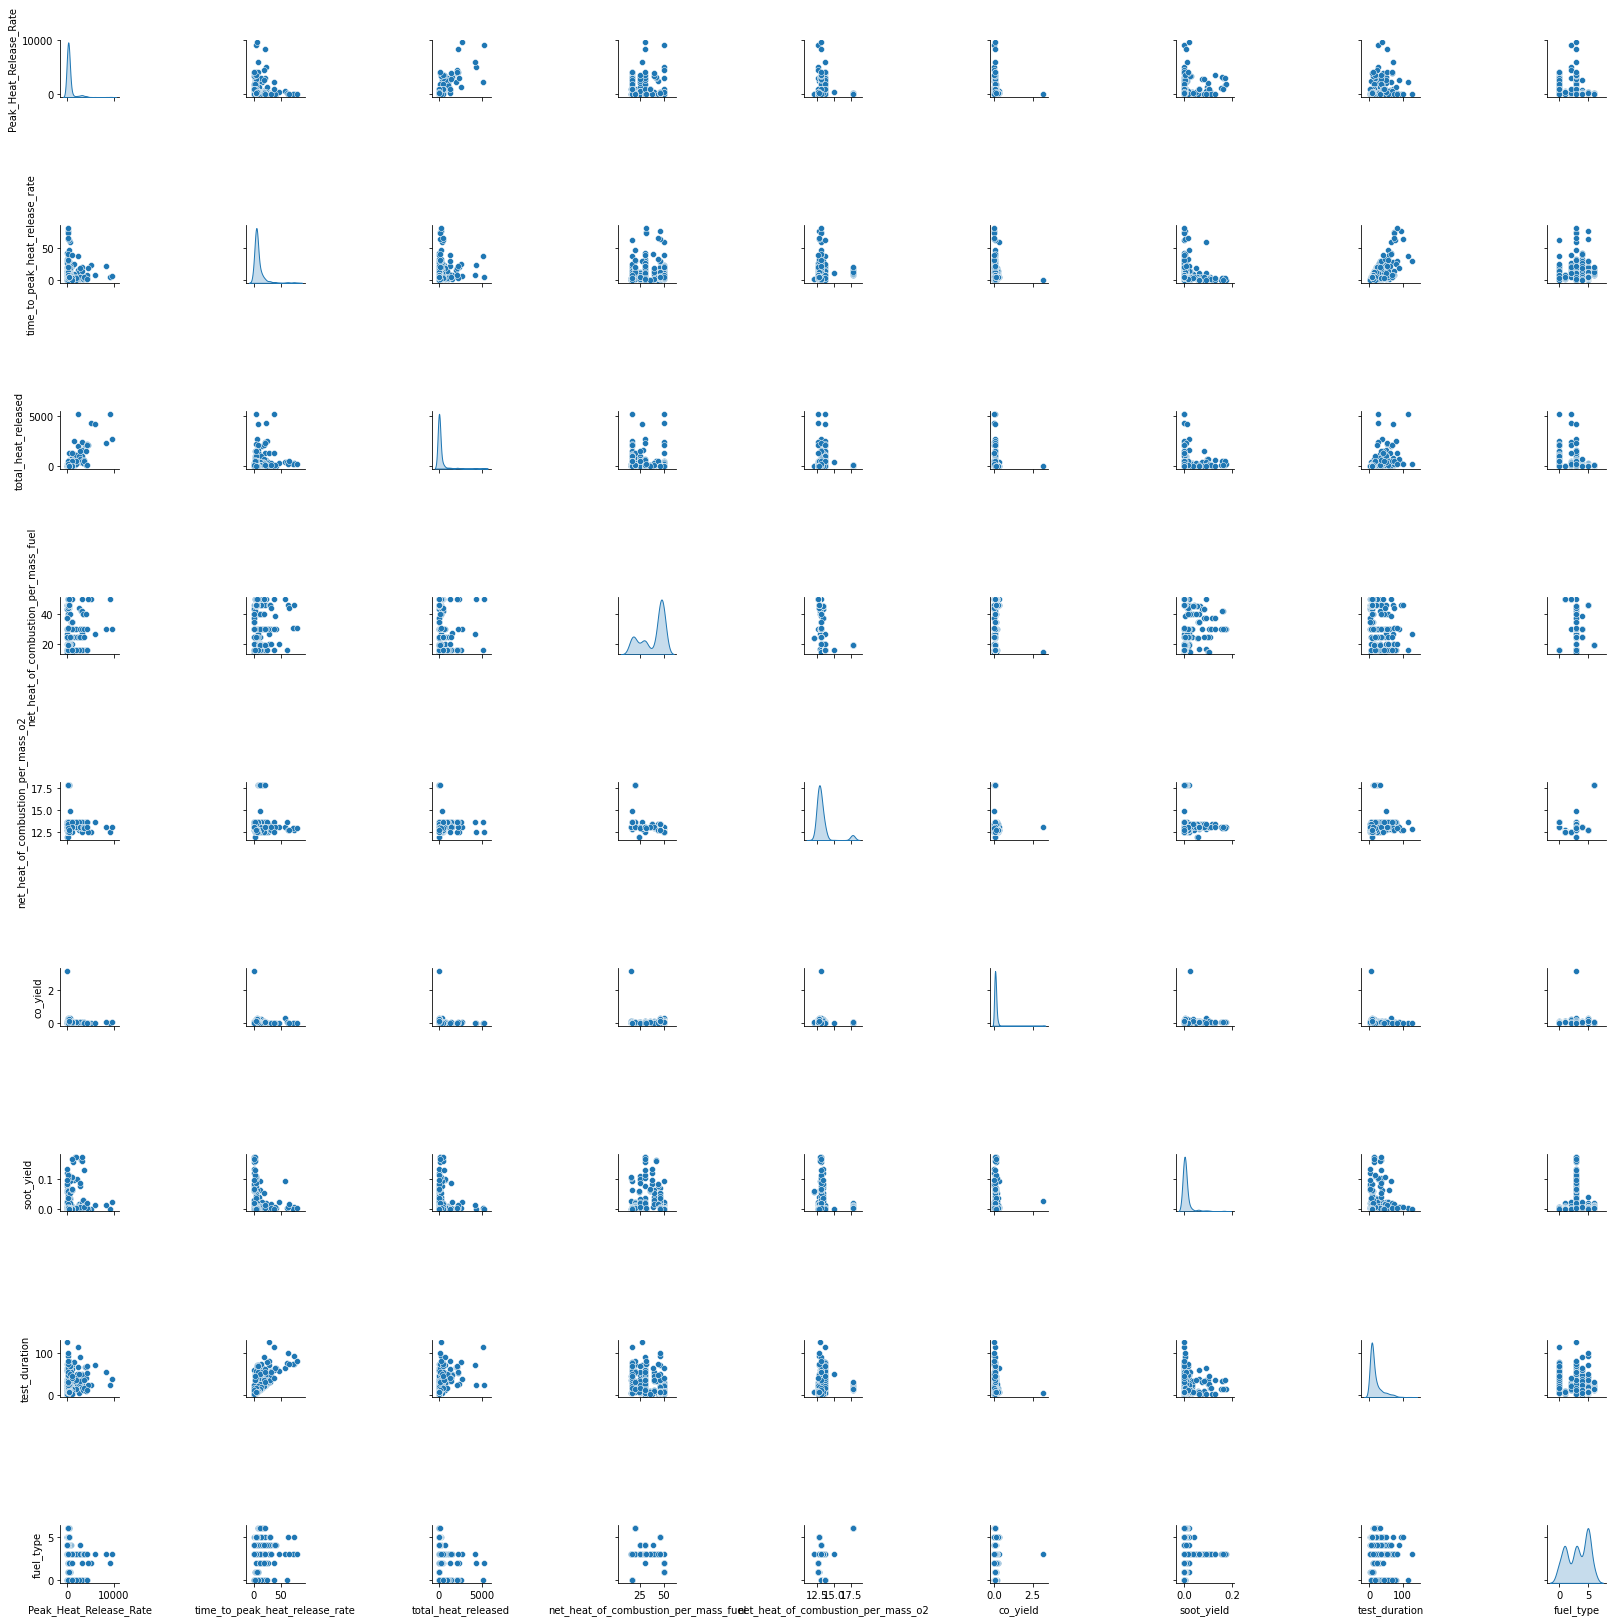

In [49]:
# Checking the relationship between different numerical features
plt.figure(figsize=(50, 50))
sns.pairplot(data=df_train, vars=df_train.columns.to_list(), diag_kind="kde")
plt.tight_layout()

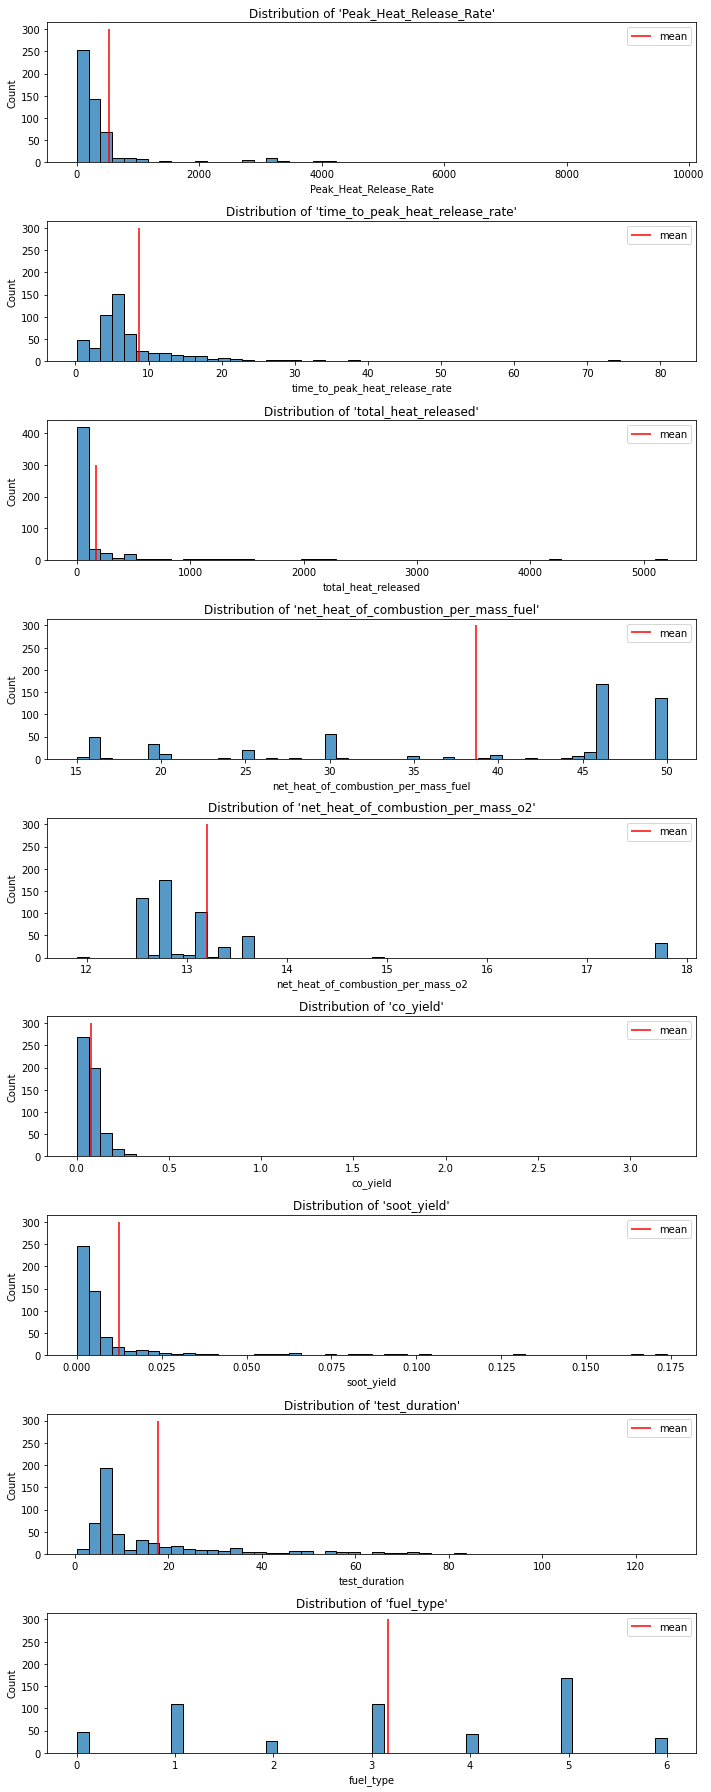

In [50]:
# Plotting distribution of features

fig, ax = plt.subplots(nrows=len(df_train.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train.columns):
  sns.histplot(df_train[var], bins=50, ax=ax[i])
  ax[i].vlines(df_train[var].mean(), ymin=0, ymax=300, colors='red', label='mean')
  ax[i].legend()
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()

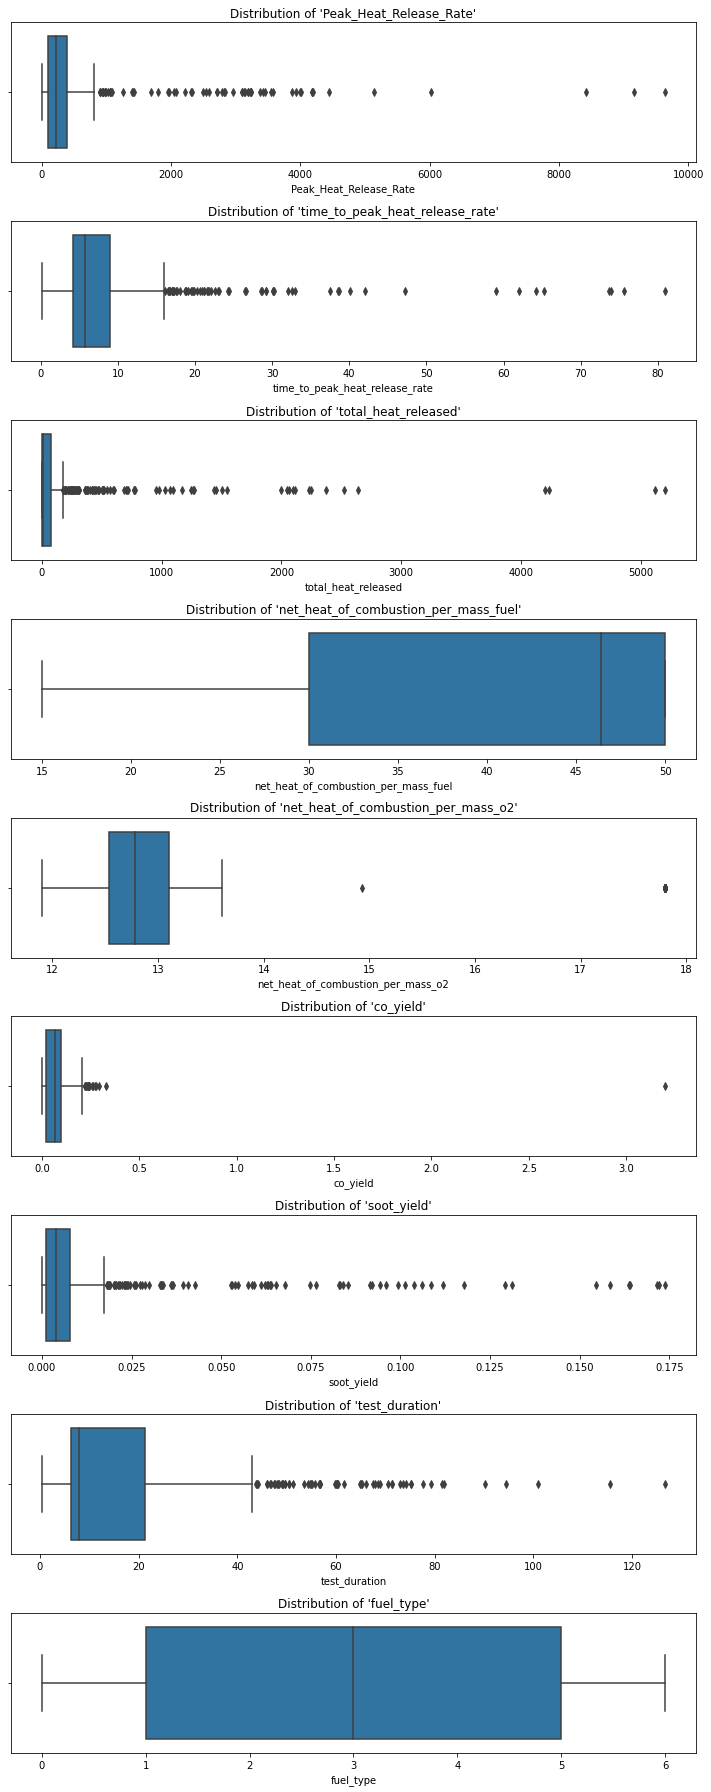

In [51]:
# Checking box_plot of feature columns

fig, ax = plt.subplots(nrows=len(df_train.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train.columns):
  sns.boxplot(x=df_train[var], ax=ax[i])
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()
# plt.figure(figsize=(25, 10))
# sns.boxplot(data=df_train)
# plt.xticks(rotation = 60)

## Perform upsampling using SMOTE

In [52]:
# Perform upsampling using SMOTE

# Define a SMOTE with random_state=rs
sm = SMOTE(random_state=rs)

# Use the SMOTE object to upsample the train data 
xtrain_res, ytrain_res = sm.fit_resample(xtrain_imp, ytrain)

In [53]:
# Value_counts before upsampling
pd.Series(ytrain).value_counts()

5    169
3    111
1    110
0     48
4     43
6     34
2     27
dtype: int64

In [54]:
# Value_counts after upsampling
pd.Series(ytrain_res).value_counts()

3    169
5    169
1    169
0    169
2    169
4    169
6    169
dtype: int64

Text(0.5, 1.0, 'After Upsampling with SMOTE')

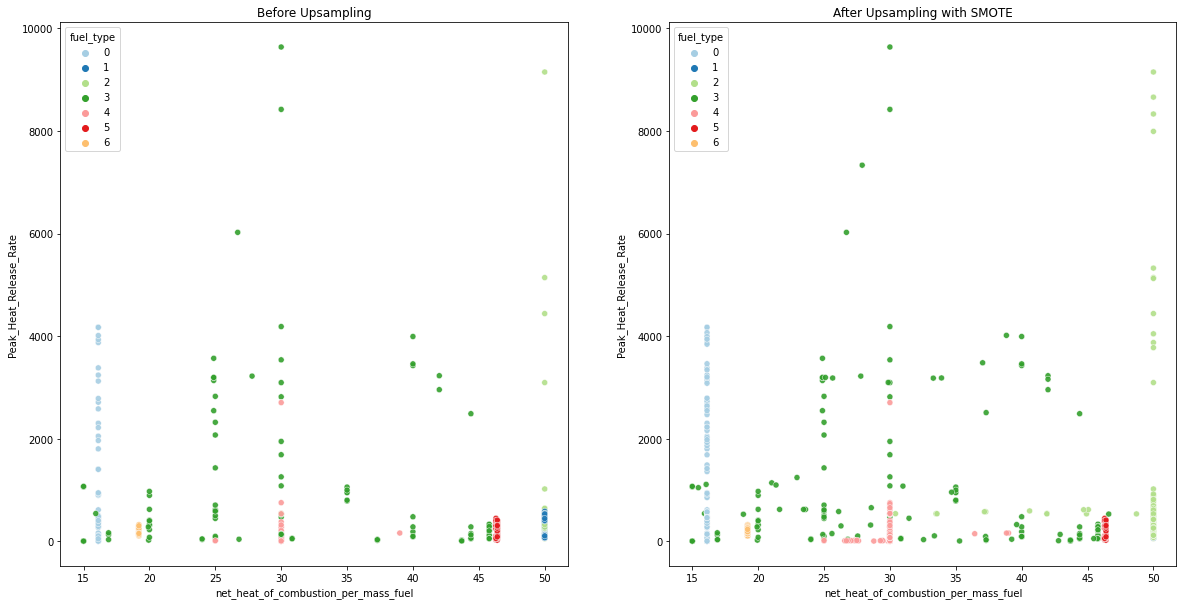

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(data=df_train, x='net_heat_of_combustion_per_mass_fuel', y='Peak_Heat_Release_Rate', hue='fuel_type', palette='Paired', alpha=0.9, ax=ax[0])
ax[0].set_title("Before Upsampling")
sns.scatterplot(data=xtrain_res, x='net_heat_of_combustion_per_mass_fuel', y='Peak_Heat_Release_Rate', hue=pd.Series(ytrain_res, name='fuel_type'), palette='Paired', alpha=0.9, ax=ax[1])
ax[1].set_title("After Upsampling with SMOTE")

In [56]:
# df_train = pd.concat([xtrain_res, pd.DataFrame(ytrain_res, columns=['fuel_type'])], axis=1)

In [57]:
# df_test = pd.concat([xtest_imp, pd.DataFrame(ytest, columns=['fuel_type'])], axis=1)

In [58]:
# df_train.to_csv(DATA_PATH+'df_train.csv', index=False)
# df_test.to_csv(DATA_PATH+'df_test.csv', index=False)

## Standardizing Train and Test Data

In [59]:
# Standardizing all the features in the Train Data

sc = StandardScaler()
xtrain_std = pd.DataFrame(sc.fit_transform(xtrain_res), columns=xtrain_imp.columns.to_list())
df_train_std = pd.concat([xtrain_std, pd.DataFrame(ytrain_res, columns=['fuel_type'])], axis=1)
df_train_std.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                0.372062                       -0.266510   
1               -0.217384                       -0.497627   
2               -0.204930                       -0.528152   
3               -0.285582                       -0.579390   
4               -0.230921                       -0.457290   

   total_heat_released  net_heat_of_combustion_per_mass_fuel  \
0             0.119978                             -1.077750   
1            -0.367903                              0.858654   
2            -0.367196                              0.813911   
3            -0.367914                              1.122709   
4            -0.367919                              0.858654   

   net_heat_of_combustion_per_mass_o2  co_yield  soot_yield  test_duration  \
0                           -0.308657 -0.237047   -0.281128      -0.233323   
1                           -0.492797  0.094203   -0.343317      -0.798359   
2                           -0.147534  0.562796    0.359639      -0.808034   
3                           -0.630902  0.353941   -0.437499      -0.841898   
4                           -0.492797  1.331796   -0.306900      -0.778041   

   fuel_type  
0          3  
1          5  
2          3  
3          1  
4          5

In [60]:
# Standardizing all the features in the Test Data

xtest_std = pd.DataFrame(sc.transform(xtest_imp), columns=xtest_imp.columns.to_list())

In [61]:
# df_test_std = pd.concat([xtest_std, pd.DataFrame(ytest, columns=['fuel_type'])], axis=1)

In [62]:
# le.classes_

In [63]:
# tmp_class = pd.DataFrame(le.classes_, columns=['Label_Encoded_Classes'])
# tmp_class

In [64]:
# df_train_std.to_csv(DATA_PATH+'df_train_std.csv', index=False)
# df_test_std.to_csv(DATA_PATH+'df_test_std.csv', index=False)
# tmp_class.to_csv(DATA_PATH+'label_encoded_classes.csv', index=False)

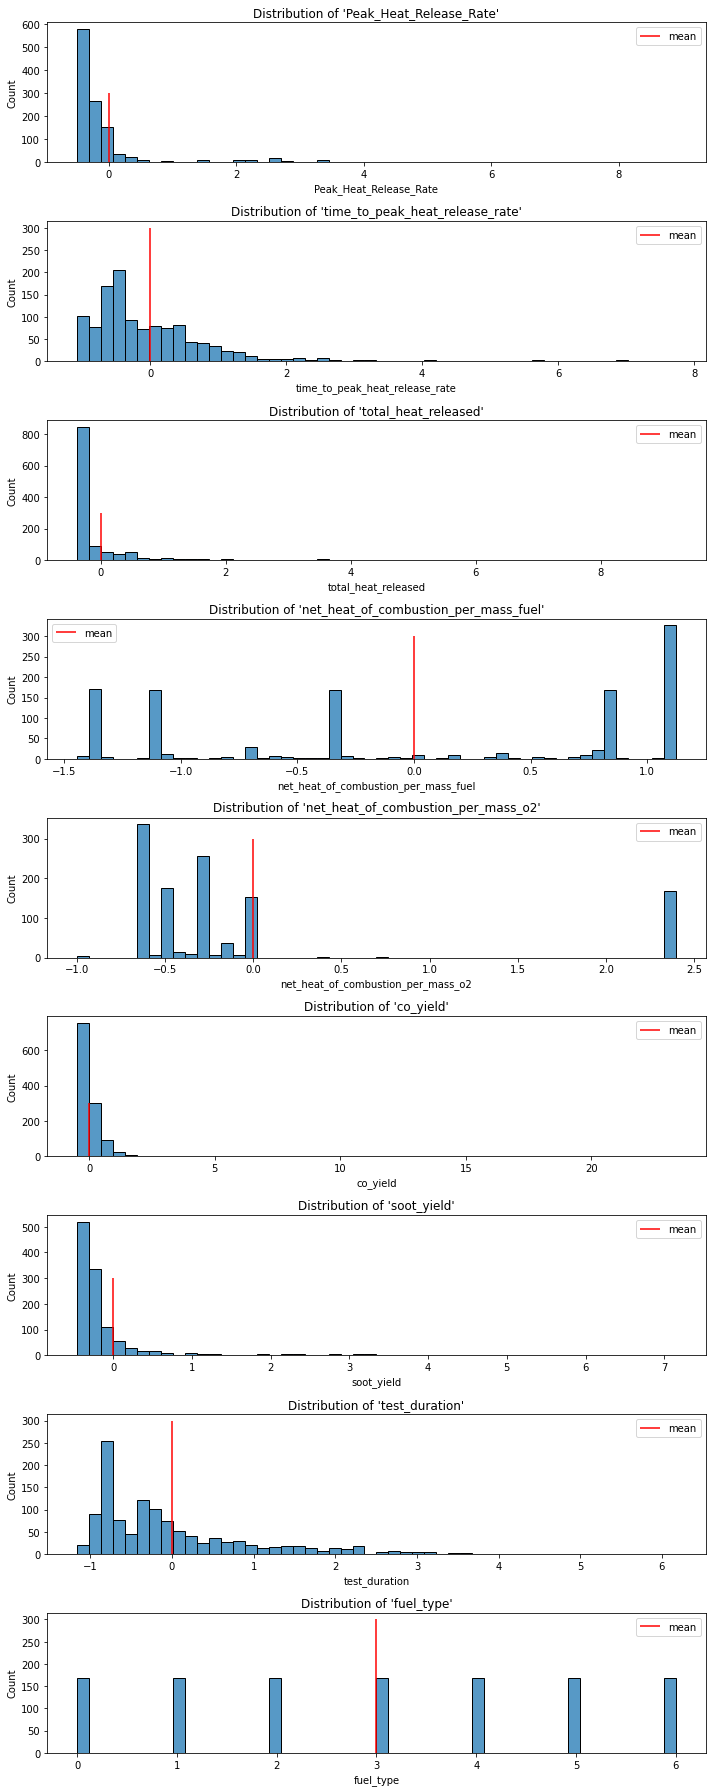

In [65]:
# Plotting distribution of features

fig, ax = plt.subplots(nrows=len(df_train_std.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train_std.columns):
  sns.histplot(df_train_std[var], bins=50, ax=ax[i])
  ax[i].vlines(df_train_std[var].mean(), ymin=0, ymax=300, colors='red', label='mean')
  ax[i].legend()
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()

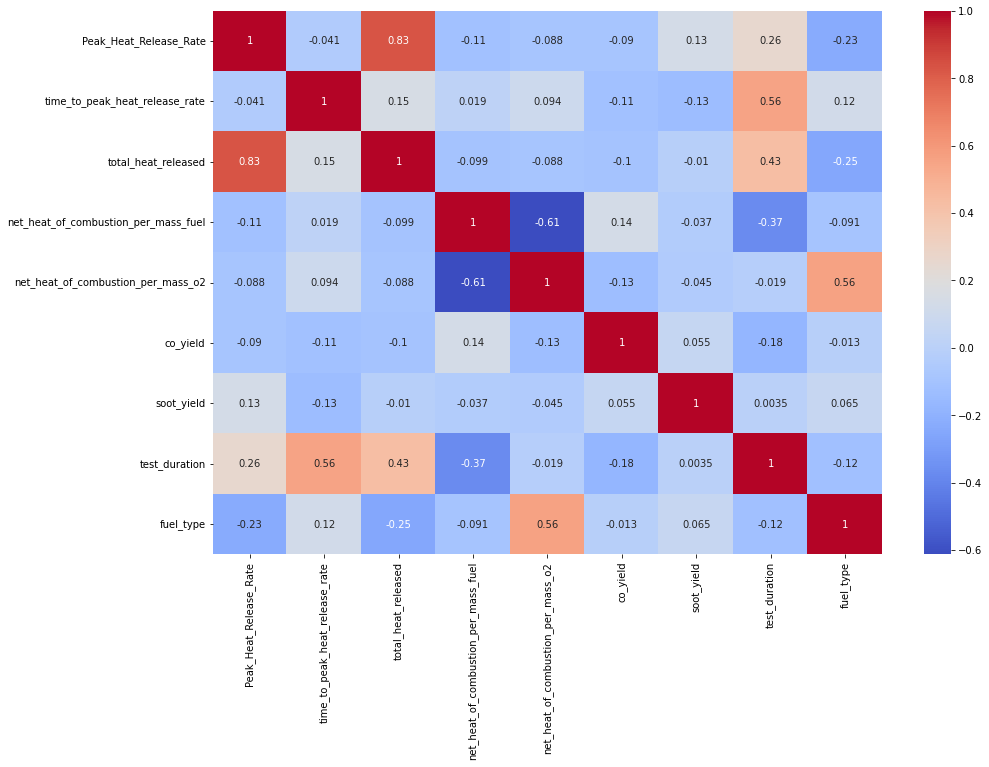

In [66]:
# Checking the Correlation Map of features and target

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train_std.corr(), cmap=col_palette, annot=True)

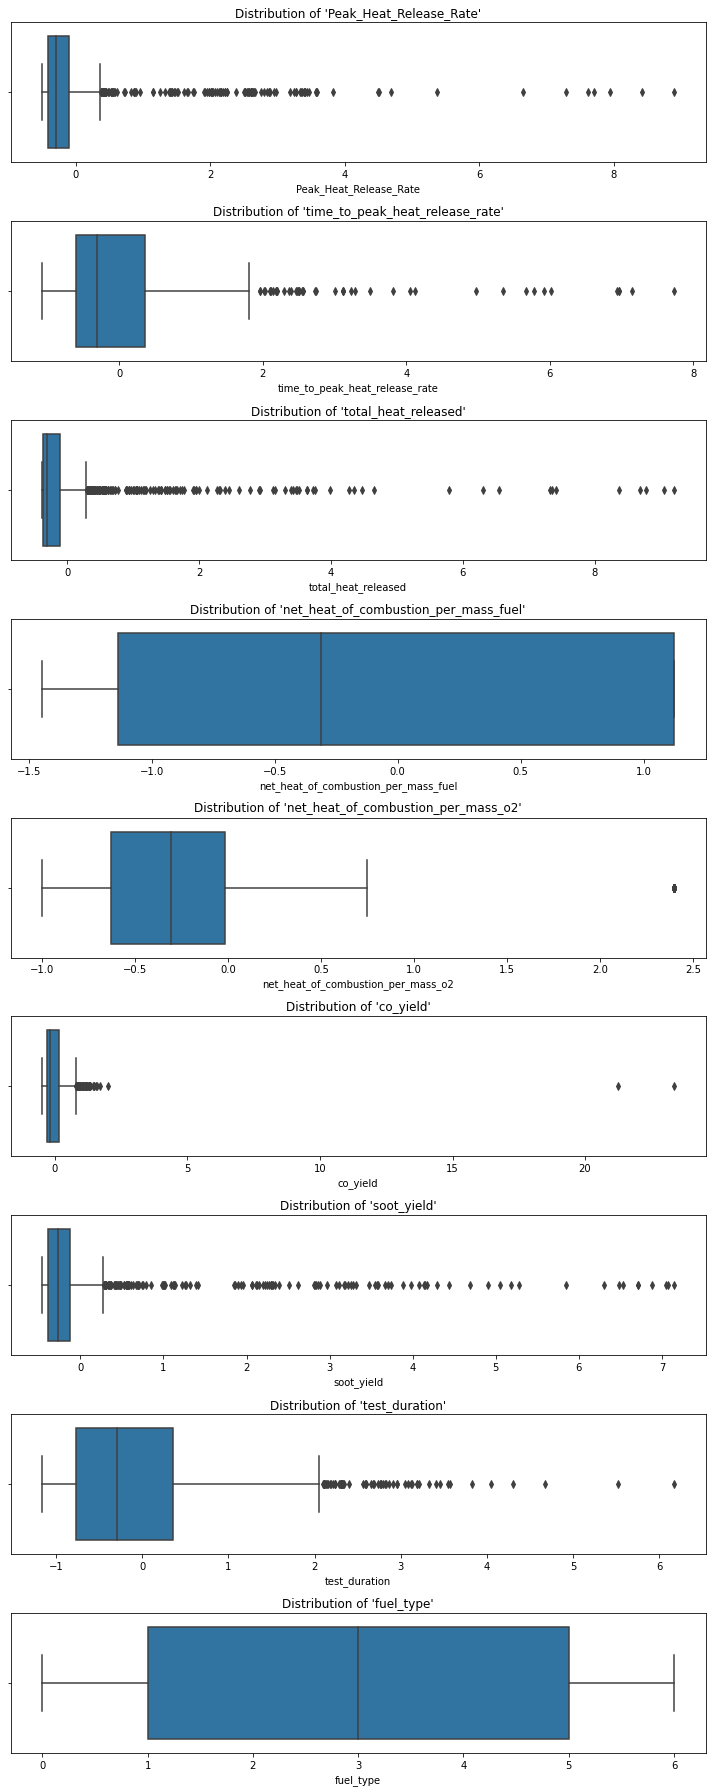

In [67]:
# Checking box_plot of feature columns

fig, ax = plt.subplots(nrows=len(df_train_std.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train_std.columns):
  sns.boxplot(x=df_train_std[var], ax=ax[i])
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()
# plt.figure(figsize=(25, 10))
# sns.boxplot(data=df_train_std)
# plt.xticks(rotation = 60)

## Helper Functions

In [68]:
# Function to get accuracy
def accuracy(X, y, model):
  return round(accuracy_score(y,model.predict(X)),2)

In [69]:
# Function to get confusion matrix
def conmatrix(X, y, model):
  return confusion_matrix(y, model.predict(X))

In [70]:
def fpr_fnr(cm):
  nrows = cm.shape[0]
  ncols = cm.shape[1]

  # True Positives
  TP = 0
  for i in range(nrows):
    TP += cm[i, i]
  
  # False Negatives
  FN = 0
  for i in range(nrows):
    FN += np.sum(cm[i, :]) - cm[i, i]
  
  # False Positives
  FP = 0
  for i in range(ncols):
    FP += np.sum(cm[:, i]) - cm[i, i]
  
  # True Negatives
  TN = 0
  tot_sum = np.sum(cm)
  for i in range(nrows):
    TN += tot_sum - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]

  fpr, fnr = round(FP/(FP+TN),3),round(FN/(FN+TP),3)

  return fpr, fnr

In [71]:
# def decision_regions(X, y, vars, clf, title):
#   # Plotting decision regions
#   # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#   # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#   # xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

#   f, axarr = plt.subplots(1, 1, figsize=(10, 8))

#   # Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#   # Z = Z.reshape(xx.shape)
#   Z = clf.predict(X).reshape(-1, 1)
#   Z = np.repeat(Z, X.shape[0], axis=1)
  
#   xx = X[vars[0]].values.reshape(1, -1)
#   xx = np.repeat(xx, X.shape[0], axis=0)
#   yy = X[vars[1]].values.reshape(-1, 1)
#   yy = np.repeat(yy, X.shape[0], axis=1)

#   axarr.contourf(xx, yy, Z, alpha=0.4)
#   axarr.scatter(x=X[vars[0]], y=X[vars[1]], c=y, s=20, edgecolor="k")
#   axarr.set_title(f"Decision Region for {title}")

#   plt.show()

## Logistic Regression

In [72]:
# Build a pipeline
lr_pipeline = Pipeline([('standardizer', StandardScaler()),('lr', LogisticRegression(max_iter=1000, random_state=rs))])

In [73]:
# Hyper-parameters tuning 
lr_grid_params = [{'lr__C': np.arange(0.1,1.1,0.1)}]

In [74]:
# Fit the model
lr_grid_search = GridSearchCV(lr_pipeline, param_grid = lr_grid_params, cv=10, scoring = "accuracy")
lr_grid_search.fit(xtrain_res, ytrain_res);

In [75]:
# Get the best parameters
print(lr_grid_search.best_estimator_.get_params())
lr_model = lr_grid_search.best_estimator_

{'memory': None, 'steps': [('standardizer', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=42))], 'verbose': False, 'standardizer': StandardScaler(), 'lr': LogisticRegression(max_iter=1000, random_state=42), 'standardizer__copy': True, 'standardizer__with_mean': True, 'standardizer__with_std': True, 'lr__C': 1.0, 'lr__class_weight': None, 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scaling': 1, 'lr__l1_ratio': None, 'lr__max_iter': 1000, 'lr__multi_class': 'auto', 'lr__n_jobs': None, 'lr__penalty': 'l2', 'lr__random_state': 42, 'lr__solver': 'lbfgs', 'lr__tol': 0.0001, 'lr__verbose': 0, 'lr__warm_start': False}


In [76]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_res, ytrain_res, lr_model)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp, ytest, lr_model)}%")

Training accuracy is: 97.0%
Testing accuracy is: 88.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

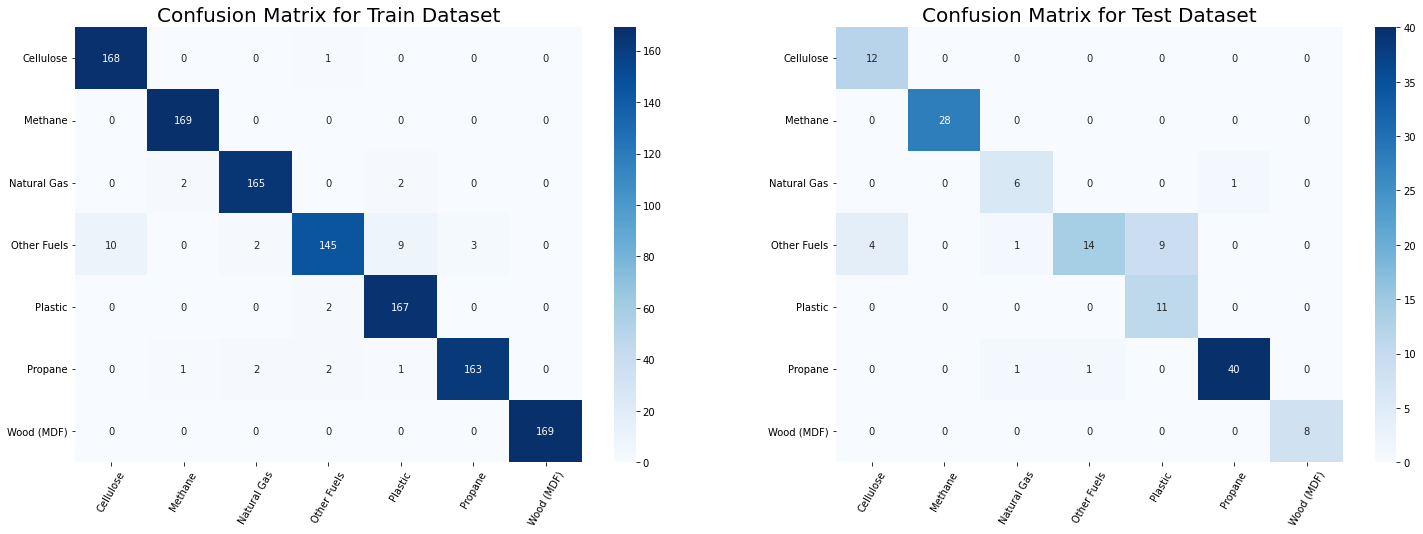

In [77]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_res, ytrain_res, lr_model)
cm_test = conmatrix(xtest_imp, ytest, lr_model)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [78]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.50%
False Negative Rate for train data: 3.10%
False Positive Rate for test data: 2.10%
False Negative Rate for test data: 12.50%


## Decision Tree

In [79]:
# Find optimal depth of trees

# Number of folds for Cross-Validation
folds = 5

# make lists of different parameters to check
parameters = {
  'max_depth':list(range(1, 30))
  }

# Initializing GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [80]:
# Fit the model
model.fit(xtrain_res, ytrain_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29]},
             return_train_score=True, scoring='accuracy')

In [81]:
# Store the average of the 5 different scores obtained in a dictionary.
# The keys in the dictionary should correspond to the max_depth and the values should correspond to the average of cross validation scores.

cross_val_acc = {}
for i, acc in enumerate(model.cv_results_['mean_test_score']):
  cross_val_acc[i+1] = acc

Text(0.5, 1.0, 'Variation of cross validation accuracy wrt max_depth')

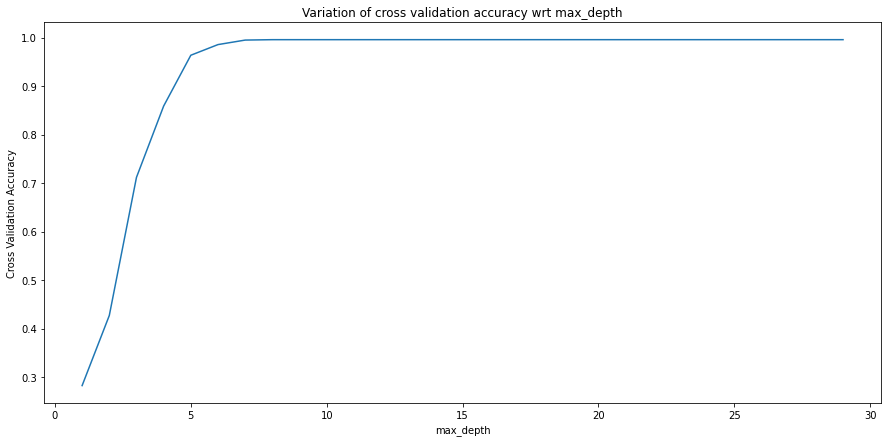

In [82]:
#Plot the variation of cross validation accuracy wrt max_depth

plt.figure(figsize=(15, 7))
sns.lineplot(x=list(cross_val_acc.keys()), y=list(cross_val_acc.values()))
plt.xlabel("max_depth")
plt.ylabel("Cross Validation Accuracy")
plt.title("Variation of cross validation accuracy wrt max_depth")

In [83]:
# Find the best depth

best_depth = model.best_params_['max_depth']
print(f"\033[1;91m The Best Parameter is: {model.best_params_}")

 The Best Parameter is: {'max_depth': 8}


In [84]:
# Fit a new model with best depth found above

dtree = DecisionTreeClassifier(max_depth=best_depth, random_state=rs)
dtree.fit(xtrain_res, ytrain_res)

DecisionTreeClassifier(max_depth=8, random_state=42)

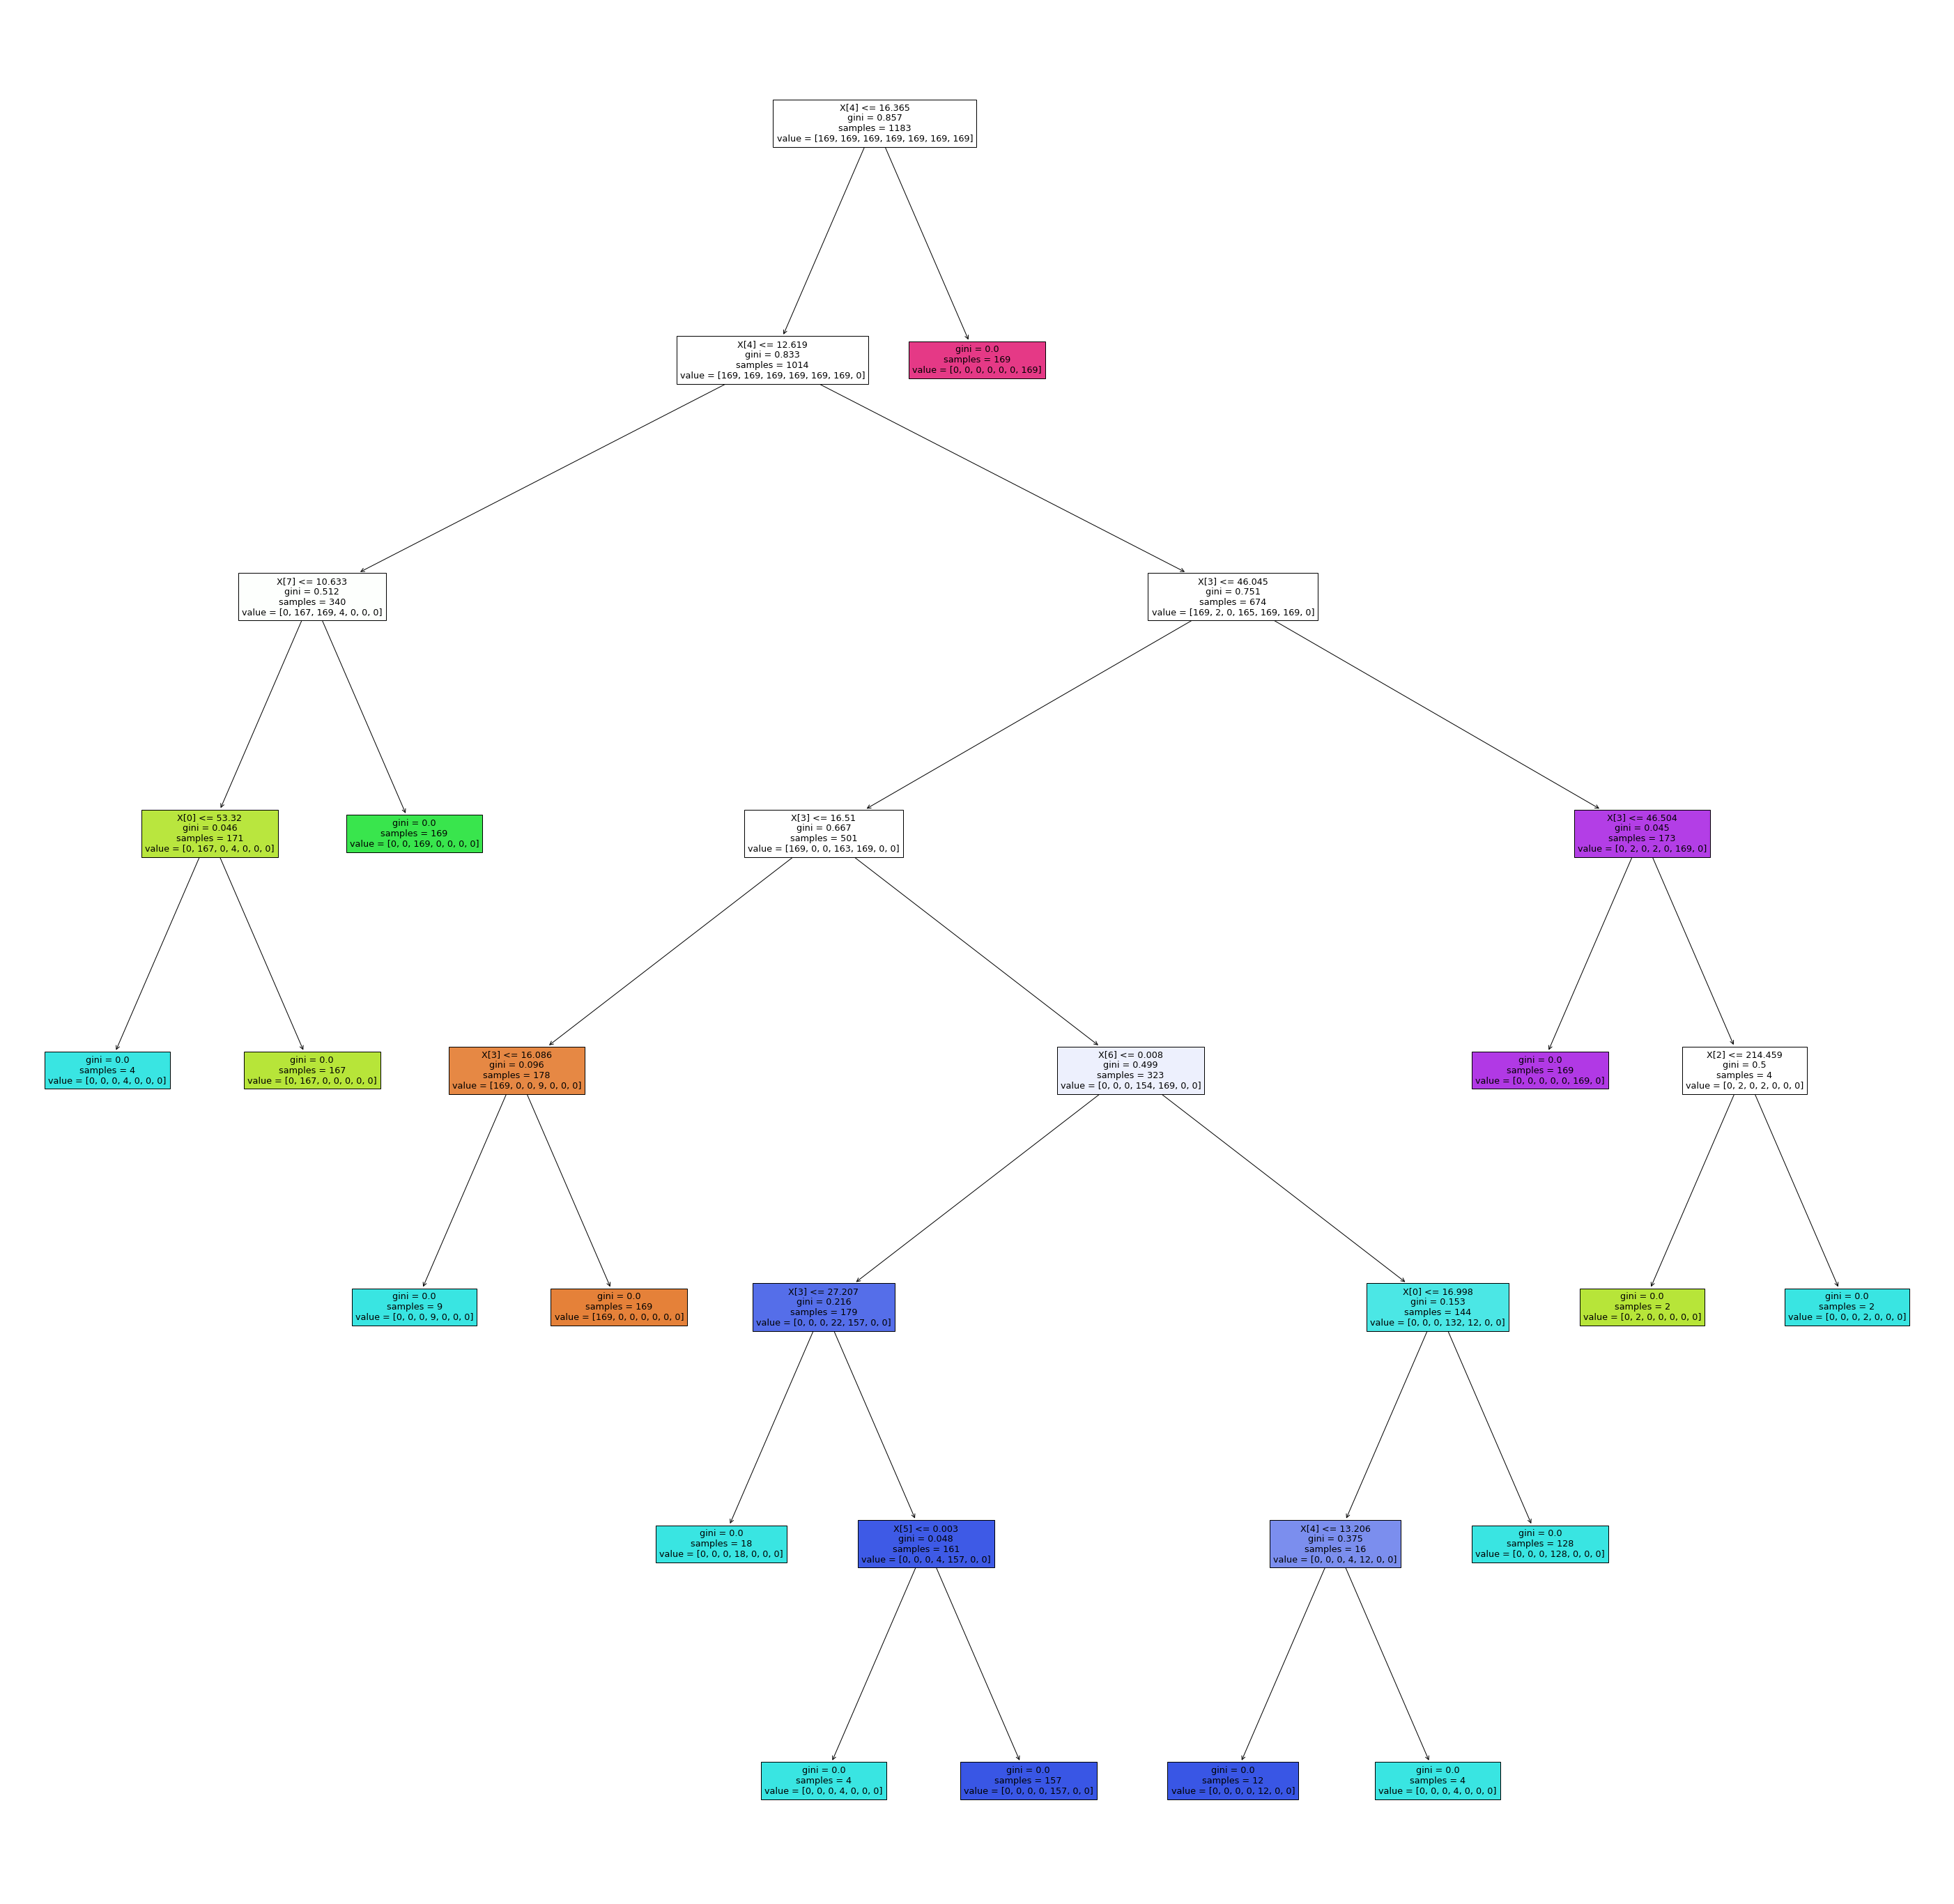

In [85]:
# Plot the tree

plt.figure(figsize=(50,50))

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(dtree, filled=True)

plt.show();

In [86]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_res, ytrain_res, dtree)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp, ytest, dtree)}%")

Training accuracy is: 100.0%
Testing accuracy is: 95.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

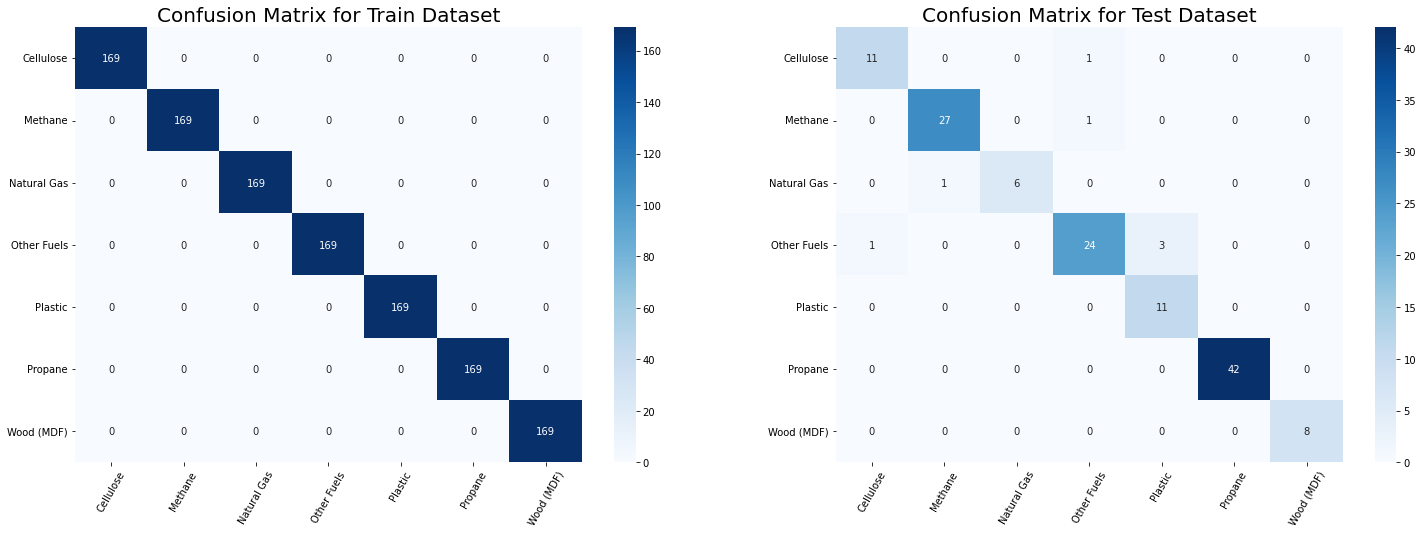

In [87]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_res, ytrain_res, dtree)
cm_test = conmatrix(xtest_imp, ytest, dtree)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [88]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.00%
False Negative Rate for train data: 0.00%
False Positive Rate for test data: 0.90%
False Negative Rate for test data: 5.10%


## Bagging Classifier

In [89]:
# bagging_parameters

# Number of folds for Cross-Validation
folds = 10

# make lists of different parameters to check
parameters = {
  'n_estimators':list(range(1, 51))
  }

# Initializing GridSearchCV
model = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=rs), random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [90]:
# Fit the model
model.fit(xtrain_res, ytrain_res)

GridSearchCV(cv=10,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                         random_state=42),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score=True, scoring='accuracy')

In [91]:
# Print the best parameters

best_n_estimators = model.best_params_['n_estimators']
print(f"\033[1;91m The Best Parameter is: {model.best_params_}")

 The Best Parameter is: {'n_estimators': 29}


In [92]:
# Fit a new model with best_n_estimators found above

bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=rs), n_estimators=best_n_estimators, random_state=rs)
bagging_clf.fit(xtrain_res, ytrain_res)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=29, random_state=42)

In [93]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_res, ytrain_res, bagging_clf)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp, ytest, bagging_clf)}%")

Training accuracy is: 100.0%
Testing accuracy is: 96.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

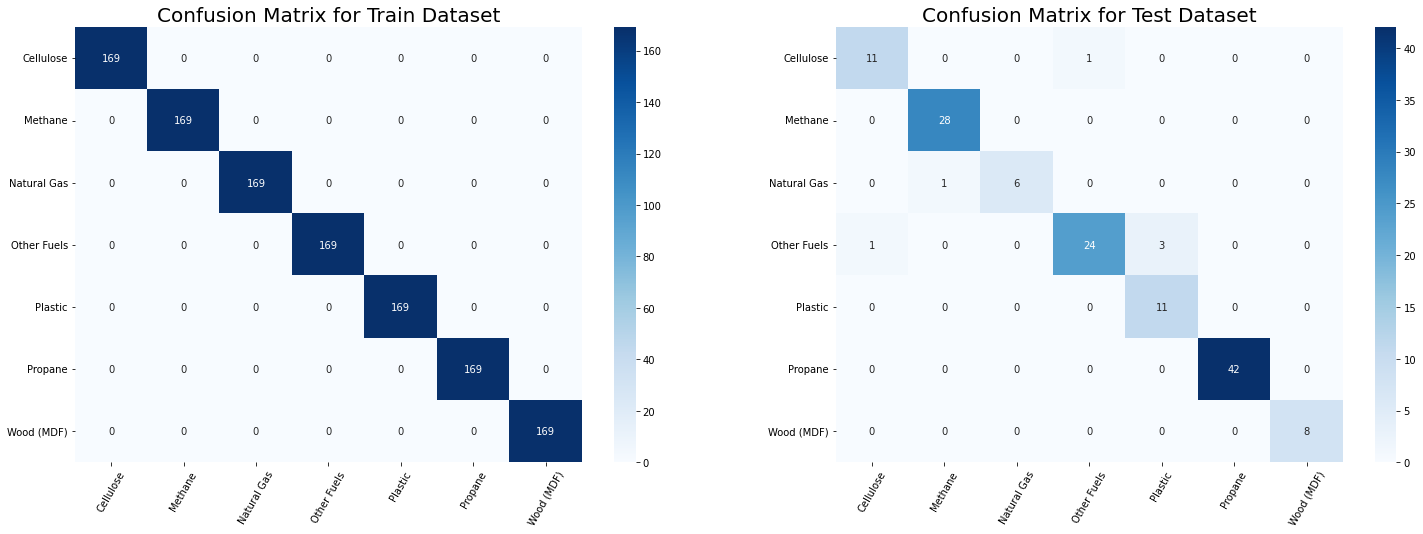

In [94]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_res, ytrain_res, bagging_clf)
cm_test = conmatrix(xtest_imp, ytest, bagging_clf)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [95]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.00%
False Negative Rate for train data: 0.00%
False Positive Rate for test data: 0.70%
False Negative Rate for test data: 4.40%


Text(0.5, 1.0, 'Permutation Feature Importances for BaggingClassifier')

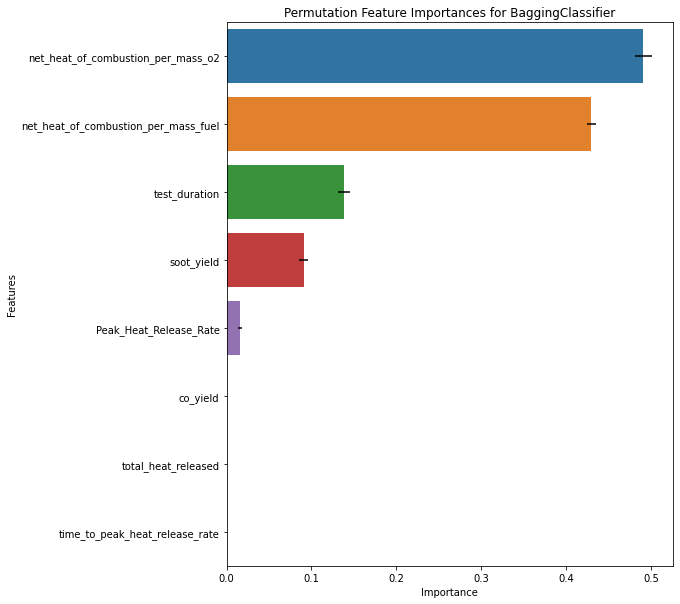

In [96]:
# Bagging importance

# Use Permutation Importance to get the importance of features for the BaggingClassifier model trained above
bagging_result = permutation_importance(bagging_clf, xtrain_res, ytrain_res, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(bagging_result['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_res.columns[idx], x=bagging_result['importances_mean'][idx], xerr=bagging_result['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for BaggingClassifier")

## Random Forest

In [97]:
param_dict = OrderedDict(n_estimators = [10, 20, 30, 40, 50, 100, 150, 200, 250], max_features = (range(2, xtrain_res.columns.shape[0])), max_depth=(range(2,10)))

In [98]:
# Calculating all possible combinations of param_dict
params_comb = product(param_dict['n_estimators'], param_dict['max_features'], param_dict['max_depth'])

In [99]:
# Fit the model for all possible combinations of param_dict

oob_error_dict = {}

for param in params_comb:
  rf = RandomForestClassifier(n_estimators=param[0], max_features=param[1], max_depth=param[2], random_state=rs, oob_score=True)
  rf.fit(xtrain_res, ytrain_res)
  oob_error_dict[param] = 1-rf.oob_score_

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probabl

In [100]:
# rf_best_params 

min_oob_error = min(oob_error_dict.values())
best_param = [key for key, val in oob_error_dict.items() if val == min_oob_error]
best_n_estimators = best_param[0][0]
best_max_features = best_param[0][1]
best_max_depth = best_param[0][2]

print(f"\033[1;91m The Best Parameters are: 'n_estimators'={best_n_estimators}, 'max_features'={best_max_features}, 'max_depth'={best_max_depth}")

 The Best Parameters are: 'n_estimators'=50, 'max_features'=4, 'max_depth'=9


In [101]:
# Fit new model

rf_tuned = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, max_depth=best_max_depth, random_state=rs, oob_score=True)
rf_tuned.fit(xtrain_res, ytrain_res)

RandomForestClassifier(max_depth=9, max_features=4, n_estimators=50,
                       oob_score=True, random_state=42)

In [102]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_res, ytrain_res, rf_tuned)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp, ytest, rf_tuned)}%")

Training accuracy is: 100.0%
Testing accuracy is: 97.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

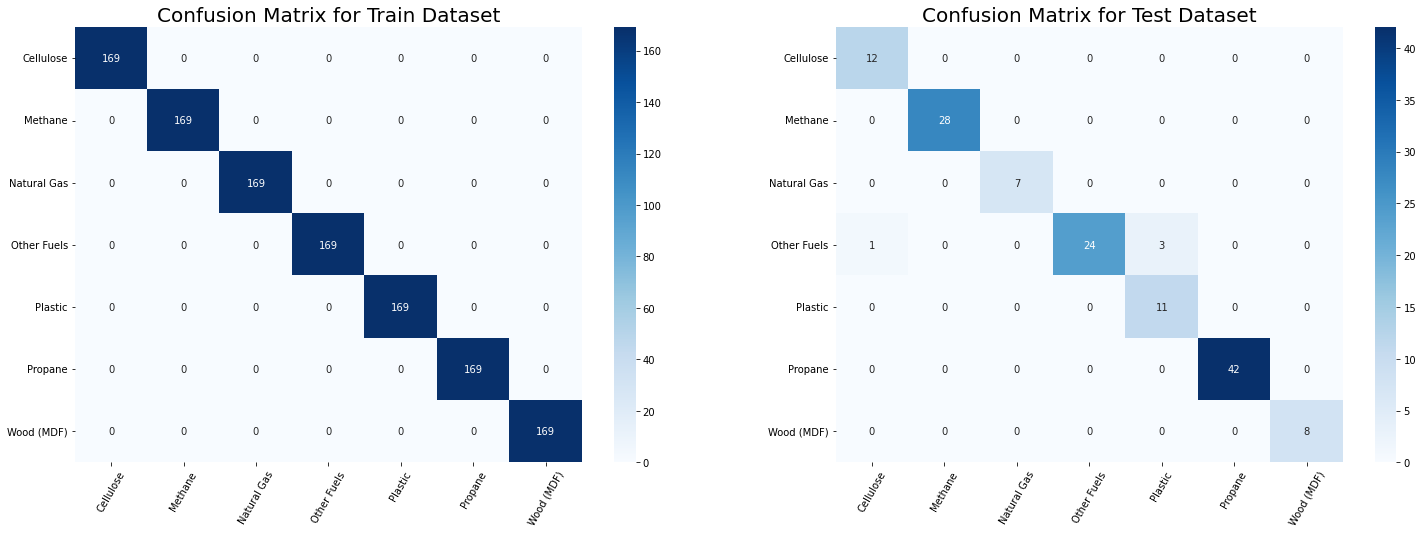

In [103]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_res, ytrain_res, rf_tuned)
cm_test = conmatrix(xtest_imp, ytest, rf_tuned)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [104]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.00%
False Negative Rate for train data: 0.00%
False Positive Rate for test data: 0.50%
False Negative Rate for test data: 2.90%


Text(0.5, 1.0, 'Permutation Feature Importances for RandomForestClassifier')

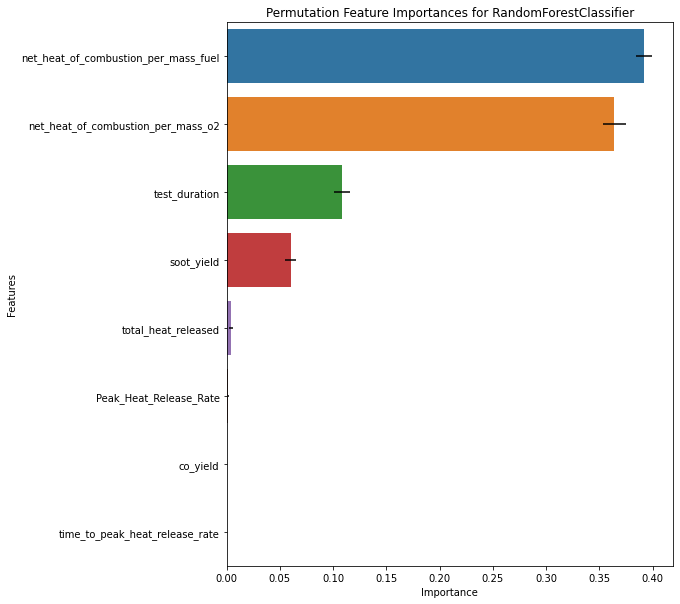

In [105]:
# RF importance 

# Use Permutation Importance to get the importance of features for the RandomForestClassifier model trained above
rf_result = permutation_importance(rf_tuned, xtrain_res, ytrain_res, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(rf_result['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_res.columns[idx], x=rf_result['importances_mean'][idx], xerr=rf_result['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for RandomForestClassifier")

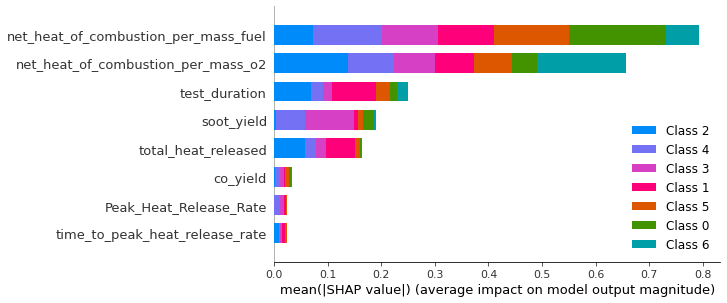

In [106]:
# Feature Importance Using Shapley Values
explainer = shap.TreeExplainer(rf_tuned)
shap_values = explainer.shap_values(xtrain_res)
shap.summary_plot(shap_values, xtrain_res, plot_type="bar")

## AdaBoost Classifier

In [107]:
#Build an adaboost model 

# Number of folds for Cross-Validation
folds = 5

# make lists of different parameters to check
parameters = {
  'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
  'learning_rate': [0.001, 0.01, 0.05, 0.07, 0.09, 0.1, 0.5, 1, 5, 10]
  }

# Initializing GridSearchCV
model = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=rs), random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [108]:
# Fit the model
model.fit(xtrain_res, ytrain_res)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=42),
                                          random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.07, 0.09, 0.1,
                                           0.5, 1, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200,
                                          250, 300, 350, 400, 450, 500]},
             return_train_score=True, scoring='accuracy')

In [109]:
# Print the best parameters

best_n_estimators = model.best_params_['n_estimators']
best_learning_rate = model.best_params_['learning_rate']
print(f"\033[1;91m The Best Parameters are: {model.best_params_}")

 The Best Parameters are: {'learning_rate': 5, 'n_estimators': 400}


In [110]:
# Fit a new model with best_n_estimators and best_learning_rate found above

adaboost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=rs), n_estimators=best_n_estimators, learning_rate=best_learning_rate, random_state=rs)
adaboost_clf.fit(xtrain_res, ytrain_res)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=42),
                   learning_rate=5, n_estimators=400, random_state=42)

In [111]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_res, ytrain_res, adaboost_clf)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp, ytest, adaboost_clf)}%")

Training accuracy is: 96.0%
Testing accuracy is: 91.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

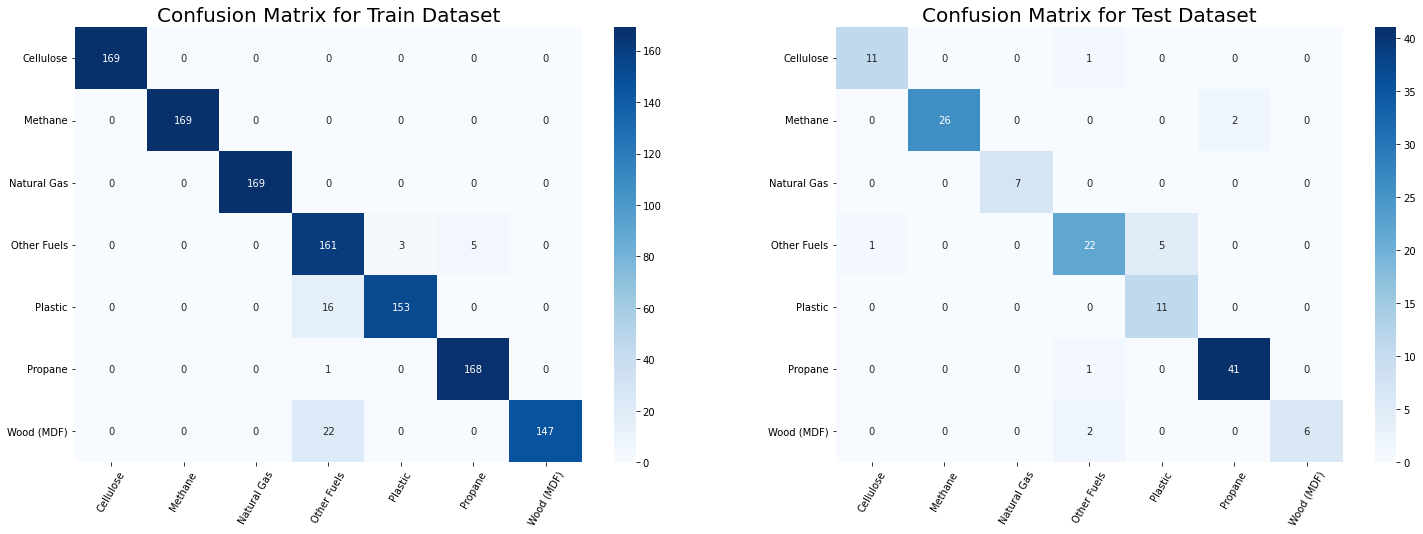

In [112]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_res, ytrain_res, adaboost_clf)
cm_test = conmatrix(xtest_imp, ytest, adaboost_clf)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [113]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.70%
False Negative Rate for train data: 4.00%
False Positive Rate for test data: 1.50%
False Negative Rate for test data: 8.80%


Text(0.5, 1.0, 'Permutation Feature Importances for AdaBoostClassifier')

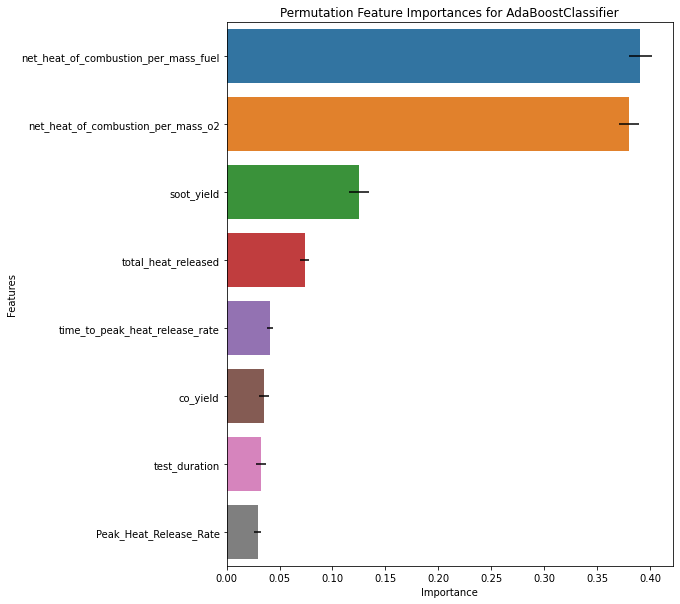

In [114]:
# AdaBoost importance 

# Use Permutation Importance to get the importance of features for the AdaBoostClassifier model trained above
adaboost_result = permutation_importance(adaboost_clf, xtrain_res, ytrain_res, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(adaboost_result['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_res.columns[idx], x=adaboost_result['importances_mean'][idx], xerr=adaboost_result['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for AdaBoostClassifier")

In [115]:
# # Feature Importance Using Shapley Values
# explainer = shap.KernelExplainer(adaboost_clf.predict, data=xtrain_res)
# shap_values = explainer.shap_values(xtrain_res)
# shap.summary_plot(shap_values, xtrain_res, plot_type="bar")

## Comparing All Models

### Plot the train and test accuracies as a bar plot along with the confusion matrix for all 5 models.

Text(0.5, 1.0, 'Comparison of Train and Test Accuracy Performance of All Models on Non-Augmented Dataset')

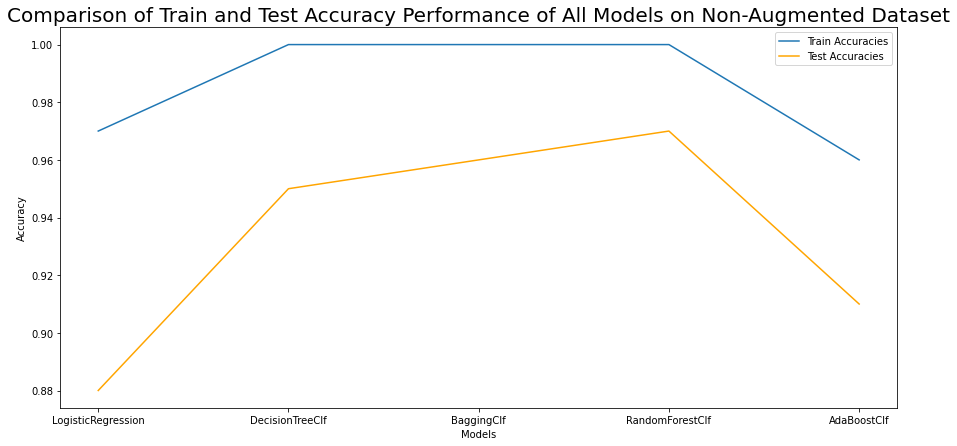

In [116]:
# Comparing test accuracy performance of all models

model_names = ['LogisticRegression', 'DecisionTreeClf', 'BaggingClf', 'RandomForestClf', 'AdaBoostClf']
model_objects = [lr_model, dtree, bagging_clf, rf_tuned, adaboost_clf]
train_acc = [accuracy(xtrain_res, ytrain_res, lr_model), accuracy(xtrain_res, ytrain_res, dtree), accuracy(xtrain_res, ytrain_res, bagging_clf), accuracy(xtrain_res, ytrain_res, rf_tuned), accuracy(xtrain_res, ytrain_res, adaboost_clf)]
test_acc = [accuracy(xtest_imp, ytest, lr_model), accuracy(xtest_imp, ytest, dtree), accuracy(xtest_imp, ytest, bagging_clf), accuracy(xtest_imp, ytest, rf_tuned), accuracy(xtest_imp, ytest, adaboost_clf)]

plt.figure(figsize=(15, 7))
plt.plot(model_names, train_acc, label='Train Accuracies')
plt.plot(model_names, test_acc, color='orange', label='Test Accuracies')
plt.legend()
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title("Comparison of Train and Test Accuracy Performance of All Models on Non-Augmented Dataset", fontdict={'fontsize': 20})

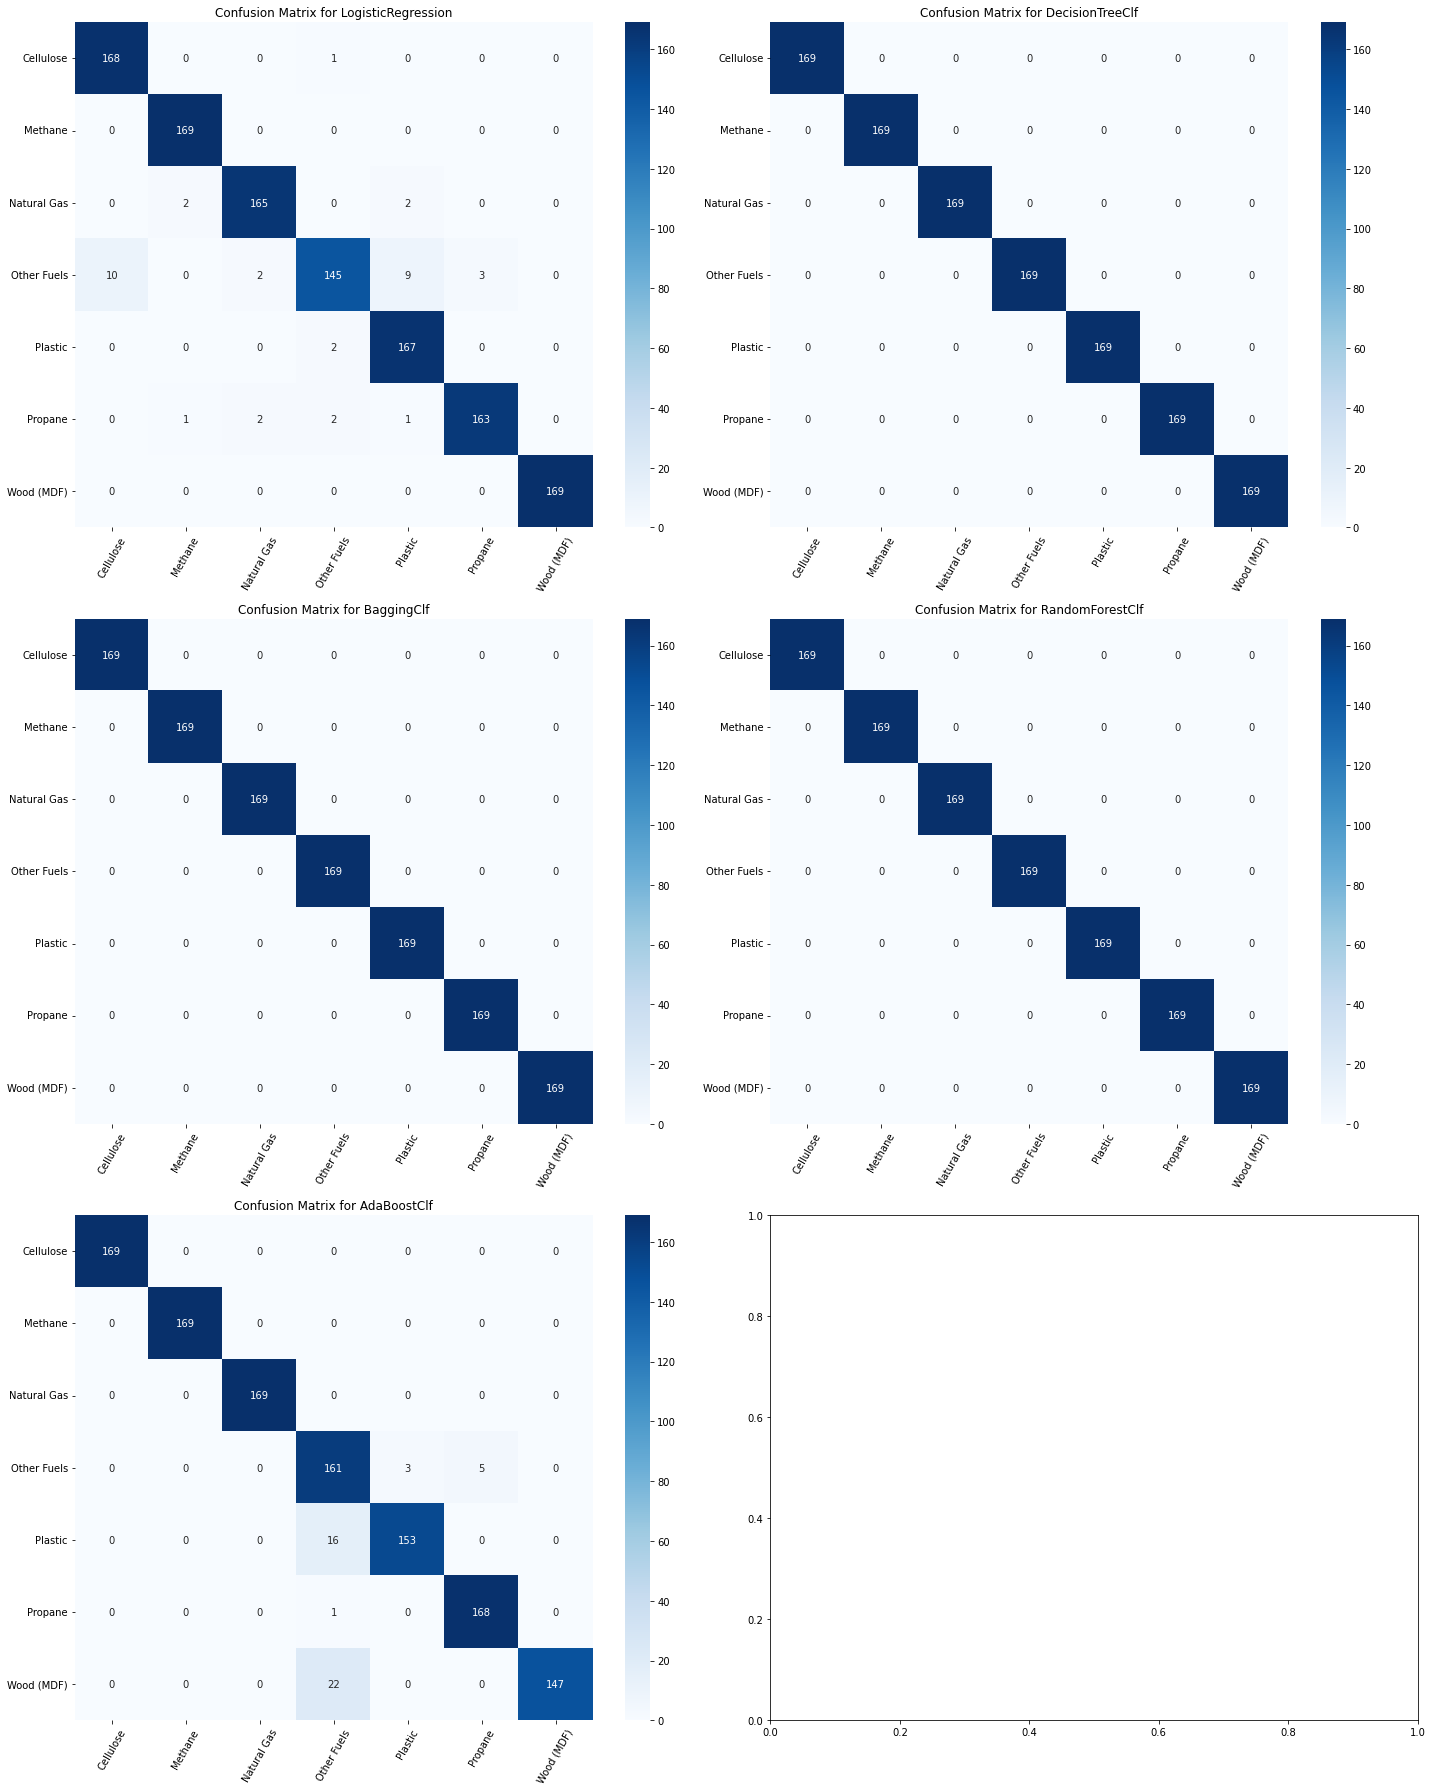

In [117]:
# Comparing train confusion matrix performance of all models

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    sns.heatmap(conmatrix(xtrain_res, ytrain_res, model_objects[i]), annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.xaxis.set_ticklabels(list(le.classes_), rotation=60); 
    ax.yaxis.set_ticklabels(list(le.classes_), rotation=0);
    ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

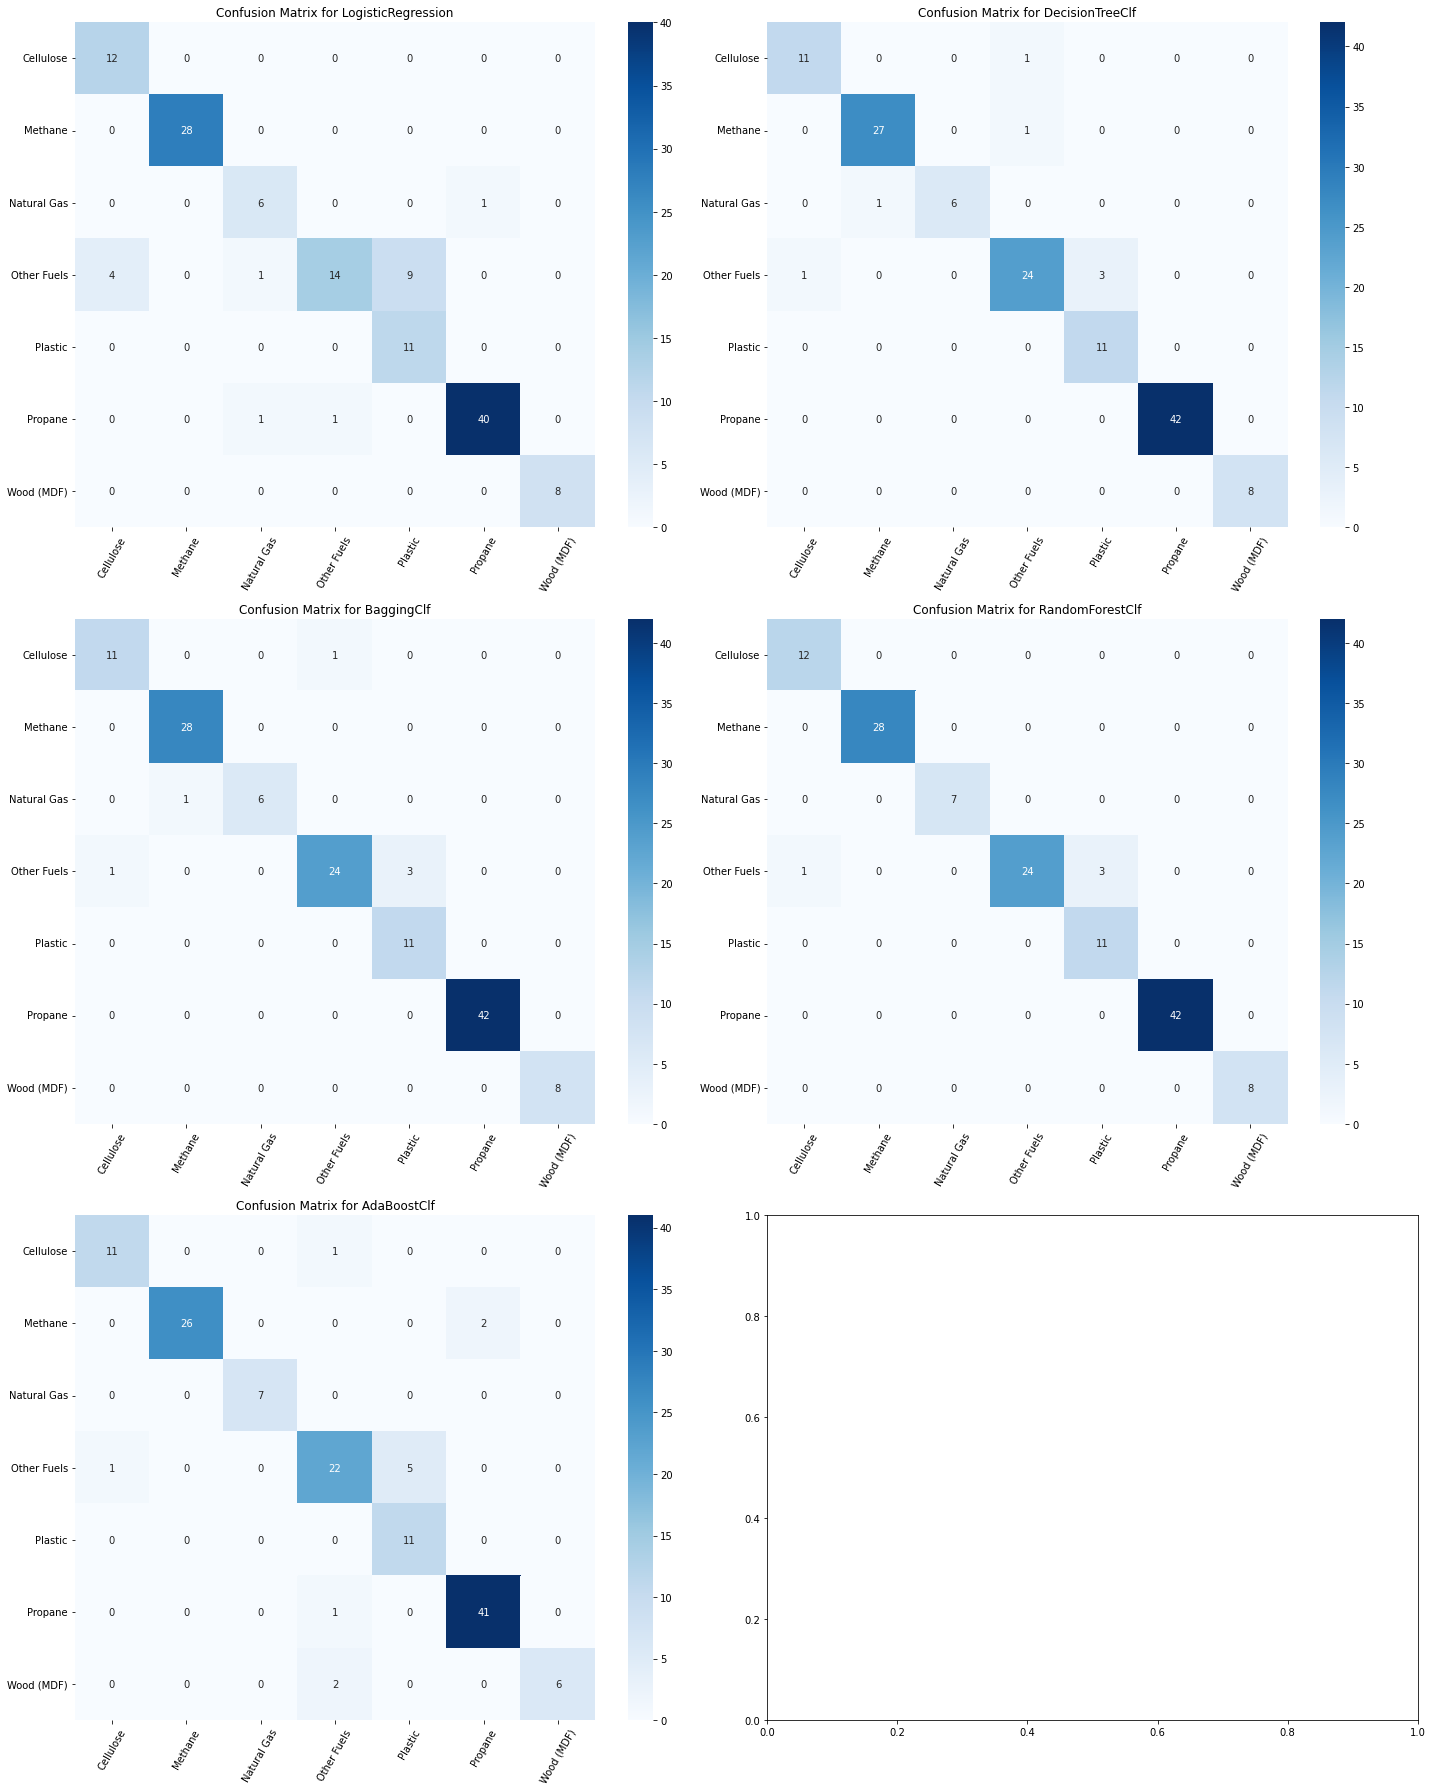

In [118]:
# Comparing test confusion matrix performance of all models

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    sns.heatmap(conmatrix(xtest_imp, ytest, model_objects[i]), annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.xaxis.set_ticklabels(list(le.classes_), rotation=60); 
    ax.yaxis.set_ticklabels(list(le.classes_), rotation=0);
    ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

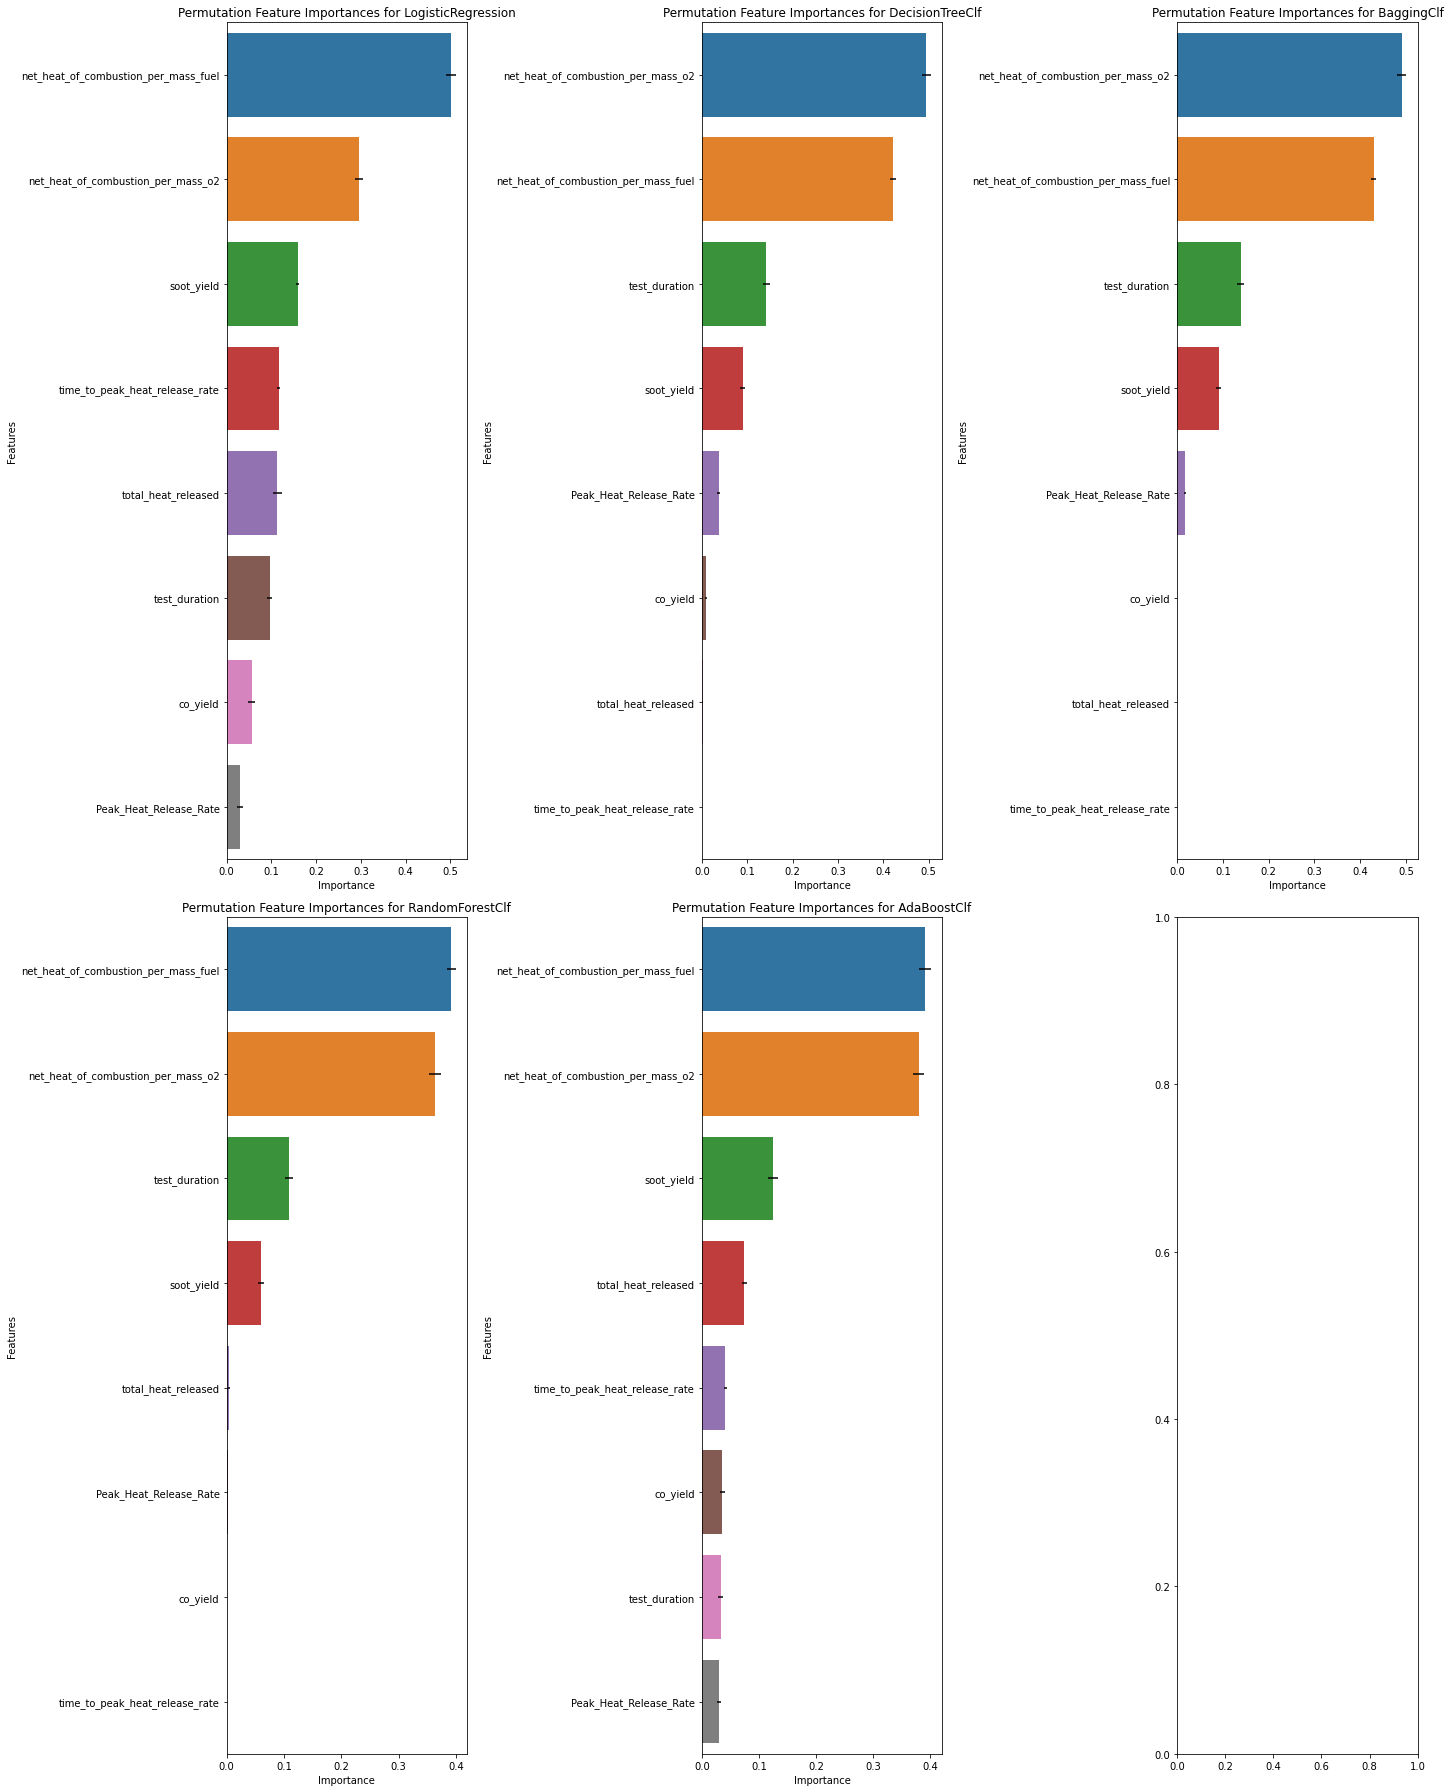

In [119]:
# Comparing feature importance from all models

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    result = permutation_importance(model_objects[i], xtrain_res, ytrain_res, scoring='accuracy', n_repeats=10, random_state=rs)
    idx = np.argsort(result['importances_mean'])[-1::-1]
    sns.barplot(y=xtrain_res.columns[idx], x=result['importances_mean'][idx], xerr=result['importances_std'][idx], orient='h', ax=ax)
    ax.set_xlabel("Importance"); 
    ax.set_ylabel("Features");
    ax.set_title(f"Permutation Feature Importances for {model_names[i]}", fontdict={'fontsize': 12})
  # if i==0:
  #   plot_confusion_matrix(model_objects[i], X_test_transformed, y_test, ax=ax)
  #   ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
  # else:
  #   plot_confusion_matrix(model_objects[i], X_test, y_test, ax=ax)
  #   ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

# 'fuel_type' Classification Using Augmented Dataset

## Importing Dataset

In [120]:
dataset = pd.read_csv(DATA_PATH+'FCDSummaryValues.csv')

# We will use the uncertainty values for data augmentation. So, dropping those columns for the analysis and predictions on the non-augmented data.
# Also, dropping the 'Unnamed: 0', 'id' and 'url_name' columns as they are not relevant for modeling.
useful_cols = ['Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned', 'net_fuel_mass', 'net_effective_heat_of_combustion',
               'net_heat_of_combustion_per_mass_fuel', 'net_heat_of_combustion_per_mass_o2', 'o2_yield', 'co2_yield', 'co_yield', 'soot_yield', 'test_duration', 'fuel_type']

df = dataset[useful_cols]
print(f"\033[1;91m Shape of the dataset after dropping the non-relevant columns: {df.shape}")

df = df[df['o2_yield']>=0.0]
df = df[df['co2_yield']>=0.0]
df = df[df['co_yield']>=0.0]
df = df[df['soot_yield']>=0.0]

print(f"\033[1;91m Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: {df.shape}")

# Replacing NULL values in 'net_fuel_mass' by np.nan
idx = df[df['net_fuel_mass'].isnull()].index.to_list()
df.loc[idx, 'net_fuel_mass'] = np.nan

# Replacing NULL values in 'net_effective_heat_of_combustion' by np.nan
idx = df[df['net_effective_heat_of_combustion'].isnull()].index.to_list()
df.loc[idx, 'net_effective_heat_of_combustion'] = np.nan

# # Replacing NULL values in 'soot_yield' by np.nan
# idx = df[df['soot_yield'].isnull()].index.to_list()
# df.loc[idx, 'soot_yield'] = np.nan

# Replacing NULL values in 'test_duration' by np.nan
idx = df[df['test_duration'].isnull()].index.to_list()
df.loc[idx, 'test_duration'] = np.nan

# Dropping 'net_fuel_mass', 'net_effective_heat_of_combustion' as number of missing values = ~75%
df = df.drop(['net_fuel_mass', 'net_effective_heat_of_combustion'], axis=1)
print(f"\033[1;91m Shape of the dataset after dropping 'net_fuel_mass' and 'net_effective_heat_of_combustion' feature columns: {df.shape}")

 Shape of the dataset after dropping the non-relevant columns: (1021, 14)
 Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: (678, 14)
 Shape of the dataset after dropping 'net_fuel_mass' and 'net_effective_heat_of_combustion' feature columns: (678, 12)


In [121]:
# Checking Class Balance of 'fuel_type'
df['fuel_type'].value_counts()

Propane                                                      211
Methane                                                      138
Cellulose                                                     60
Plastic                                                       54
Wood (MDF)                                                    42
Natural Gas                                                   34
Cellulose, Plastic                                            18
Propylene                                                     17
Polyisocyanurate Foam (foil-backed)                            8
Heptane                                                        8
Plastics, Natural Gas                                          7
Extruded Polystyrene Foam (XPS)                                7
Polymethyl methacrylate (PMMA)                                 6
Cross-linked polyethylene foam (XLPE)                          5
Cellulose, Polystyrene                                         5
Methanol                 

<font color='red'>We can see that the 'fuel_type' class is highly imbalanced. We will oversample using augmented dataset that we have created using uncertainty values.</font>

**Importing Augmented Dataset**

In [122]:
dataset_aug = pd.read_csv(DATA_PATH+'df_augmented.csv')

In [123]:
dataset_aug.head()

Unnamed: 0  Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0           0               95.029878                       21.437567   
1           1               95.369161                       21.390054   
2           2               94.438043                       21.390338   
3           3               99.259395                       21.458463   
4           4               93.069798                       21.405776   

   total_heat_released  total_fuel_mass_burned  \
0           169.275600               10.007747   
1           176.095985                9.740837   
2           180.844898               10.012727   
3           173.348368               10.006249   
4           171.868892               10.593868   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                             17.283111                           12.761973   
1                             16.452766                           12.793619   
2                             17.126395                           12.992410   
3                             16.637775                           12.331015   
4                             17.147787                           12.709149   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration         fuel_type  
0  1.289253   0.952221  0.121976    0.007354      55.817289  PVC, Natural Gas  
1  1.183770   1.003292  0.102805    0.007395      55.818387  PVC, Natural Gas  
2  1.163613   0.976422  0.110589    0.011404      55.810260  PVC, Natural Gas  
3  1.290913   1.005947  0.112156    0.012201      55.810768  PVC, Natural Gas  
4  1.294114   1.046823  0.112464    0.006001      55.808434  PVC, Natural Gas

In [124]:
print(f"\033[1;91m Shape of the dataset: {dataset_aug.shape}")

 Shape of the dataset: (102100, 13)


In [125]:
# Print the columns of the dataset
print(f"\033[1;91m Initial Feature Columns in the Dataset: {dataset_aug.columns}")

 Initial Feature Columns in the Dataset: Index(['Unnamed: 0', 'Peak_Heat_Release_Rate',
       'time_to_peak_heat_release_rate', 'total_heat_released',
       'total_fuel_mass_burned', 'net_heat_of_combustion_per_mass_fuel',
       'net_heat_of_combustion_per_mass_o2', 'o2_yield', 'co2_yield',
       'co_yield', 'soot_yield', 'test_duration', 'fuel_type'],
      dtype='object')


In [126]:
# Dropping the 'Unnamed: 0' column as it is not relevant for modeling.

useful_cols = ['Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned',
               'net_heat_of_combustion_per_mass_fuel', 'net_heat_of_combustion_per_mass_o2', 'o2_yield', 'co2_yield', 'co_yield', 'soot_yield', 'test_duration', 'fuel_type']

df_aug = dataset_aug[useful_cols]
df_aug.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0               95.029878                       21.437567   
1               95.369161                       21.390054   
2               94.438043                       21.390338   
3               99.259395                       21.458463   
4               93.069798                       21.405776   

   total_heat_released  total_fuel_mass_burned  \
0           169.275600               10.007747   
1           176.095985                9.740837   
2           180.844898               10.012727   
3           173.348368               10.006249   
4           171.868892               10.593868   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                             17.283111                           12.761973   
1                             16.452766                           12.793619   
2                             17.126395                           12.992410   
3                             16.637775                           12.331015   
4                             17.147787                           12.709149   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration         fuel_type  
0  1.289253   0.952221  0.121976    0.007354      55.817289  PVC, Natural Gas  
1  1.183770   1.003292  0.102805    0.007395      55.818387  PVC, Natural Gas  
2  1.163613   0.976422  0.110589    0.011404      55.810260  PVC, Natural Gas  
3  1.290913   1.005947  0.112156    0.012201      55.810768  PVC, Natural Gas  
4  1.294114   1.046823  0.112464    0.006001      55.808434  PVC, Natural Gas

<font color='red'>**'fuel_type' is our target variable for classification task.**</font>

In [127]:
print(f"\033[1;91m Shape of the dataset after dropping the non-relevant columns: {df_aug.shape}")

 Shape of the dataset after dropping the non-relevant columns: (102100, 12)


## Exploratory Data Analysis

In [128]:
# Checking Column names and dtypes
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102100 entries, 0 to 102099
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Peak_Heat_Release_Rate                102100 non-null  float64
 1   time_to_peak_heat_release_rate        102100 non-null  float64
 2   total_heat_released                   102100 non-null  float64
 3   total_fuel_mass_burned                102100 non-null  float64
 4   net_heat_of_combustion_per_mass_fuel  102100 non-null  float64
 5   net_heat_of_combustion_per_mass_o2    102100 non-null  float64
 6   o2_yield                              102100 non-null  float64
 7   co2_yield                             102100 non-null  float64
 8   co_yield                              102100 non-null  float64
 9   soot_yield                            102100 non-null  float64
 10  test_duration                         102100 non-null  float64
 11  

In [129]:
# Checking the statistics of numerical columns
df_aug.describe()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
count           102100.000000                   102100.000000   
mean               962.205190                       10.152111   
std               2440.327854                       14.511207   
min                 -0.449447                       -0.142588   
25%                 72.387069                        4.138462   
50%                215.398731                        5.818344   
75%                448.167776                       10.994855   
max              24404.339054                      202.851242   

       total_heat_released  total_fuel_mass_burned  \
count        102100.000000           102100.000000   
mean            990.493119               29.959200   
std            5934.549790              197.732223   
min             -51.737188               -0.902699   
25%               3.521302                0.074350   
50%               7.033909                0.151521   
75%             141.017413                4.259463   
max           97346.426344             4491.474765   

       net_heat_of_combustion_per_mass_fuel  \
count                         102100.000000   
mean                              39.198161   
std                               12.514582   
min                                9.484570   
25%                               27.172777   
50%                               46.154518   
75%                               49.571622   
max                               64.966696   

       net_heat_of_combustion_per_mass_o2       o2_yield      co2_yield  \
count                       102100.000000  102100.000000  102100.000000   
mean                            13.056647      10.638680       2.698654   
std                              1.068186     867.462256     716.377869   
min                             11.221533  -64658.802768  -63838.704320   
25%                             12.552720       1.897933       1.971954   
50%                             12.814897       3.354331       2.663260   
75%                             13.171578       3.780091       2.991659   
max                             19.074067   66414.110280   45456.172657   

            co_yield     soot_yield  test_duration  
count  102100.000000  102100.000000  102100.000000  
mean        0.060221       0.031784      20.485683  
std        15.715696       1.604379      24.600989  
min     -1204.491740     -64.837110       0.335036  
25%         0.016199       0.000184       6.539668  
50%         0.047383       0.003321       9.527187  
75%         0.090885       0.011219      24.104078  
max      1359.208288      78.301143     247.341944

<font color='red'>'Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned', 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' should not be negative. Therefore, dropping those observations.</font>

### Dropping the observations where 'Peak_Heat_Release_Rate', 'time_to_peak_heat_release_rate', 'total_heat_released', 'total_fuel_mass_burned', 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative

In [130]:
df_aug = df_aug[df_aug['Peak_Heat_Release_Rate']>=0.0]
df_aug = df_aug[df_aug['time_to_peak_heat_release_rate']>=0.0]
df_aug = df_aug[df_aug['total_heat_released']>=0.0]
df_aug = df_aug[df_aug['total_fuel_mass_burned']>=0.0]
df_aug = df_aug[df_aug['o2_yield']>=0.0]
df_aug = df_aug[df_aug['co2_yield']>=0.0]
df_aug = df_aug[df_aug['co_yield']>=0.0]
df_aug = df_aug[df_aug['soot_yield']>=0.0]

print(f"\033[1;91m Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: {df_aug.shape}")

 Shape of the dataset after dropping the the observations where 'o2_yield', 'co2_yield', 'co_yield' and 'soot_yield' are negative: (77487, 12)


In [131]:
# Percentage of Null values in each column
100 * (df_aug.isnull().sum() / len(df_aug))

Peak_Heat_Release_Rate                  0.0
time_to_peak_heat_release_rate          0.0
total_heat_released                     0.0
total_fuel_mass_burned                  0.0
net_heat_of_combustion_per_mass_fuel    0.0
net_heat_of_combustion_per_mass_o2      0.0
o2_yield                                0.0
co2_yield                               0.0
co_yield                                0.0
soot_yield                              0.0
test_duration                           0.0
fuel_type                               0.0
dtype: float64

### Categorizing all the observations in the Non-Augmented Dataset corresponding to the 'fuel_type' whose value_counts < 20 as 'Other Fuels'

In [132]:
value_counts_thresh = 20

fuel_type_tobe_dropped = df['fuel_type'].value_counts()[df['fuel_type'].value_counts() < value_counts_thresh].index.to_list()
fuel_type_tobe_dropped

['Cellulose, Plastic',
 'Propylene',
 'Polyisocyanurate Foam (foil-backed)',
 'Heptane',
 'Plastics, Natural Gas',
 'Extruded Polystyrene Foam (XPS)',
 'Polymethyl methacrylate (PMMA)',
 'Cross-linked polyethylene foam (XLPE)',
 'Cellulose, Polystyrene',
 'Methanol',
 'Corn Oil',
 'PVC, Natural Gas',
 "Glass-reinforced polyester resin (GPO-3, 'Redboard')",
 'Glass-reinforced polyester resin (GPO-1)',
 'Gasoline',
 'Fiberglass',
 'Western Red Cedar',
 'Acetone',
 'High Impact Polystyrene (HIPS)',
 'Rubber',
 'Nylon',
 'Oriented Strand Board (OSB)',
 'Polyvinyl chloride (PVC)',
 'Polyester',
 'Kydex (PVC-acrylic copolymer)',
 'Acrylonitrile Butadiene Styrene (ABS)',
 'Polystyrene',
 'Cellulose, Oil',
 'High Density Polyethelyne (HDPE)',
 'Polyoxymethylene with 20 wt% chopped glass fibers(POM-GF)',
 'HDPE and Cellulose',
 'Polypropylene and Cellulose',
 'XLPE-jacketed Copper wire (SIS Wire)',
 'XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)',
 'Polybutylene terephthalate (PBT)',
 'Ethan

In [133]:
print(f"\033[1;91m The number of observations that will be newly categorized are: {df['fuel_type'].value_counts()[df['fuel_type'].value_counts() < value_counts_thresh].sum()}")

 The number of observations that will be newly categorized are: 139


In [134]:
# Categorizing the observations
# fuel_type_nottobe_dropped = df['fuel_type'].value_counts()[df['fuel_type'].value_counts() >= value_counts_thresh].index.to_list()
# df = df[df['fuel_type'].isin(fuel_type_nottobe_dropped)]

idx = df[df['fuel_type'].isin(fuel_type_tobe_dropped)].index.to_list()
df.loc[idx, 'fuel_type'] = 'Other Fuels'

df.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                   96.46                           21.45   
1                  127.17                           11.38   
2                   44.72                           15.55   
3                  279.98                            9.73   
4                  476.98                           18.90   

   total_heat_released  total_fuel_mass_burned  \
0            173.80297               10.284199   
1            126.85369                7.506136   
2             36.46506                2.157696   
3            199.53617                4.988404   
4            260.05008                6.501252   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                                  16.9                               12.84   
1                                  16.9                               12.84   
2                                  16.9                               12.84   
3                                  40.0                               13.10   
4                                  40.0                               13.10   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration    fuel_type  
0  1.215211   1.020752  0.112912    0.009760      55.816667  Other Fuels  
1  1.312967   1.157866  0.087455    0.018994      39.666667  Other Fuels  
2  1.229338   1.100835  0.026711    0.011638      26.150000  Other Fuels  
3  2.901444   2.641933  0.094687    0.039490      33.750000  Other Fuels  
4  2.824405   2.586653  0.020452    0.052682      34.866667  Other Fuels

In [135]:
print(f"\033[1;91m Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < {value_counts_thresh}: {df.shape}")

 Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < 20: (678, 12)


### Categorizing all the observations in the Augmented Dataset corresponding to the 'fuel_type' whose value_counts < 2000 as 'Other Fuels'

In [136]:
value_counts_thresh = 2000

fuel_type_tobe_dropped = df_aug['fuel_type'].value_counts()[df_aug['fuel_type'].value_counts() < value_counts_thresh].index.to_list()
fuel_type_tobe_dropped

['Propylene',
 'Heptane',
 'Polyisocyanurate Foam (foil-backed)',
 'Plastics, Natural Gas',
 'Extruded Polystyrene Foam (XPS)',
 'Polyurethane Foam',
 'Methanol',
 'Corn Oil',
 'Polymethyl methacrylate (PMMA)',
 'Cross-linked polyethylene foam (XLPE)',
 'Cellulose, Polystyrene',
 'PVC, Natural Gas',
 'Cellulose, Polyurethane',
 "Glass-reinforced polyester resin (GPO-3, 'Redboard')",
 'Western Red Cedar',
 'Acetone',
 'High Impact Polystyrene (HIPS)',
 'Glass-reinforced polyester resin (GPO-1)',
 'Canola Oil',
 'Gasoline',
 'Rubber',
 'Nylon',
 'Polyester',
 'Acrylonitrile Butadiene Styrene (ABS)',
 'Kydex (PVC-acrylic copolymer)',
 'Polyvinyl chloride (PVC)',
 'Oriented Strand Board (OSB)',
 'Fiberglass',
 'Polypropylene and Cellulose',
 'Polystyrene',
 'High Density Polyethelyne (HDPE)',
 'HDPE and Cellulose',
 'XLPE-jacketed Copper wire (SIS Wire)',
 'XLPE-jacketed Copper wire (SIS Wire) and (GPO-3)',
 'Polybutylene terephthalate (PBT)',
 'Cellulose, Oil',
 'Ethanol',
 'Polyoxymethyl

In [137]:
print(f"\033[1;91m The number of observations that will be newly categorized are: {df_aug['fuel_type'].value_counts()[df_aug['fuel_type'].value_counts() < value_counts_thresh].sum()}")

 The number of observations that will be newly categorized are: 13557


In [138]:
# Categorizing the observations
# fuel_type_nottobe_dropped = df_aug['fuel_type'].value_counts()[df_aug['fuel_type'].value_counts() >= value_counts_thresh].index.to_list()
# df_aug = df_aug[df_aug['fuel_type'].isin(fuel_type_nottobe_dropped)]

idx = df_aug[df_aug['fuel_type'].isin(fuel_type_tobe_dropped)].index.to_list()
df_aug.loc[idx, 'fuel_type'] = 'Other Fuels'

df_aug.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0               95.029878                       21.437567   
1               95.369161                       21.390054   
2               94.438043                       21.390338   
3               99.259395                       21.458463   
4               93.069798                       21.405776   

   total_heat_released  total_fuel_mass_burned  \
0           169.275600               10.007747   
1           176.095985                9.740837   
2           180.844898               10.012727   
3           173.348368               10.006249   
4           171.868892               10.593868   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                             17.283111                           12.761973   
1                             16.452766                           12.793619   
2                             17.126395                           12.992410   
3                             16.637775                           12.331015   
4                             17.147787                           12.709149   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration    fuel_type  
0  1.289253   0.952221  0.121976    0.007354      55.817289  Other Fuels  
1  1.183770   1.003292  0.102805    0.007395      55.818387  Other Fuels  
2  1.163613   0.976422  0.110589    0.011404      55.810260  Other Fuels  
3  1.290913   1.005947  0.112156    0.012201      55.810768  Other Fuels  
4  1.294114   1.046823  0.112464    0.006001      55.808434  Other Fuels

In [139]:
print(f"\033[1;91m Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < {value_counts_thresh}: {df_aug.shape}")

 Shape of the dataset after newly categorizing the observations corresponding to the 'fuel_type' whose value_counts < 2000: (77487, 12)


### Checking Class Balance of 'fuel_type'

In [140]:
df['fuel_type'].value_counts()

Propane        211
Other Fuels    139
Methane        138
Cellulose       60
Plastic         54
Wood (MDF)      42
Natural Gas     34
Name: fuel_type, dtype: int64

In [141]:
df_aug['fuel_type'].value_counts()

Propane               20785
Methane               14815
Other Fuels           13557
Plastic                8057
Natural Gas            7695
Cellulose              5892
Wood (MDF)             4155
Cellulose, Plastic     2531
Name: fuel_type, dtype: int64

### Instead of upsampling using SMOTE, we will upsample the observations of minority classes in **df** by sampling observations of the respective classes from **df_aug**.

In [142]:
classes_tobe_upsampled = df['fuel_type'].value_counts().index.to_list()[1:]

no_of_upsamples = df['fuel_type'].value_counts().values[0] - df['fuel_type'].value_counts().values
no_of_upsamples = no_of_upsamples[1:]

In [143]:
for i in range(no_of_upsamples.shape[0]):
  df_tmp = df_aug[df_aug['fuel_type'] == classes_tobe_upsampled[i]].sample(no_of_upsamples[i])
  df = pd.concat([df, df_tmp], axis=0)

In [144]:
df_aug = df.copy()
df_aug = df_aug.reset_index(drop=True)
df_aug['fuel_type'].value_counts()

Other Fuels    211
Natural Gas    211
Wood (MDF)     211
Propane        211
Methane        211
Cellulose      211
Plastic        211
Name: fuel_type, dtype: int64

### Applying 'LabelEncoder' to 'fuel_type' target column

In [145]:
X_aug = df_aug.drop('fuel_type', axis=1)
y_aug = df_aug['fuel_type']

In [146]:
y_aug

0       Other Fuels
1       Other Fuels
2       Other Fuels
3       Other Fuels
4       Other Fuels
           ...     
1472    Natural Gas
1473    Natural Gas
1474    Natural Gas
1475    Natural Gas
1476    Natural Gas
Name: fuel_type, Length: 1477, dtype: object

In [147]:
le_aug = LabelEncoder()
y_aug = le_aug.fit_transform(y_aug)
y_aug

array([3, 3, 3, ..., 2, 2, 2])

### Stratified Train-Test Split

In [148]:
xtrain_aug, xtest_aug, ytrain_aug, ytest_aug = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=rs)

print(f"\033[1;91m Shape of xtrain: {xtrain_aug.shape}")
print(f"\033[1;91m Shape of ytrain: {ytrain_aug.shape}")
print(f"\033[1;91m Shape of xtest: {xtest_aug.shape}")
print(f"\033[1;91m Shape of ytest: {ytest_aug.shape}")

 Shape of xtrain: (1181, 11)
 Shape of ytrain: (1181,)
 Shape of xtest: (296, 11)
 Shape of ytest: (296,)


In [149]:
pd.Series(ytrain_aug).value_counts()

2    169
0    169
5    169
4    169
1    169
6    168
3    168
dtype: int64

In [150]:
pd.Series(ytrain_aug).value_counts(normalize=True)

2    0.143099
0    0.143099
5    0.143099
4    0.143099
1    0.143099
6    0.142252
3    0.142252
dtype: float64

In [151]:
pd.Series(ytest_aug).value_counts(normalize=True)

6    0.145270
3    0.145270
2    0.141892
4    0.141892
5    0.141892
0    0.141892
1    0.141892
dtype: float64

In [152]:
100 * (xtrain_aug.isnull().sum() / len(xtrain_aug))

Peak_Heat_Release_Rate                  0.000000
time_to_peak_heat_release_rate          0.000000
total_heat_released                     0.000000
total_fuel_mass_burned                  0.000000
net_heat_of_combustion_per_mass_fuel    0.000000
net_heat_of_combustion_per_mass_o2      0.000000
o2_yield                                0.000000
co2_yield                               0.000000
co_yield                                0.000000
soot_yield                              0.000000
test_duration                           0.084674
dtype: float64

In [153]:
# Imputing the missing values in xtrain using IterativeImputer

imp_mean = IterativeImputer(max_iter=30, initial_strategy='mean', imputation_order='random', random_state=rs)
xtrain_imp_aug = pd.DataFrame(imp_mean.fit_transform(xtrain_aug), columns=xtrain_aug.columns)
xtrain_imp_aug.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0             3144.442848                       16.052811   
1             3417.257991                        5.336548   
2               73.680000                        4.580000   
3              115.188332                        9.685260   
4             3081.206034                        9.676603   

   total_heat_released  total_fuel_mass_burned  \
0          1870.361607               37.002897   
1           683.779796               42.573375   
2             3.672540                0.079150   
3            64.171175                2.700664   
4           977.067572               19.149168   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                             49.655029                           12.533199   
1                             15.845160                           13.350468   
2                             46.400000                           12.780000   
3                             24.668587                           12.918274   
4                             50.216261                           12.899585   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration  
0  3.714400   2.913900  0.000142    0.043051      22.125112  
1  1.226006   1.659407  0.027317    0.005305      12.465455  
2  3.390429   3.136263  0.047054    0.007261       6.066667  
3  1.964362   1.780549  0.033543    0.100539      21.538789  
4  3.635984   2.845927  0.000194    0.000133      11.227494

In [154]:
# Imputing the missing values in xtest using IterativeImputer

xtest_imp_aug = pd.DataFrame(imp_mean.transform(xtest_aug), columns=xtest_aug.columns)
xtest_imp_aug.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0             1903.484388                       16.397563   
1               13.090000                        4.480000   
2             4290.056673                       62.822804   
3              623.833836                       21.752689   
4               80.070000                        4.020000   

   total_heat_released  total_fuel_mass_burned  \
0           548.595193               11.628066   
1             9.333550                0.311118   
2         13426.995889              277.788118   
3           527.875991               10.094662   
4             2.459770                0.053012   

   net_heat_of_combustion_per_mass_fuel  net_heat_of_combustion_per_mass_o2  \
0                             49.219263                           12.530787   
1                             30.000000                           13.100000   
2                             49.517384                           12.533006   
3                             50.250968                           12.546591   
4                             46.400000                           12.780000   

   o2_yield  co2_yield  co_yield  soot_yield  test_duration  
0  5.254612   4.531127  0.007585    0.109966      19.825997  
1  2.701264   2.646623  0.021631    0.000869      29.833333  
2  3.563040   2.715418  0.020394    0.053778      65.130167  
3  3.665819   2.675514  0.000775    0.000314      30.435149  
4  3.942950   3.539913  0.082351    0.006299       5.166667

In [155]:
xtrain_imp_aug.isnull().sum()

Peak_Heat_Release_Rate                  0
time_to_peak_heat_release_rate          0
total_heat_released                     0
total_fuel_mass_burned                  0
net_heat_of_combustion_per_mass_fuel    0
net_heat_of_combustion_per_mass_o2      0
o2_yield                                0
co2_yield                               0
co_yield                                0
soot_yield                              0
test_duration                           0
dtype: int64

<font color='red'>There are no NULL values now.</font>

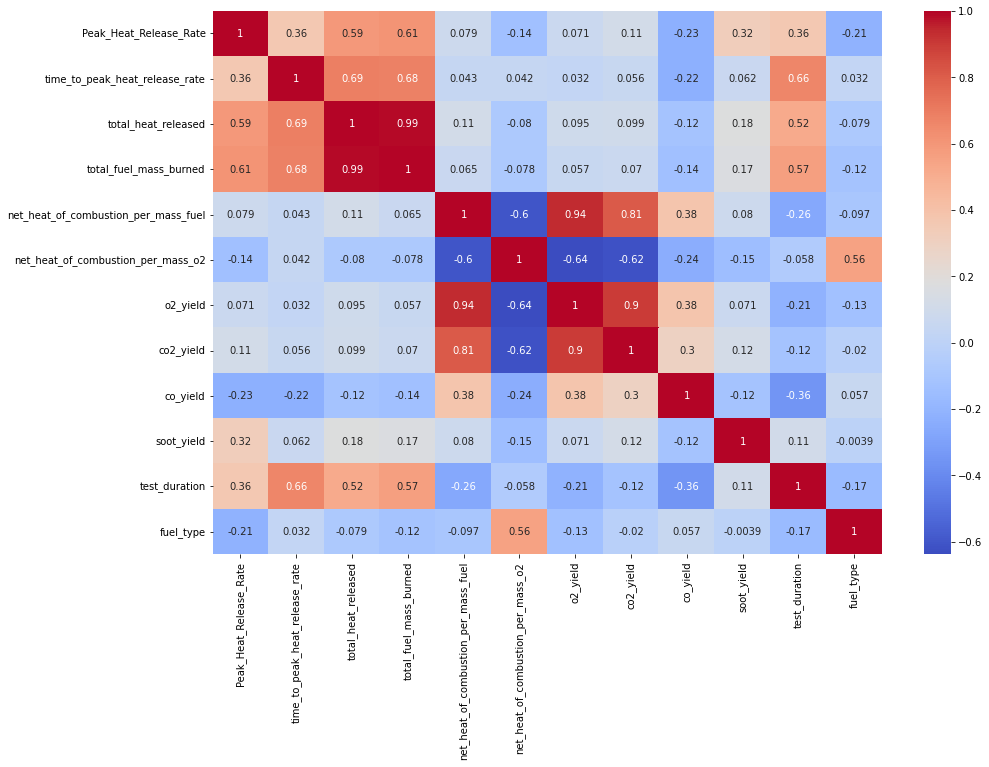

In [156]:
# Checking the Correlation Map of features and target
df_train_aug = pd.concat([xtrain_imp_aug, pd.DataFrame(ytrain_aug, columns=['fuel_type'])], axis=1)

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train_aug.corr(), cmap=col_palette, annot=True)

<font color='red'>Collinearity is a linear association between two predictors. Multicollinearity is a situation where two or more predictors are highly linearly related. In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.

Source: https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a#:~:text=Collinearity%20is%20a%20linear%20association%20between%20two%20predictors.%20Multicollinearity%20is%20a%20situation%20where%20two%20or%20more%20predictors%20are%20highly%20linearly%20related.%20In%20general%2C%20an%20absolute%20correlation%20coefficient%20of%20%3E0.7%20among%20two%20or%20more%20predictors%20indicates%20the%20presence%20of%20multicollinearity.</font>

### Dropping 'total_fuel_mass_burned', 'o2_yield' and 'co2_yield' as they are highly correlated with other features

In [157]:
xtrain_imp_aug = xtrain_imp_aug.drop(['total_fuel_mass_burned', 'o2_yield', 'co2_yield'], axis=1)
xtest_imp_aug = xtest_imp_aug.drop(['total_fuel_mass_burned', 'o2_yield', 'co2_yield'], axis=1)

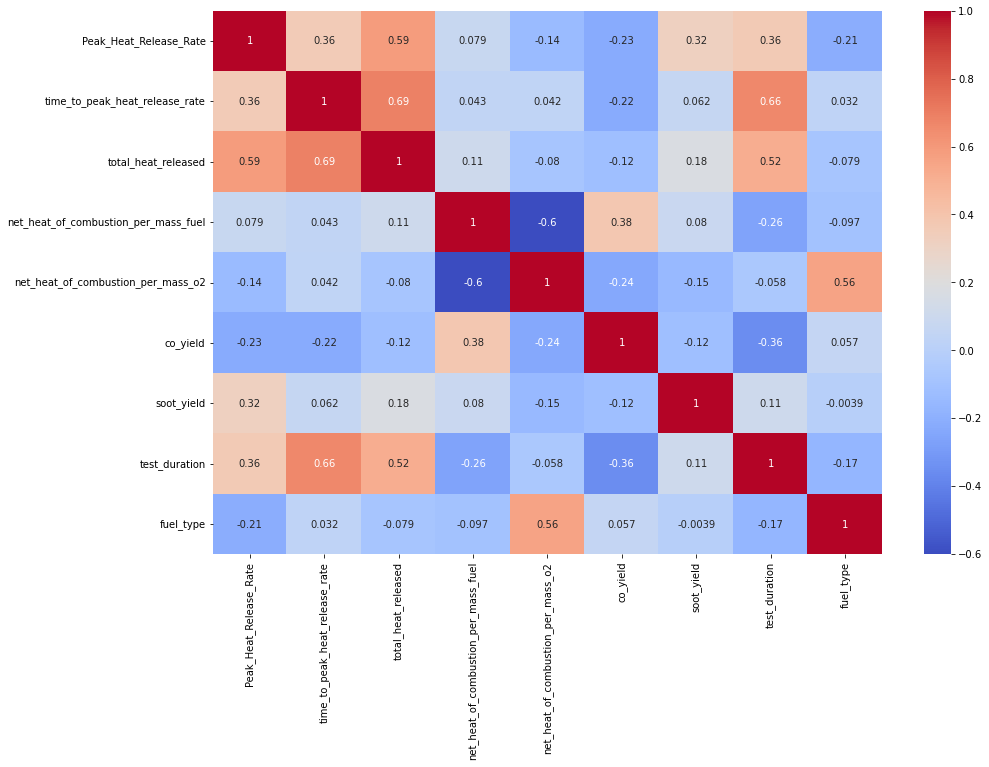

In [158]:
# Checking the Correlation Map of features and target
df_train_aug = pd.concat([xtrain_imp_aug, pd.DataFrame(ytrain_aug, columns=['fuel_type'])], axis=1)

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train_aug.corr(), cmap=col_palette, annot=True)

<Figure size 3600x3600 with 0 Axes>

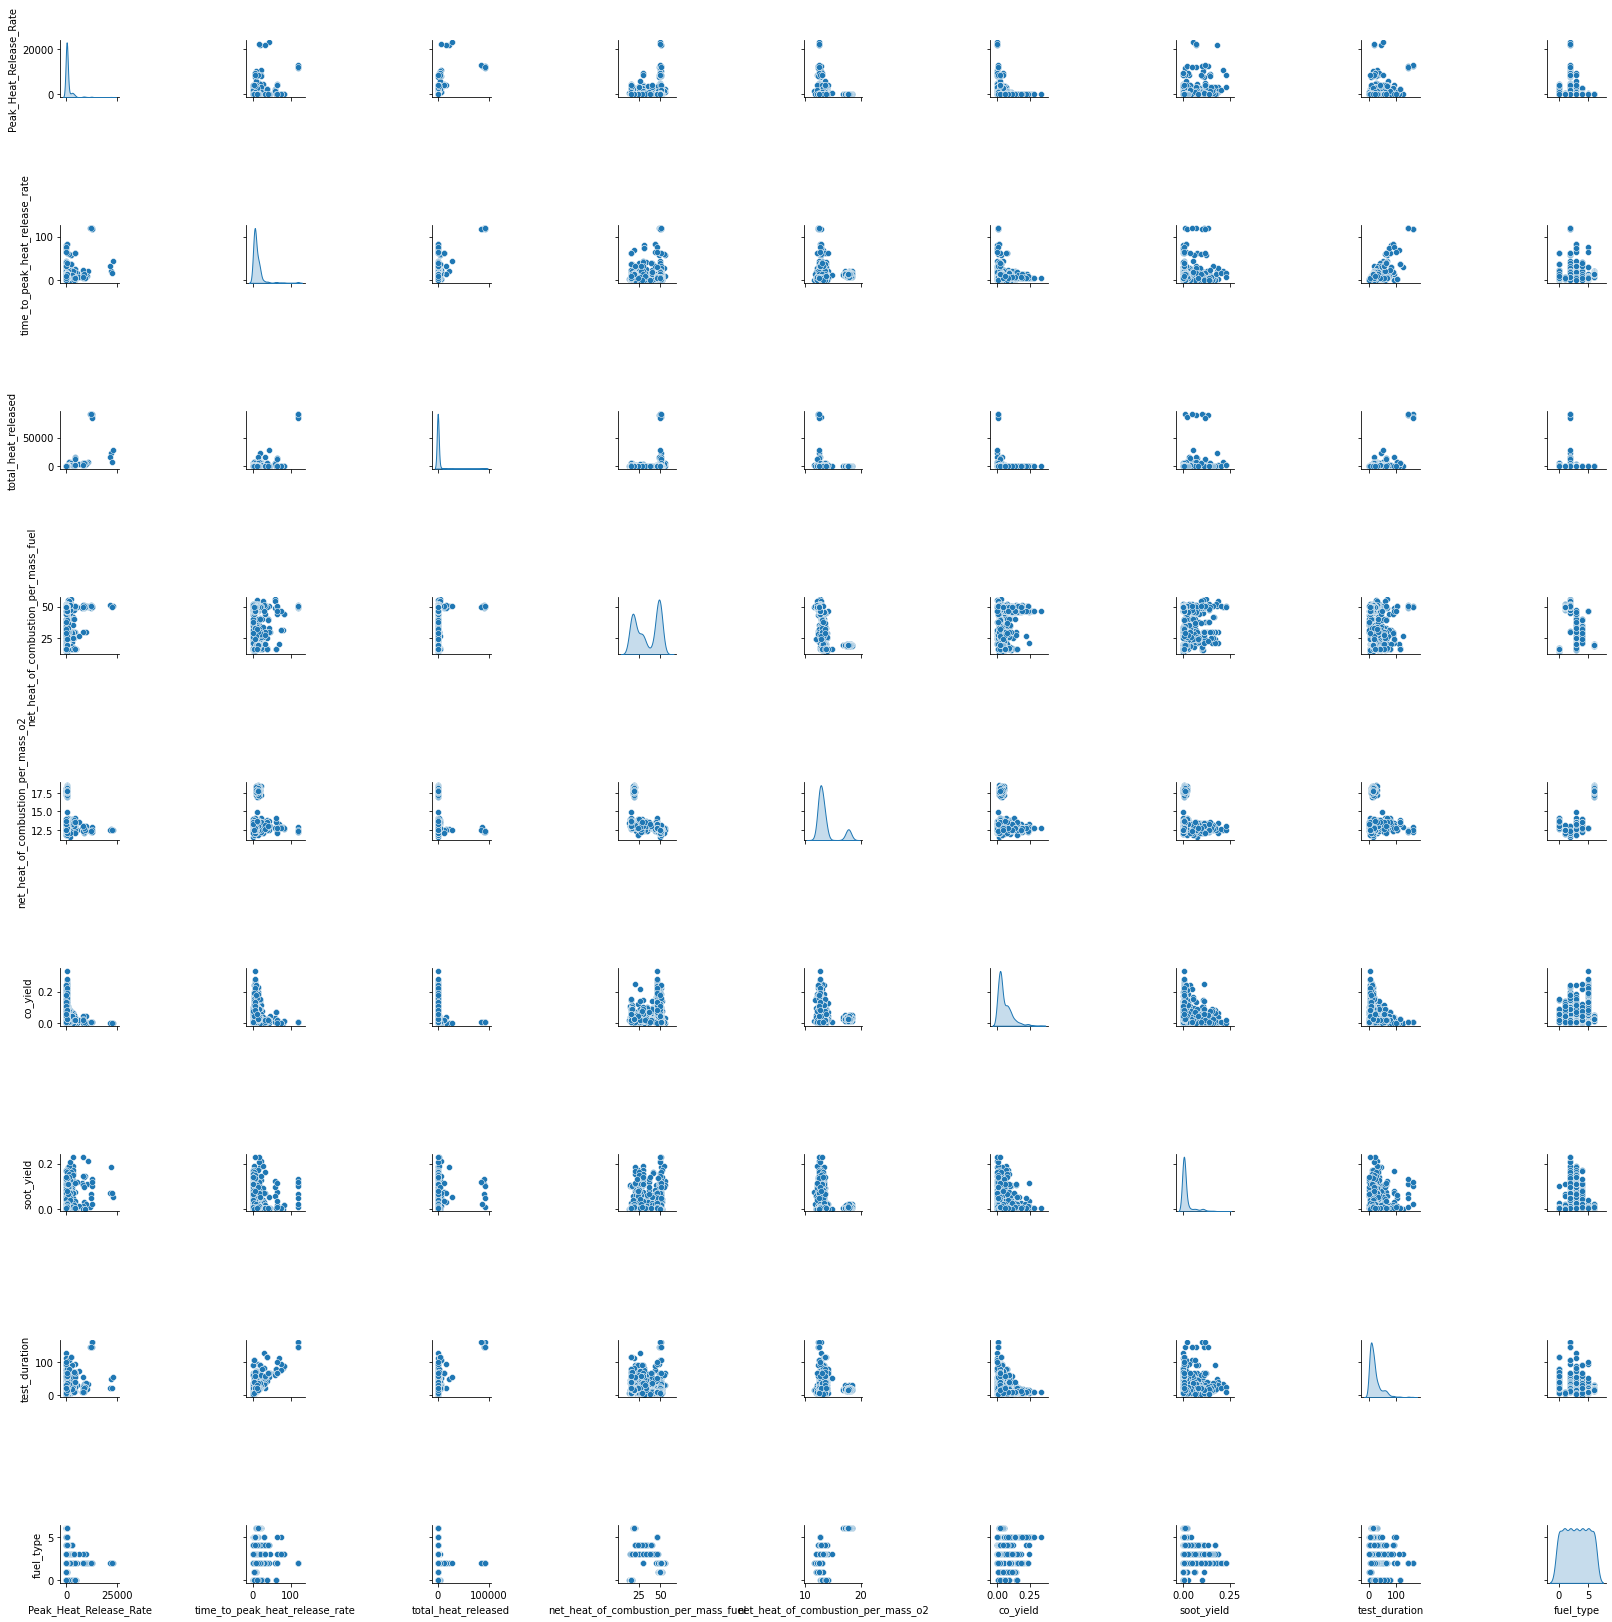

In [159]:
# Checking the relationship between different numerical features
plt.figure(figsize=(50, 50))
sns.pairplot(data=df_train_aug, vars=df_train_aug.columns.to_list(), diag_kind="kde")
plt.tight_layout()

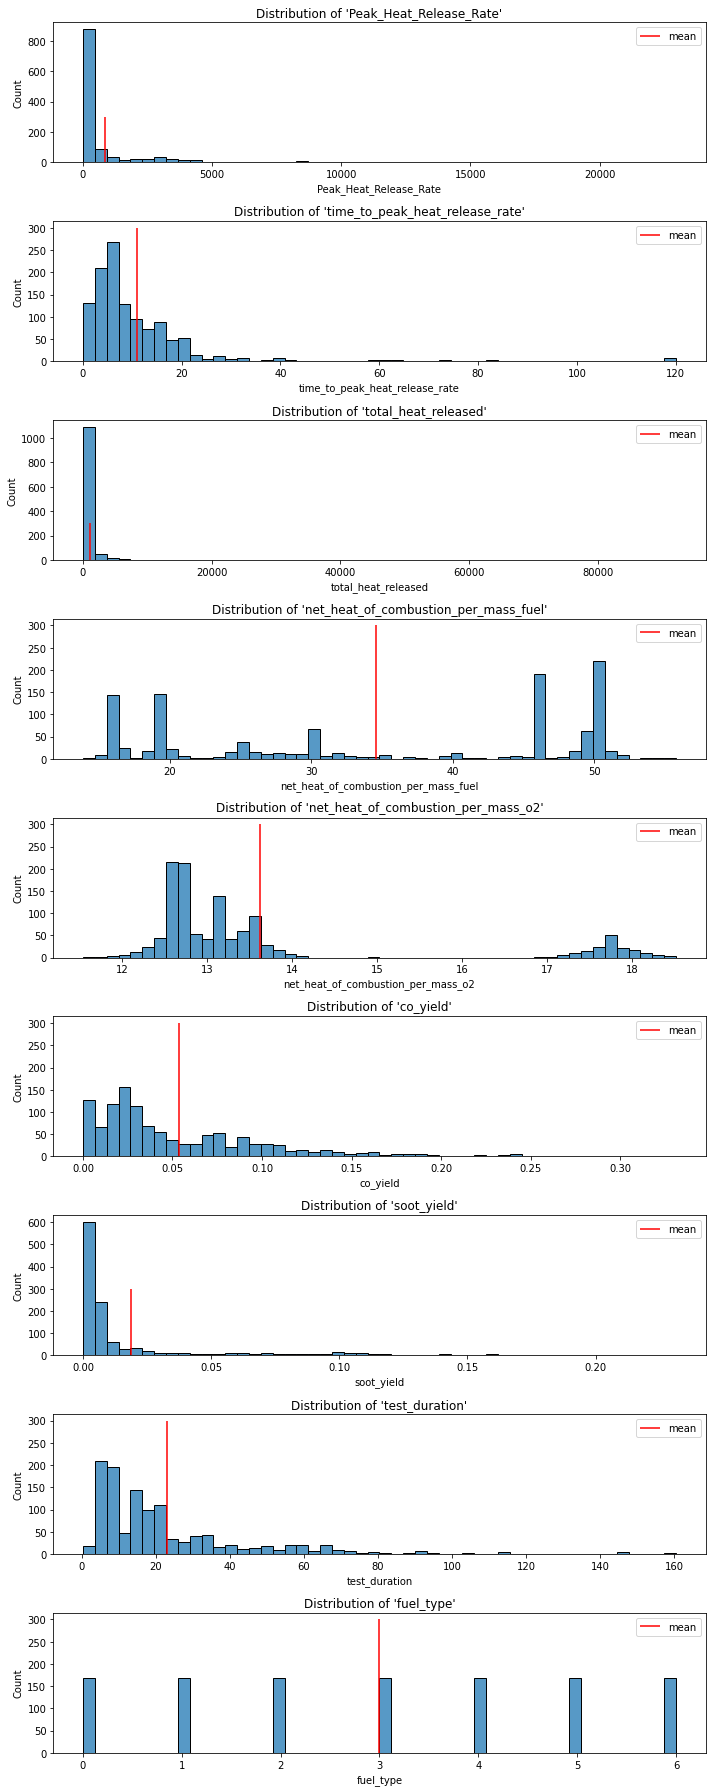

In [160]:
# Plotting distribution of features

fig, ax = plt.subplots(nrows=len(df_train_aug.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train_aug.columns):
  sns.histplot(df_train_aug[var], bins=50, ax=ax[i])
  ax[i].vlines(df_train_aug[var].mean(), ymin=0, ymax=300, colors='red', label='mean')
  ax[i].legend()
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()

In [161]:
# df_train_aug = pd.concat([xtrain_imp_aug, pd.DataFrame(ytrain_aug, columns=['fuel_type'])], axis=1)

In [162]:
# df_test_aug = pd.concat([xtest_imp_aug, pd.DataFrame(ytest_aug, columns=['fuel_type'])], axis=1)

In [163]:
# df_train_aug.to_csv(DATA_PATH+'df_train_aug.csv', index=False)
# df_test_aug.to_csv(DATA_PATH+'df_test_aug.csv', index=False)

## Standardizing Train and Test Data

In [164]:
# Standardizing all the features in the Train Data

sc_aug = StandardScaler()
xtrain_std_aug = pd.DataFrame(sc_aug.fit_transform(xtrain_imp_aug), columns=xtrain_imp_aug.columns.to_list())
df_train_std_aug = pd.concat([xtrain_std_aug, pd.DataFrame(ytrain_aug, columns=['fuel_type'])], axis=1)
df_train_std_aug.head()

Peak_Heat_Release_Rate  time_to_peak_heat_release_rate  \
0                1.084697                        0.378021   
1                1.214854                       -0.410709   
2               -0.380333                       -0.466392   
3               -0.360530                       -0.090638   
4                1.054527                       -0.091276   

   total_heat_released  net_heat_of_combustion_per_mass_fuel  \
0             0.107732                              1.086965   
1            -0.050883                             -1.352470   
2            -0.141796                              0.852110   
3            -0.133709                             -0.715846   
4            -0.011678                              1.127459   

   net_heat_of_combustion_per_mass_o2  co_yield  soot_yield  test_duration  \
0                           -0.630036 -1.051165    0.661211      -0.041406   
1                           -0.158951 -0.517149   -0.373061      -0.463215   
2                           -0.487777 -0.129305   -0.319458      -0.742631   
3                           -0.408074 -0.394811    2.236422      -0.067009   
4                           -0.418846 -1.050148   -0.514770      -0.517273   

   fuel_type  
0          2  
1          0  
2          5  
3          4  
4          2

In [165]:
# Standardizing all the features in the Test Data

xtest_std_aug = pd.DataFrame(sc_aug.transform(xtest_imp_aug), columns=xtest_imp_aug.columns.to_list())

In [166]:
# df_test_std_aug = pd.concat([xtest_std_aug, pd.DataFrame(ytest_aug, columns=['fuel_type'])], axis=1)

In [167]:
# le_aug.classes_

In [168]:
# tmp_class = pd.DataFrame(le_aug.classes_, columns=['Label_Encoded_Classes'])
# tmp_class

In [169]:
# df_train_std_aug.to_csv(DATA_PATH+'df_train_std_aug.csv', index=False)
# df_test_std_aug.to_csv(DATA_PATH+'df_test_std_aug.csv', index=False)
# tmp_class.to_csv(DATA_PATH+'label_encoded_classes_aug.csv', index=False)

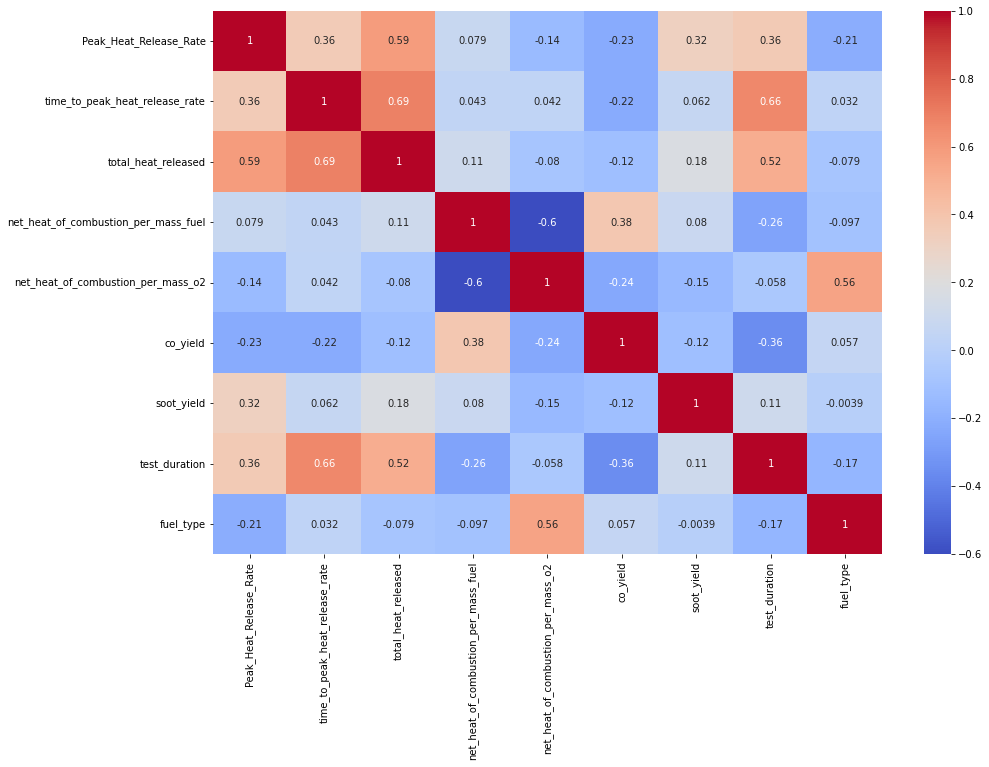

In [170]:
# Checking the Correlation Map of features and target

col_palette = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(15, 10))
sns.heatmap(df_train_std_aug.corr(), cmap=col_palette, annot=True)

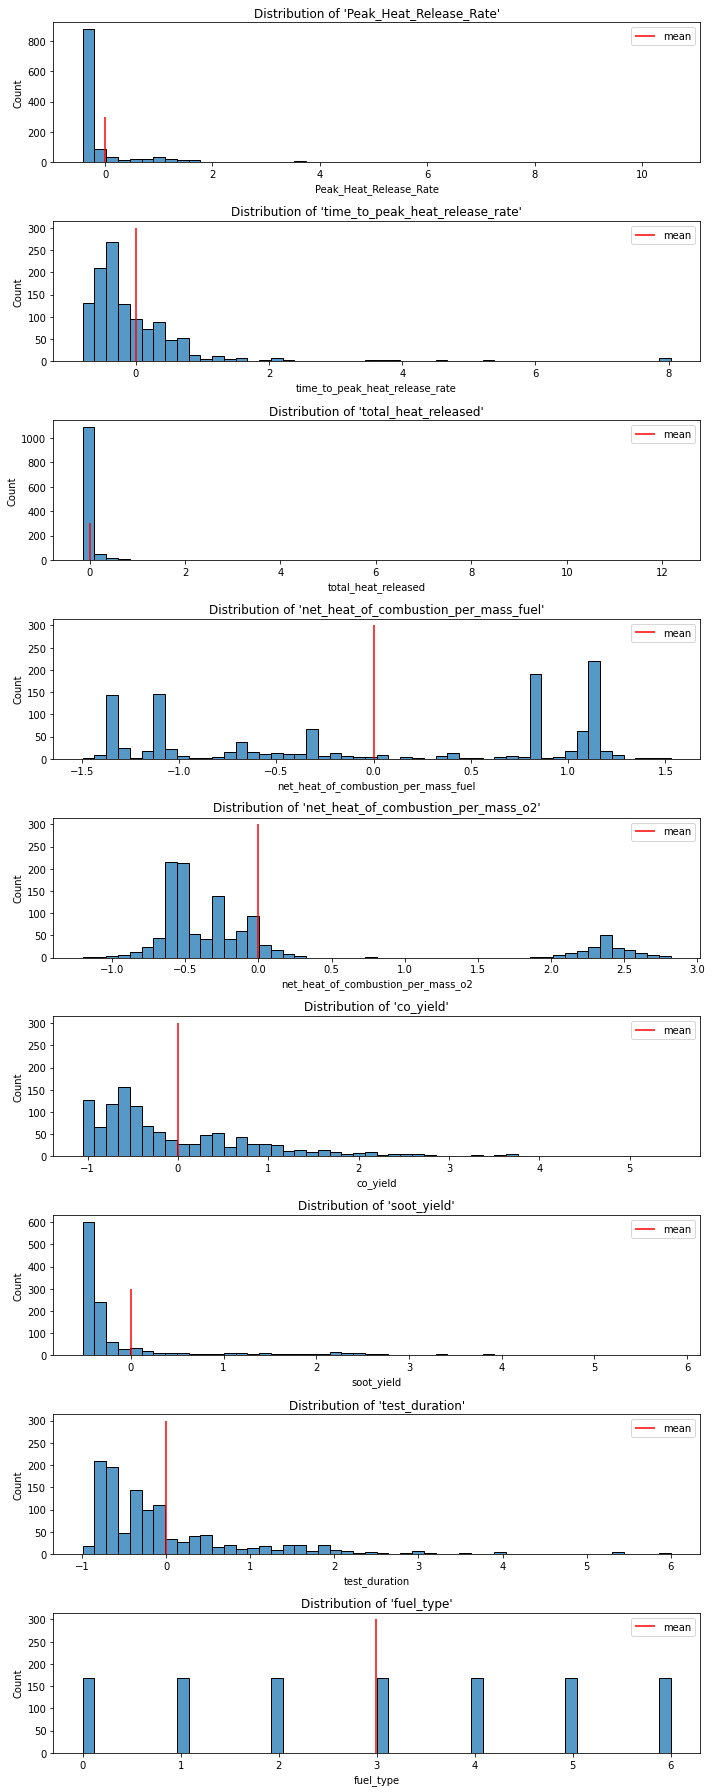

In [171]:
# Plotting distribution of features

fig, ax = plt.subplots(nrows=len(df_train_std_aug.columns), ncols=1, figsize=(10, 25))
for i, var in enumerate(df_train_std_aug.columns):
  sns.histplot(df_train_std_aug[var], bins=50, ax=ax[i])
  ax[i].vlines(df_train_std_aug[var].mean(), ymin=0, ymax=300, colors='red', label='mean')
  ax[i].legend()
  ax[i].set_title(f"Distribution of '{var}'")
plt.tight_layout()

## Helper Functions

In [172]:
# Function to get accuracy
def accuracy(X, y, model):
    return round(accuracy_score(y,model.predict(X)),2)

In [173]:
# Function to get confusion matrix
def conmatrix(X, y, model):
    return confusion_matrix(y, model.predict(X))

In [174]:
def fpr_fnr(cm):
  nrows = cm.shape[0]
  ncols = cm.shape[1]

  # True Positives
  TP = 0
  for i in range(nrows):
    TP += cm[i, i]
  
  # False Negatives
  FN = 0
  for i in range(nrows):
    FN += np.sum(cm[i, :]) - cm[i, i]
  
  # False Positives
  FP = 0
  for i in range(ncols):
    FP += np.sum(cm[:, i]) - cm[i, i]
  
  # True Negatives
  TN = 0
  tot_sum = np.sum(cm)
  for i in range(nrows):
    TN += tot_sum - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]

  fpr, fnr = round(FP/(FP+TN),3),round(FN/(FN+TP),3)

  return fpr, fnr

## Logistic Regression

In [175]:
# Build a pipeline
lr_pipeline = Pipeline([('standardizer', StandardScaler()),('lr', LogisticRegression(max_iter=1000, random_state=rs))])

In [176]:
# Hyper-parameters tuning 
lr_grid_params = [{'lr__C': np.arange(0.1,1.1,0.1)}]

In [177]:
# Fit the model
lr_grid_search = GridSearchCV(lr_pipeline, param_grid = lr_grid_params, cv=10, scoring = "accuracy")
lr_grid_search.fit(xtrain_imp_aug, ytrain_aug);

In [178]:
# Get the best parameters
print(lr_grid_search.best_estimator_.get_params())
lr_model_aug = lr_grid_search.best_estimator_

{'memory': None, 'steps': [('standardizer', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=42))], 'verbose': False, 'standardizer': StandardScaler(), 'lr': LogisticRegression(max_iter=1000, random_state=42), 'standardizer__copy': True, 'standardizer__with_mean': True, 'standardizer__with_std': True, 'lr__C': 1.0, 'lr__class_weight': None, 'lr__dual': False, 'lr__fit_intercept': True, 'lr__intercept_scaling': 1, 'lr__l1_ratio': None, 'lr__max_iter': 1000, 'lr__multi_class': 'auto', 'lr__n_jobs': None, 'lr__penalty': 'l2', 'lr__random_state': 42, 'lr__solver': 'lbfgs', 'lr__tol': 0.0001, 'lr__verbose': 0, 'lr__warm_start': False}


In [179]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_imp_aug, ytrain_aug, lr_model_aug)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp_aug, ytest_aug, lr_model_aug)}%")

Training accuracy is: 91.0%
Testing accuracy is: 89.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

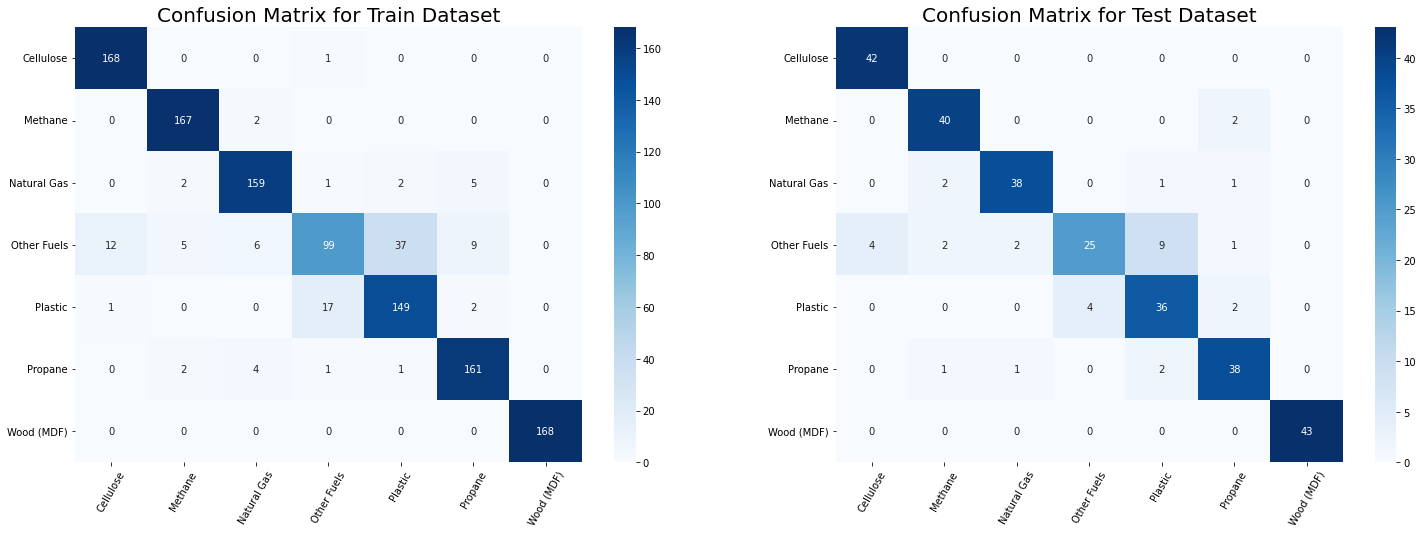

In [180]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_imp_aug, ytrain_aug, lr_model_aug)
cm_test = conmatrix(xtest_imp_aug, ytest_aug, lr_model_aug)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [181]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 1.60%
False Negative Rate for train data: 9.30%
False Positive Rate for test data: 1.90%
False Negative Rate for test data: 11.50%


## Decision Tree

In [182]:
# Find optimal depth of trees

# Number of folds for Cross-Validation
folds = 5

# make lists of different parameters to check
parameters = {
  'max_depth':list(range(1, 30))
  }

# Initializing GridSearchCV
model = GridSearchCV(DecisionTreeClassifier(random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [183]:
# Fit the model
model.fit(xtrain_imp_aug, ytrain_aug)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29]},
             return_train_score=True, scoring='accuracy')

In [184]:
# Store the average of the 5 different scores obtained in a dictionary.
# The keys in the dictionary should correspond to the max_depth and the values should correspond to the average of cross validation scores.

cross_val_acc = {}
for i, acc in enumerate(model.cv_results_['mean_test_score']):
  cross_val_acc[i+1] = acc

Text(0.5, 1.0, 'Variation of cross validation accuracy wrt max_depth')

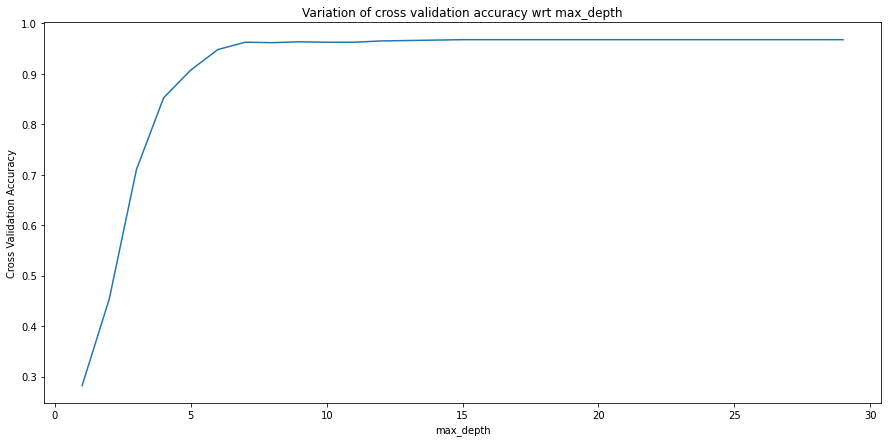

In [185]:
#Plot the variation of cross validation accuracy wrt max_depth

plt.figure(figsize=(15, 7))
sns.lineplot(x=list(cross_val_acc.keys()), y=list(cross_val_acc.values()))
plt.xlabel("max_depth")
plt.ylabel("Cross Validation Accuracy")
plt.title("Variation of cross validation accuracy wrt max_depth")

In [186]:
# Find the best depth

best_depth = model.best_params_['max_depth']
print(f"\033[1;91m The Best Parameter is: {model.best_params_}")

 The Best Parameter is: {'max_depth': 15}


In [187]:
# Fit a new model with best depth found above

dtree_aug = DecisionTreeClassifier(max_depth=best_depth, random_state=rs)
dtree_aug.fit(xtrain_imp_aug, ytrain_aug)

DecisionTreeClassifier(max_depth=15, random_state=42)

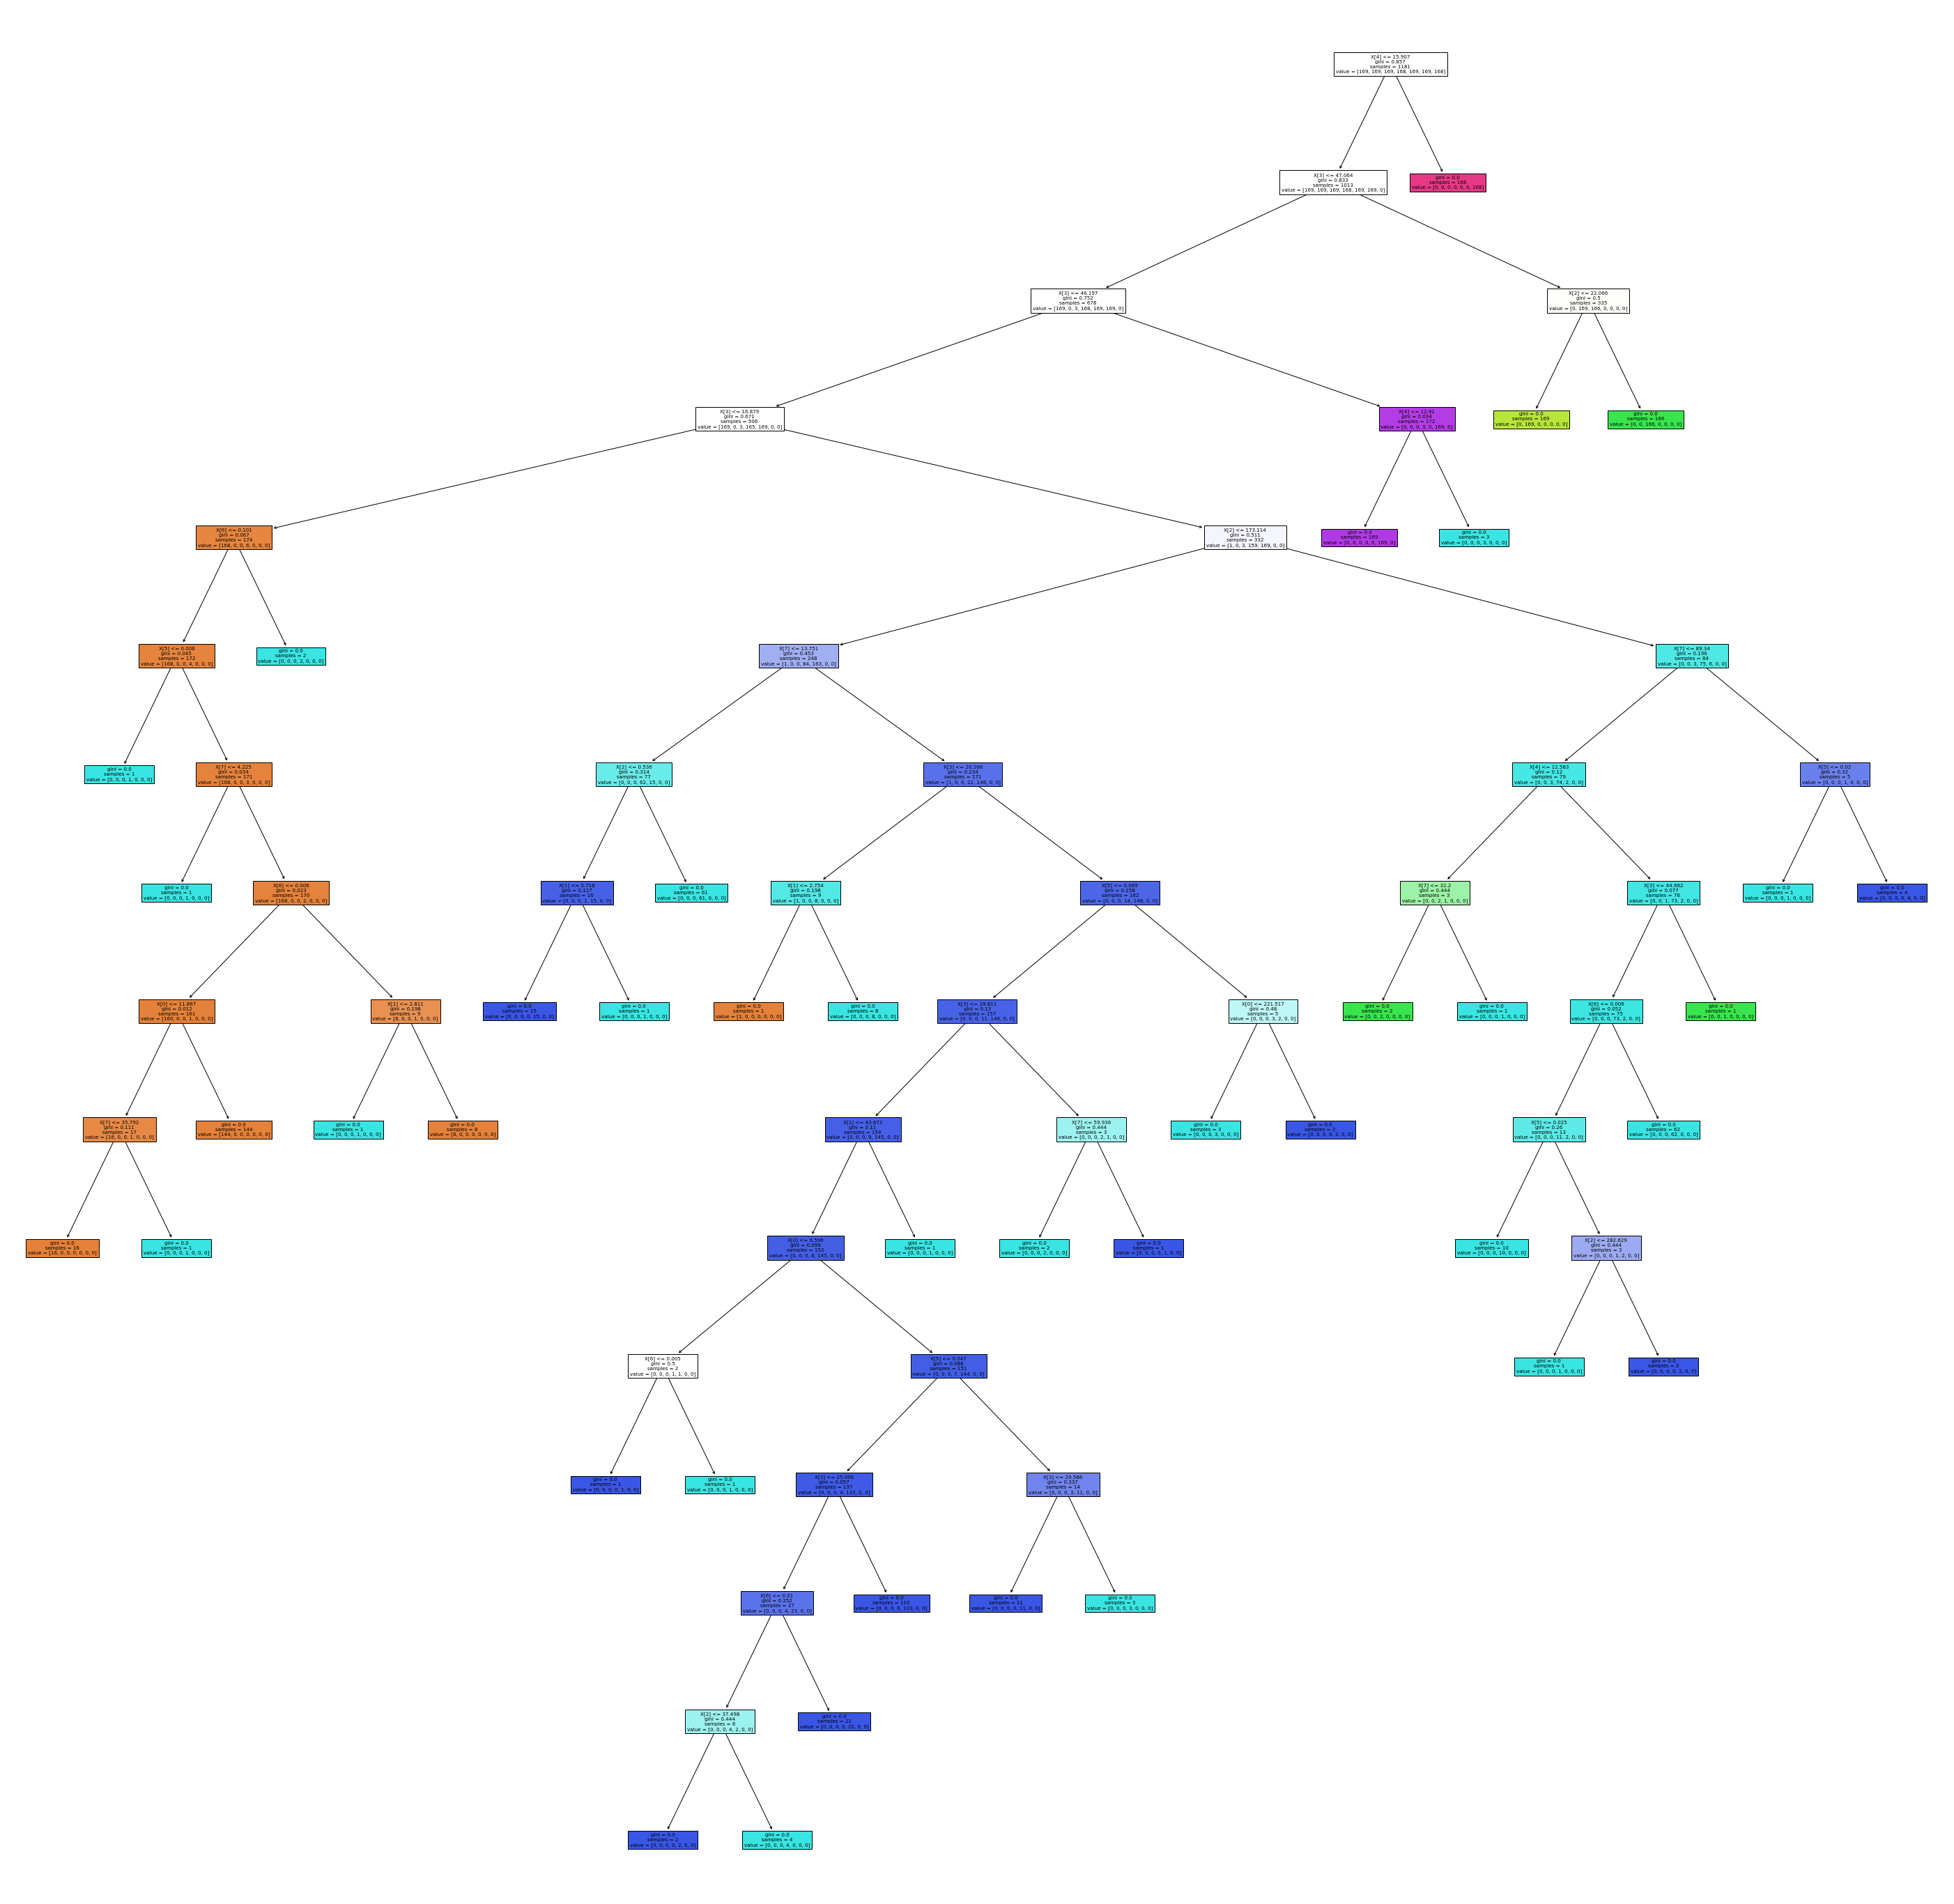

In [188]:
# Plot the tree

plt.figure(figsize=(50,50))

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(dtree_aug, filled=True)

plt.show();

In [189]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_imp_aug, ytrain_aug, dtree_aug)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp_aug, ytest_aug, dtree_aug)}%")

Training accuracy is: 100.0%
Testing accuracy is: 97.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

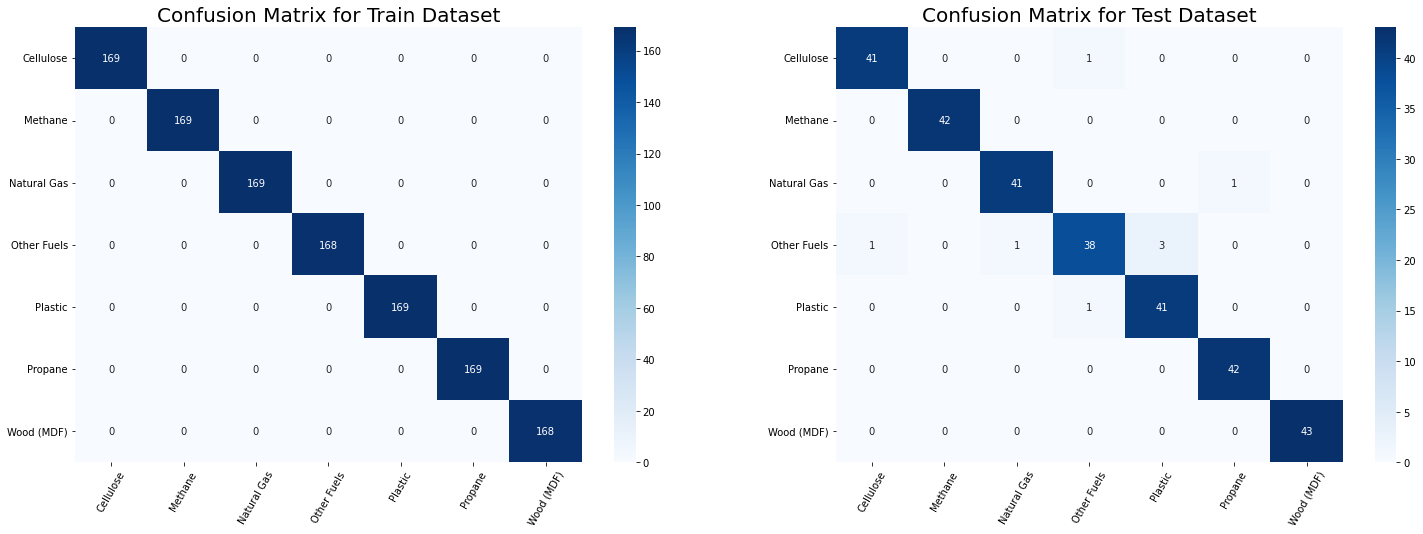

In [190]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_imp_aug, ytrain_aug, dtree_aug)
cm_test = conmatrix(xtest_imp_aug, ytest_aug, dtree_aug)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [191]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.00%
False Negative Rate for train data: 0.00%
False Positive Rate for test data: 0.50%
False Negative Rate for test data: 2.70%


## Bagging Classifier

In [192]:
# bagging_parameters

# Number of folds for Cross-Validation
folds = 5

# make lists of different parameters to check
parameters = {
  'n_estimators':list(range(1, 51))
  }

# Initializing GridSearchCV
model = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=rs), random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [193]:
# Fit the model
model.fit(xtrain_imp_aug, ytrain_aug)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                         random_state=42),
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             return_train_score=True, scoring='accuracy')

In [194]:
# Print the best parameters

best_n_estimators = model.best_params_['n_estimators']
print(f"\033[1;91m The Best Parameter is: {model.best_params_}")

 The Best Parameter is: {'n_estimators': 47}


In [195]:
# Fit a new model with best_n_estimators found above

bagging_clf_aug = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=rs), n_estimators=best_n_estimators, random_state=rs)
bagging_clf_aug.fit(xtrain_imp_aug, ytrain_aug)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=47, random_state=42)

In [196]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_imp_aug, ytrain_aug, bagging_clf_aug)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp_aug, ytest_aug, bagging_clf_aug)}%")

Training accuracy is: 100.0%
Testing accuracy is: 96.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

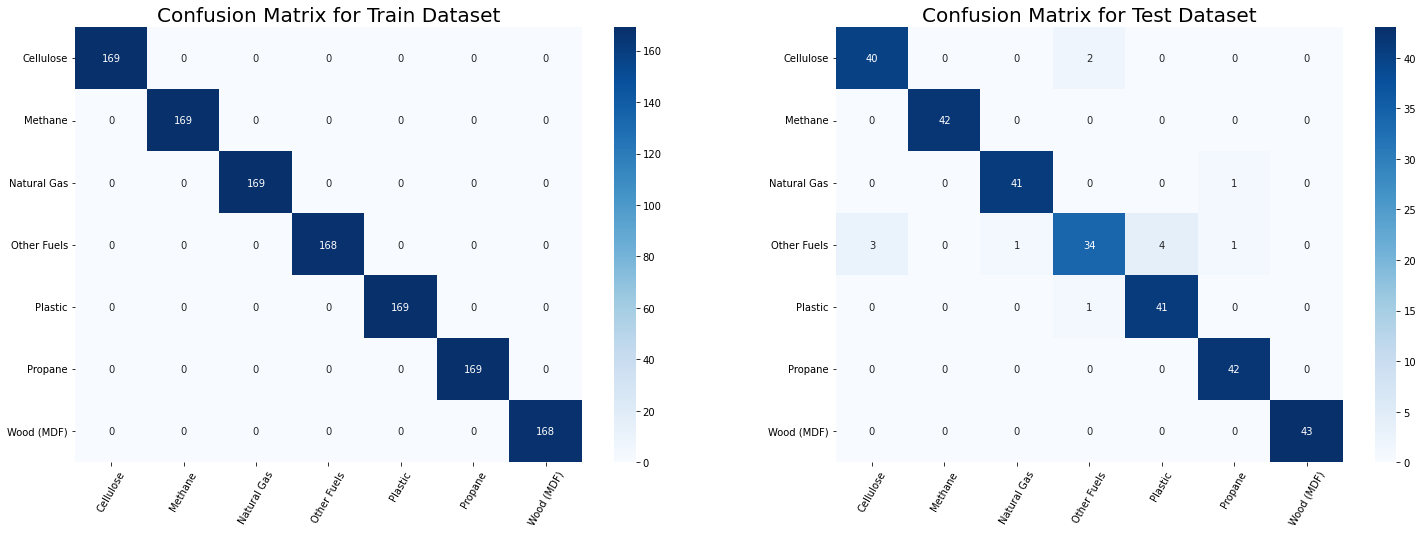

In [197]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_imp_aug, ytrain_aug, bagging_clf_aug)
cm_test = conmatrix(xtest_imp_aug, ytest_aug, bagging_clf_aug)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [198]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.00%
False Negative Rate for train data: 0.00%
False Positive Rate for test data: 0.70%
False Negative Rate for test data: 4.40%


Text(0.5, 1.0, 'Permutation Feature Importances for BaggingClassifier')

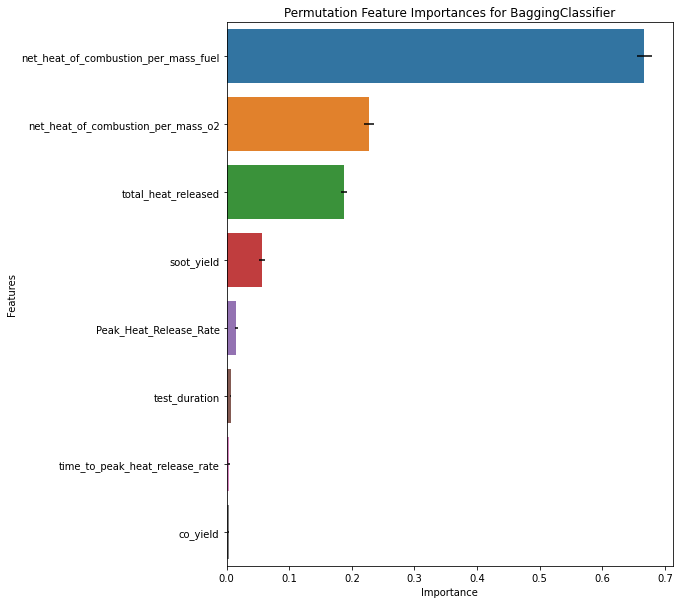

In [199]:
# Bagging importance

# Use Permutation Importance to get the importance of features for the BaggingClassifier model trained above
bagging_result_aug = permutation_importance(bagging_clf_aug, xtrain_imp_aug, ytrain_aug, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(bagging_result_aug['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_imp_aug.columns[idx], x=bagging_result_aug['importances_mean'][idx], xerr=bagging_result_aug['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for BaggingClassifier")

## Random Forest

In [200]:
param_dict = OrderedDict(n_estimators = [10, 20, 30, 40, 50, 100, 150, 200, 250], max_features = (range(2, xtrain_res.columns.shape[0])), max_depth=(range(2,10)))

In [201]:
# Calculating all possible combinations of param_dict
params_comb = product(param_dict['n_estimators'], param_dict['max_features'], param_dict['max_depth'])

In [202]:
# Fit the model for all possible combinations of param_dict

oob_error_dict = {}

for param in params_comb:
  rf = RandomForestClassifier(n_estimators=param[0], max_features=param[1], max_depth=param[2], random_state=rs, oob_score=True)
  rf.fit(xtrain_res, ytrain_res)
  oob_error_dict[param] = 1-rf.oob_score_

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probabl

In [203]:
# rf_best_params 

min_oob_error = min(oob_error_dict.values())
best_param = [key for key, val in oob_error_dict.items() if val == min_oob_error]
best_n_estimators = best_param[0][0]
best_max_features = best_param[0][1]
best_max_depth = best_param[0][2]

print(f"\033[1;91m The Best Parameters are: 'n_estimators'={best_n_estimators}, 'max_features'={best_max_features}, 'max_depth'={best_max_depth}")

 The Best Parameters are: 'n_estimators'=50, 'max_features'=4, 'max_depth'=9


In [204]:
# Fit new model

rf_tuned_aug = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features, max_depth=best_max_depth, random_state=rs, oob_score=True)
rf_tuned_aug.fit(xtrain_imp_aug, ytrain_aug)

RandomForestClassifier(max_depth=9, max_features=4, n_estimators=50,
                       oob_score=True, random_state=42)

In [205]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_imp_aug, ytrain_aug, rf_tuned_aug)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp_aug, ytest_aug, rf_tuned_aug)}%")

Training accuracy is: 99.0%
Testing accuracy is: 98.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

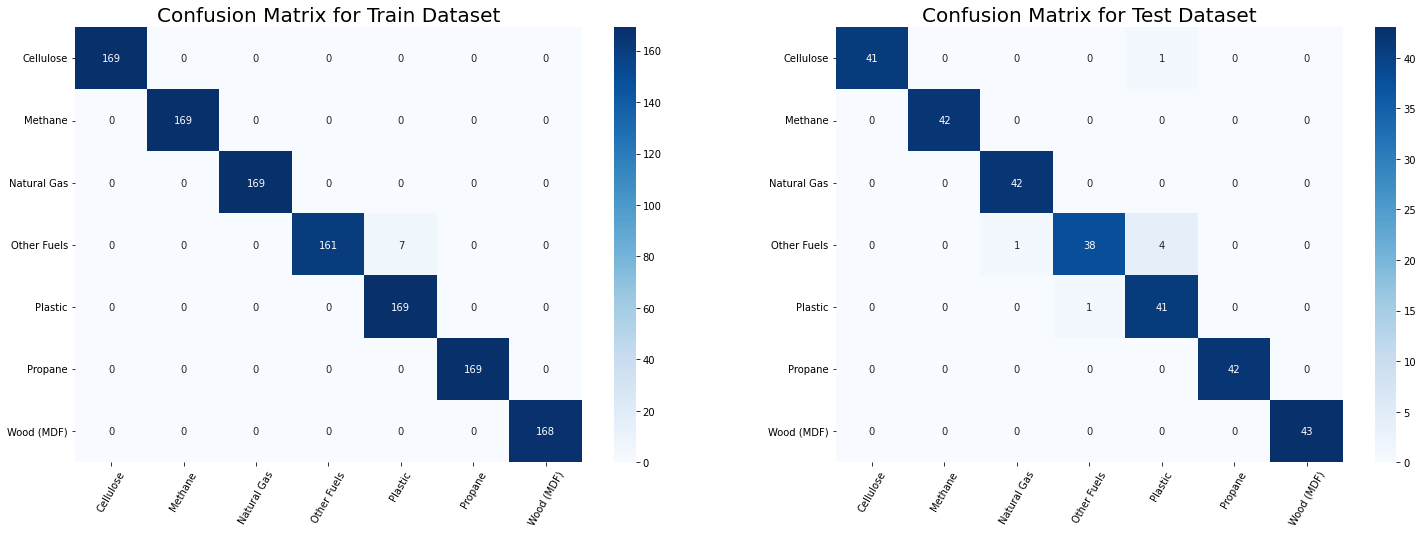

In [206]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_imp_aug, ytrain_aug, rf_tuned_aug)
cm_test = conmatrix(xtest_imp_aug, ytest_aug, rf_tuned_aug)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [207]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 0.10%
False Negative Rate for train data: 0.60%
False Positive Rate for test data: 0.40%
False Negative Rate for test data: 2.40%


Text(0.5, 1.0, 'Permutation Feature Importances for RandomForestClassifier')

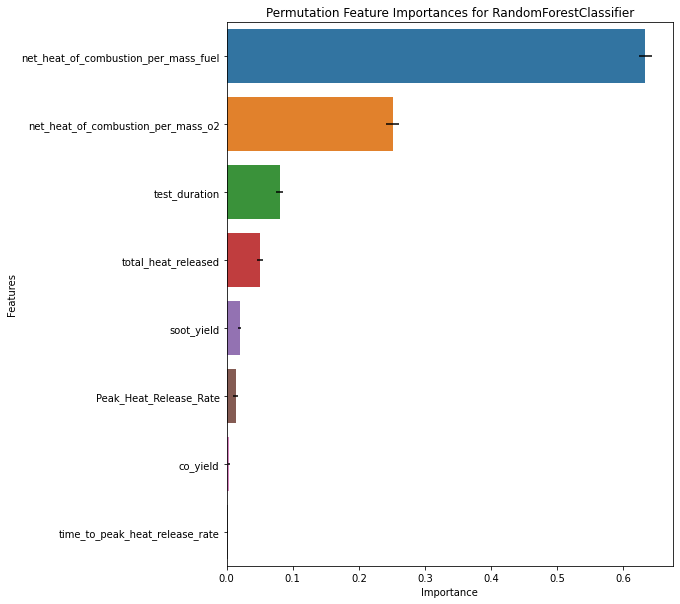

In [208]:
# RF importance 

# Use Permutation Importance to get the importance of features for the RandomForestClassifier model trained above
rf_result_aug = permutation_importance(rf_tuned_aug, xtrain_imp_aug, ytrain_aug, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(rf_result_aug['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_imp_aug.columns[idx], x=rf_result_aug['importances_mean'][idx], xerr=rf_result_aug['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for RandomForestClassifier")

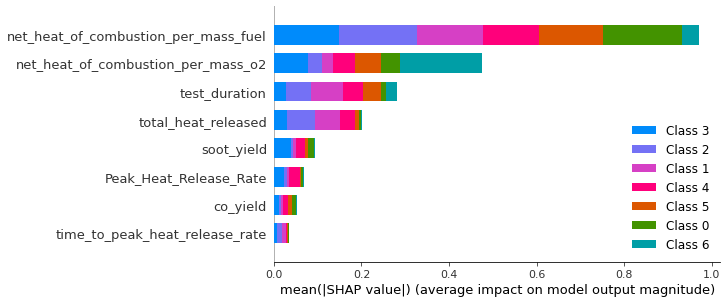

In [209]:
# Feature Importance Using Shapley Values
explainer = shap.TreeExplainer(rf_tuned_aug)
shap_values = explainer.shap_values(xtrain_imp_aug)
shap.summary_plot(shap_values, xtrain_imp_aug, plot_type="bar")

## AdaBoost Classifier

In [210]:
#Build an adaboost model 

# Number of folds for Cross-Validation
folds = 10

# make lists of different parameters to check
parameters = {
  'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200, 250],
  'learning_rate': [0.001, 0.01, 0.05, 0.07, 0.09, 0.1, 0.5, 1, 5, 10]
  }

# Initializing GridSearchCV
model = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=rs), random_state=rs), param_grid=parameters, cv=folds, scoring='accuracy', return_train_score=True)

In [211]:
# Fit the model
model.fit(xtrain_imp_aug, ytrain_aug)

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                random_state=42),
                                          random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.07, 0.09, 0.1,
                                           0.5, 1, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200,
                                          250]},
             return_train_score=True, scoring='accuracy')

In [212]:
# Print the best parameters

best_n_estimators = model.best_params_['n_estimators']
best_learning_rate = model.best_params_['learning_rate']
print(f"\033[1;91m The Best Parameters are: {model.best_params_}")

 The Best Parameters are: {'learning_rate': 5, 'n_estimators': 250}


In [213]:
# Fit a new model with best_n_estimators and best_learning_rate found above

adaboost_clf_aug = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=rs), n_estimators=best_n_estimators, learning_rate=best_learning_rate, random_state=rs)
adaboost_clf_aug.fit(xtrain_imp_aug, ytrain_aug)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=42),
                   learning_rate=5, n_estimators=250, random_state=42)

In [214]:
# Checking accuracy

print(f"Training accuracy is: {100*accuracy(xtrain_imp_aug, ytrain_aug, adaboost_clf_aug)}%")
print(f"Testing accuracy is: {100*accuracy(xtest_imp_aug, ytest_aug, adaboost_clf_aug)}%")

Training accuracy is: 90.0%
Testing accuracy is: 91.0%


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

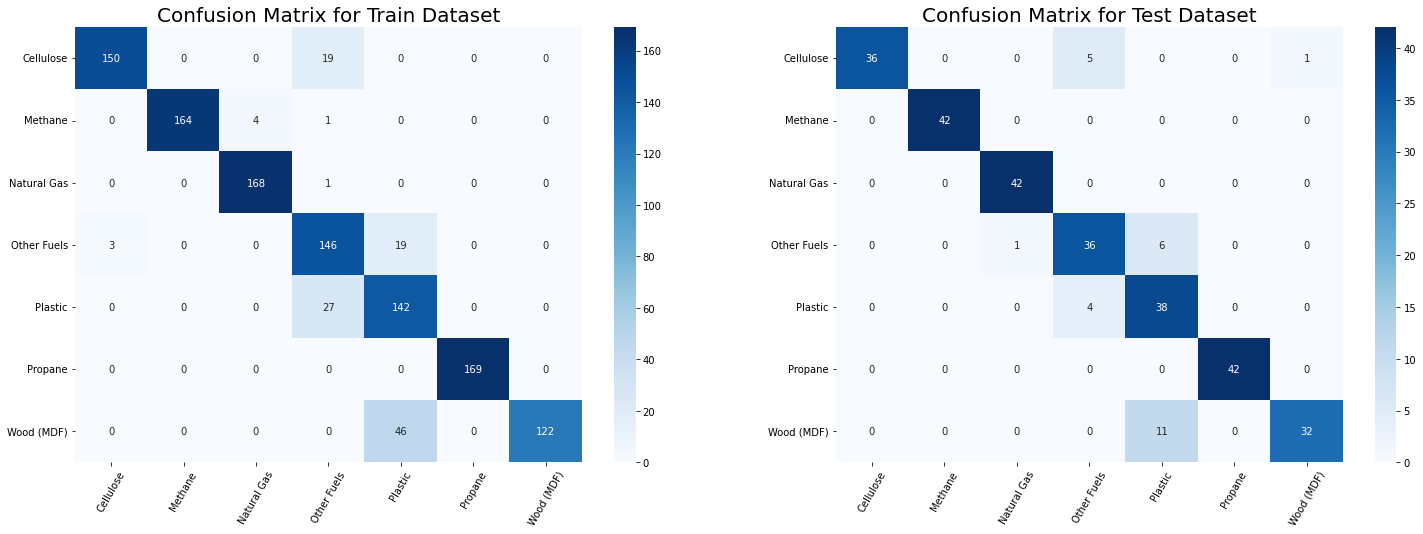

In [215]:
#plot the confusion matrix
cm_train = conmatrix(xtrain_imp_aug, ytrain_aug, adaboost_clf_aug)
cm_test = conmatrix(xtest_imp_aug, ytest_aug, adaboost_clf_aug)

fig, ax= plt.subplots(1,2, figsize=(25,8))
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap='Blues'); 
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1],cmap='Blues'); 

ax[0].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[0].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[0].set_title("Confusion Matrix for Train Dataset", fontdict={'fontsize': 20})

ax[1].xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
ax[1].yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
ax[1].set_title("Confusion Matrix for Test Dataset", fontdict={'fontsize': 20})

In [216]:
fpr_train, fnr_train = fpr_fnr(cm_train)
fpr_test, fnr_test = fpr_fnr(cm_test)

print(f'False Positive Rate for train data: {100*fpr_train:.2f}%')
print(f'False Negative Rate for train data: {100*fnr_train:.2f}%')

print(f'False Positive Rate for test data: {100*fpr_test:.2f}%')
print(f'False Negative Rate for test data: {100*fnr_test:.2f}%')

False Positive Rate for train data: 1.70%
False Negative Rate for train data: 10.20%
False Positive Rate for test data: 1.60%
False Negative Rate for test data: 9.50%


Text(0.5, 1.0, 'Permutation Feature Importances for AdaBoostClassifier')

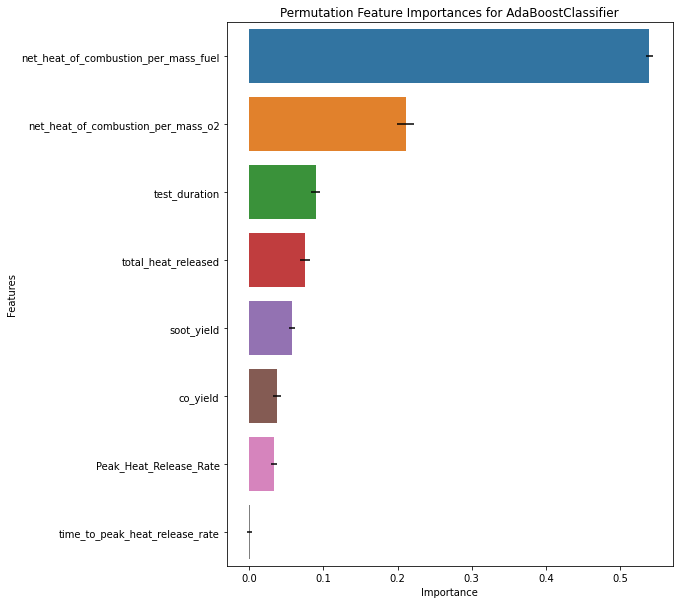

In [217]:
# AdaBoost importance 

# Use Permutation Importance to get the importance of features for the AdaBoostClassifier model trained above
adaboost_result_aug = permutation_importance(adaboost_clf_aug, xtrain_imp_aug, ytrain_aug, scoring='accuracy', n_repeats=10, random_state=rs)

idx = np.argsort(adaboost_result_aug['importances_mean'])[-1::-1]
plt.figure(figsize=(8, 10))
sns.barplot(y=xtrain_imp_aug.columns[idx], x=adaboost_result_aug['importances_mean'][idx], xerr=adaboost_result_aug['importances_std'][idx], orient='h')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importances for AdaBoostClassifier")

## Comparing All Models

### Plot the train and test accuracies as a bar plot along with the confusion matrix for all 5 models.

Text(0.5, 1.0, 'Comparison of Train and Test Accuracy Performance of All Models on Augmented Dataset')

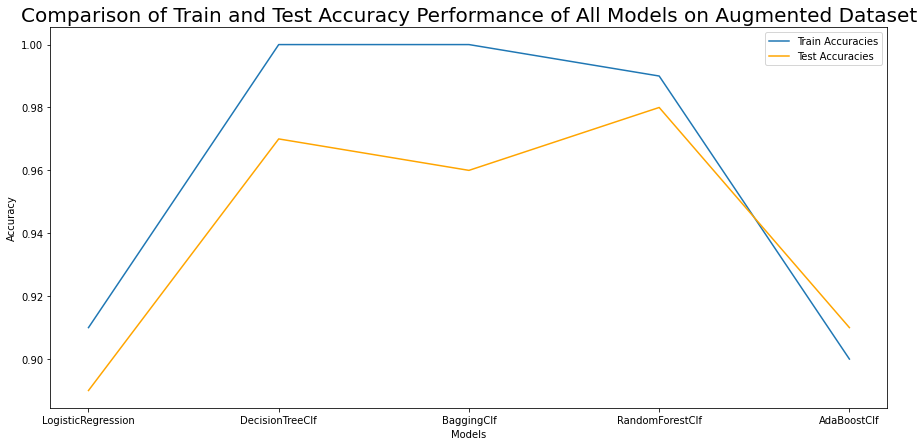

In [218]:
# Comparing test accuracy performance of all models

model_names = ['LogisticRegression', 'DecisionTreeClf', 'BaggingClf', 'RandomForestClf', 'AdaBoostClf']
model_objects = [lr_model_aug, dtree_aug, bagging_clf_aug, rf_tuned_aug, adaboost_clf_aug]
train_acc = [accuracy(xtrain_imp_aug, ytrain_aug, lr_model_aug), accuracy(xtrain_imp_aug, ytrain_aug, dtree_aug), accuracy(xtrain_imp_aug, ytrain_aug, bagging_clf_aug), accuracy(xtrain_imp_aug, ytrain_aug, rf_tuned_aug), accuracy(xtrain_imp_aug, ytrain_aug, adaboost_clf_aug)]
test_acc = [accuracy(xtest_imp_aug, ytest_aug, lr_model_aug), accuracy(xtest_imp_aug, ytest_aug, dtree_aug), accuracy(xtest_imp_aug, ytest_aug, bagging_clf_aug), accuracy(xtest_imp_aug, ytest_aug, rf_tuned_aug), accuracy(xtest_imp_aug, ytest_aug, adaboost_clf_aug)]

plt.figure(figsize=(15, 7))
plt.plot(model_names, train_acc, label='Train Accuracies')
plt.plot(model_names, test_acc, color='orange', label='Test Accuracies')
plt.legend()
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title("Comparison of Train and Test Accuracy Performance of All Models on Augmented Dataset", fontdict={'fontsize': 20})

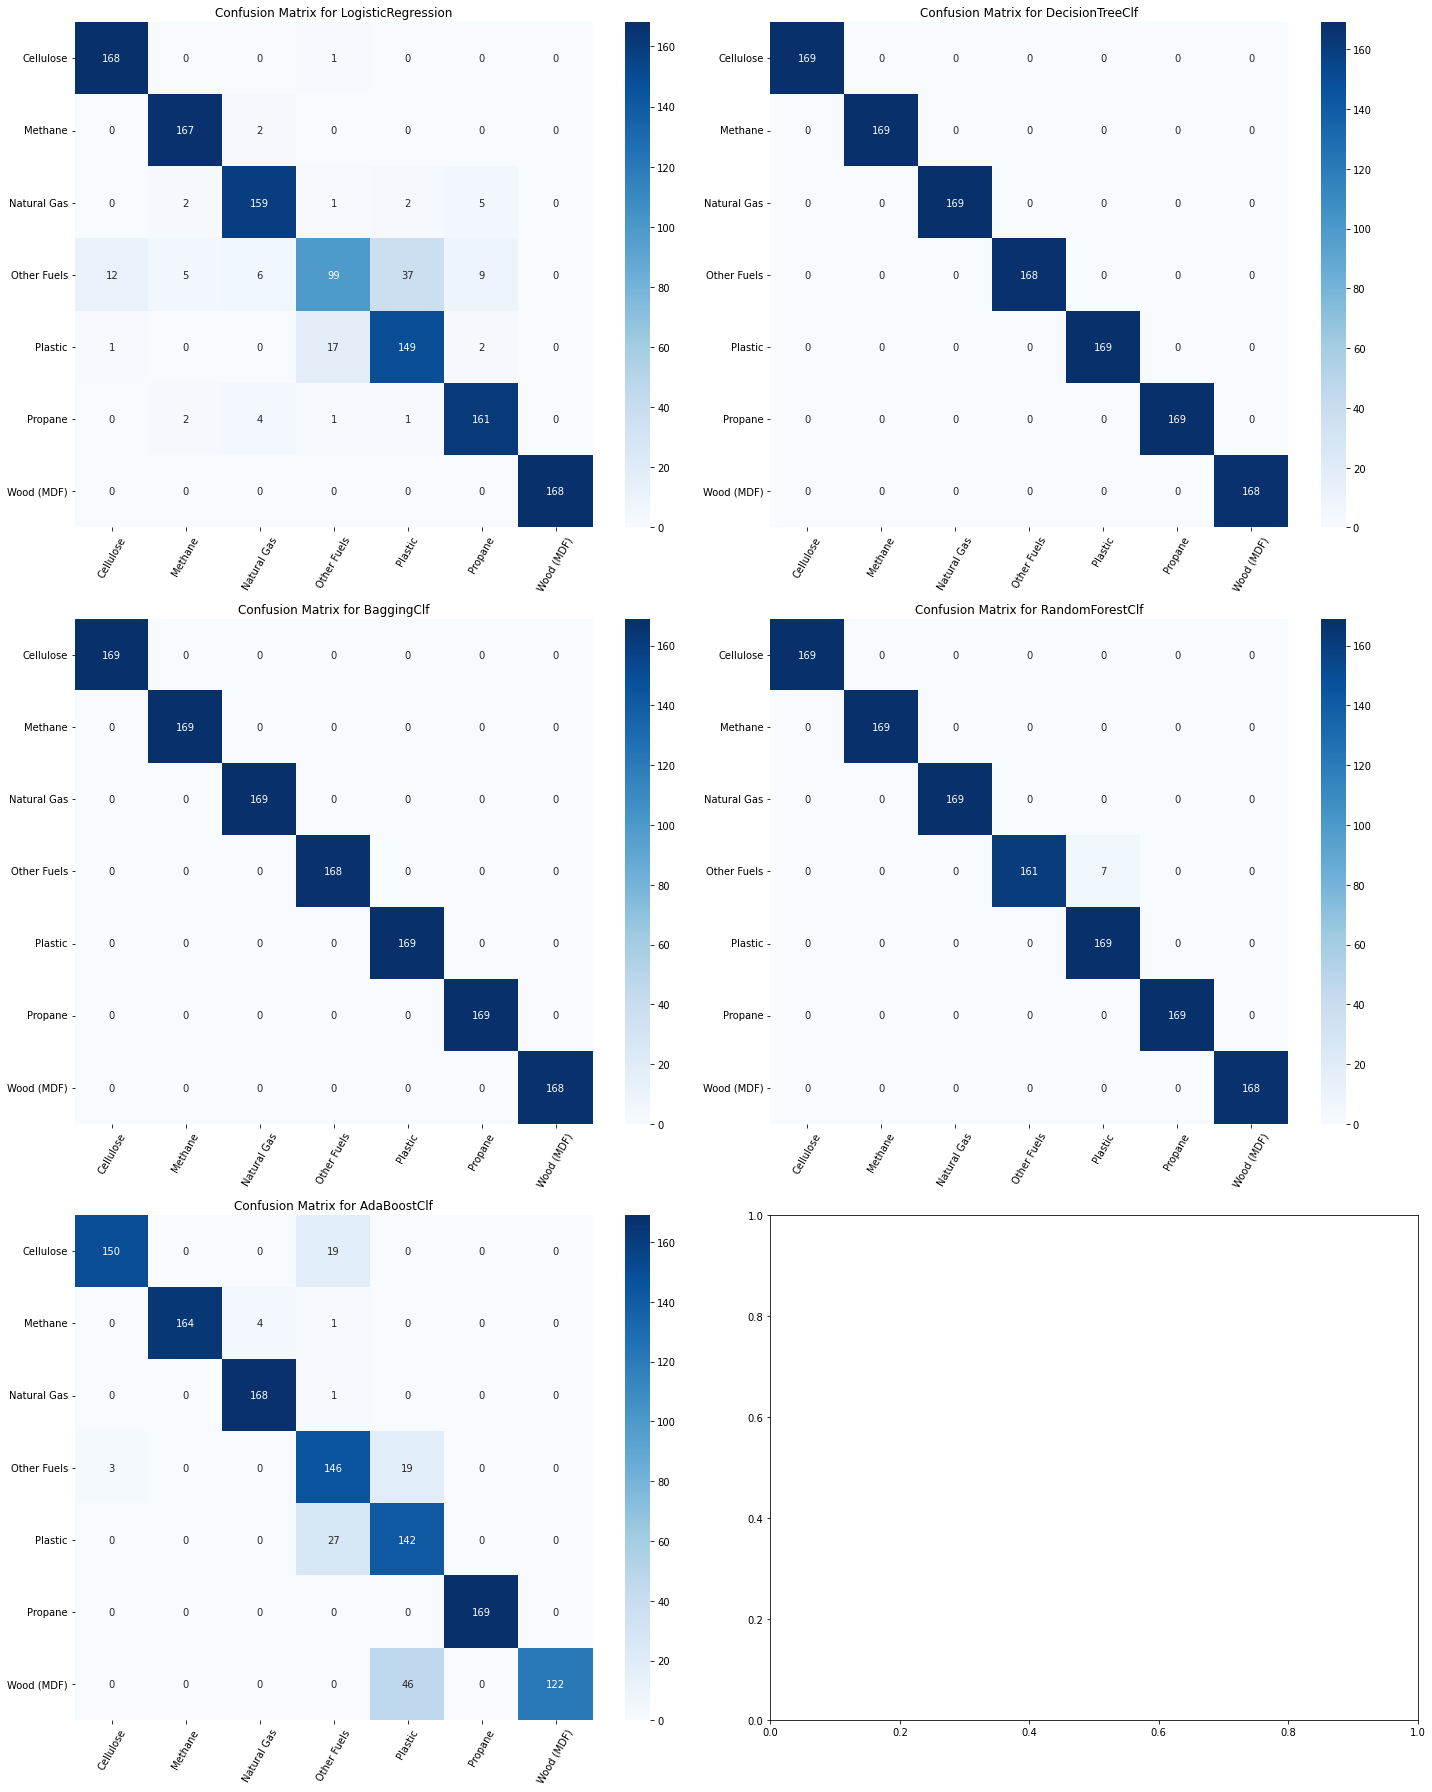

In [219]:
# Comparing train confusion matrix performance of all models

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    sns.heatmap(conmatrix(xtrain_imp_aug, ytrain_aug, model_objects[i]), annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
    ax.yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
    ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

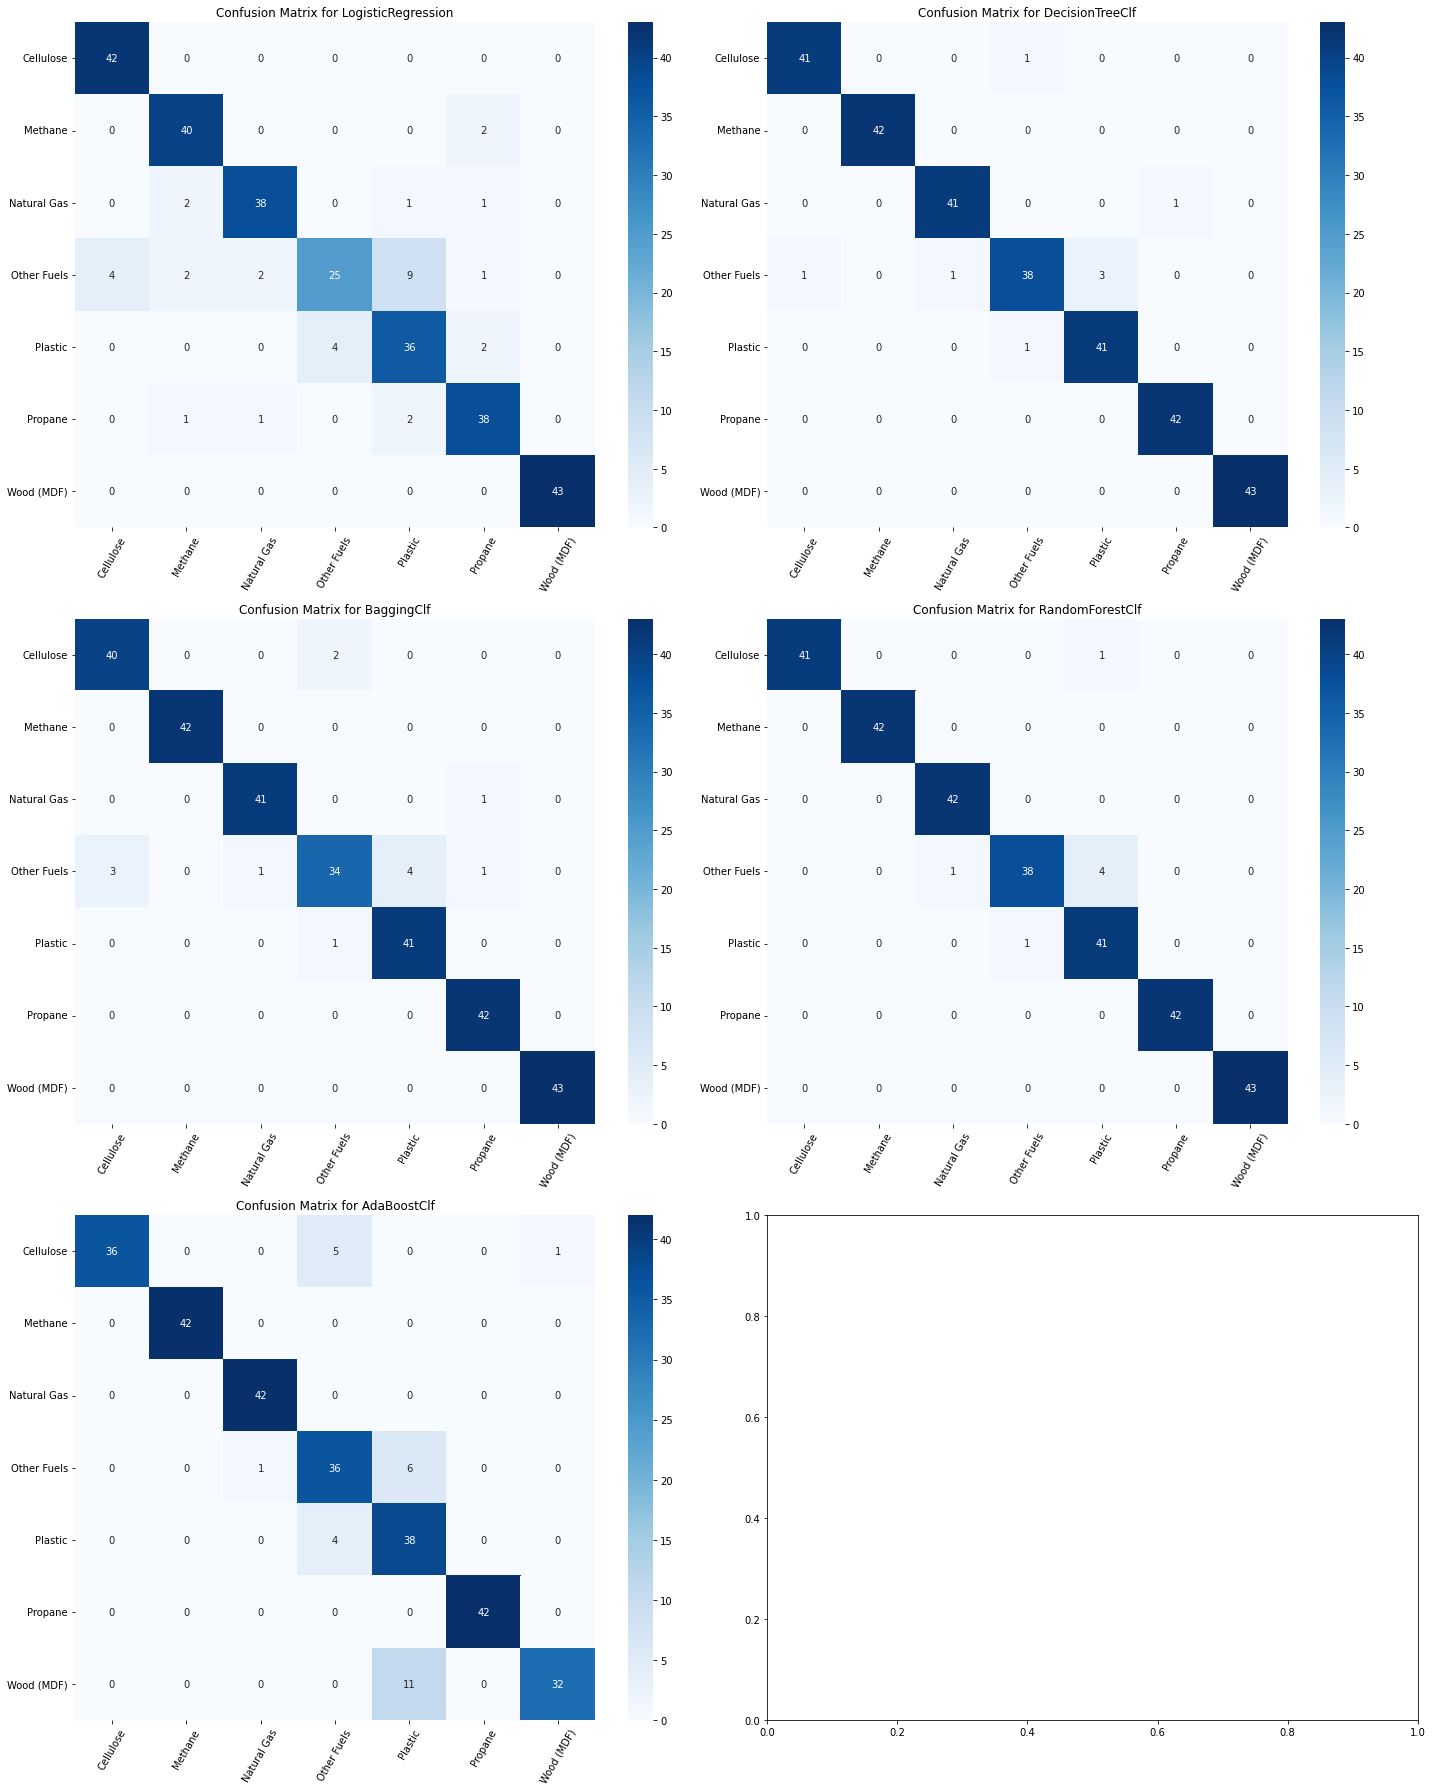

In [220]:
# Comparing test confusion matrix performance of all models

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    sns.heatmap(conmatrix(xtest_imp_aug, ytest_aug, model_objects[i]), annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.xaxis.set_ticklabels(list(le_aug.classes_), rotation=60); 
    ax.yaxis.set_ticklabels(list(le_aug.classes_), rotation=0);
    ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

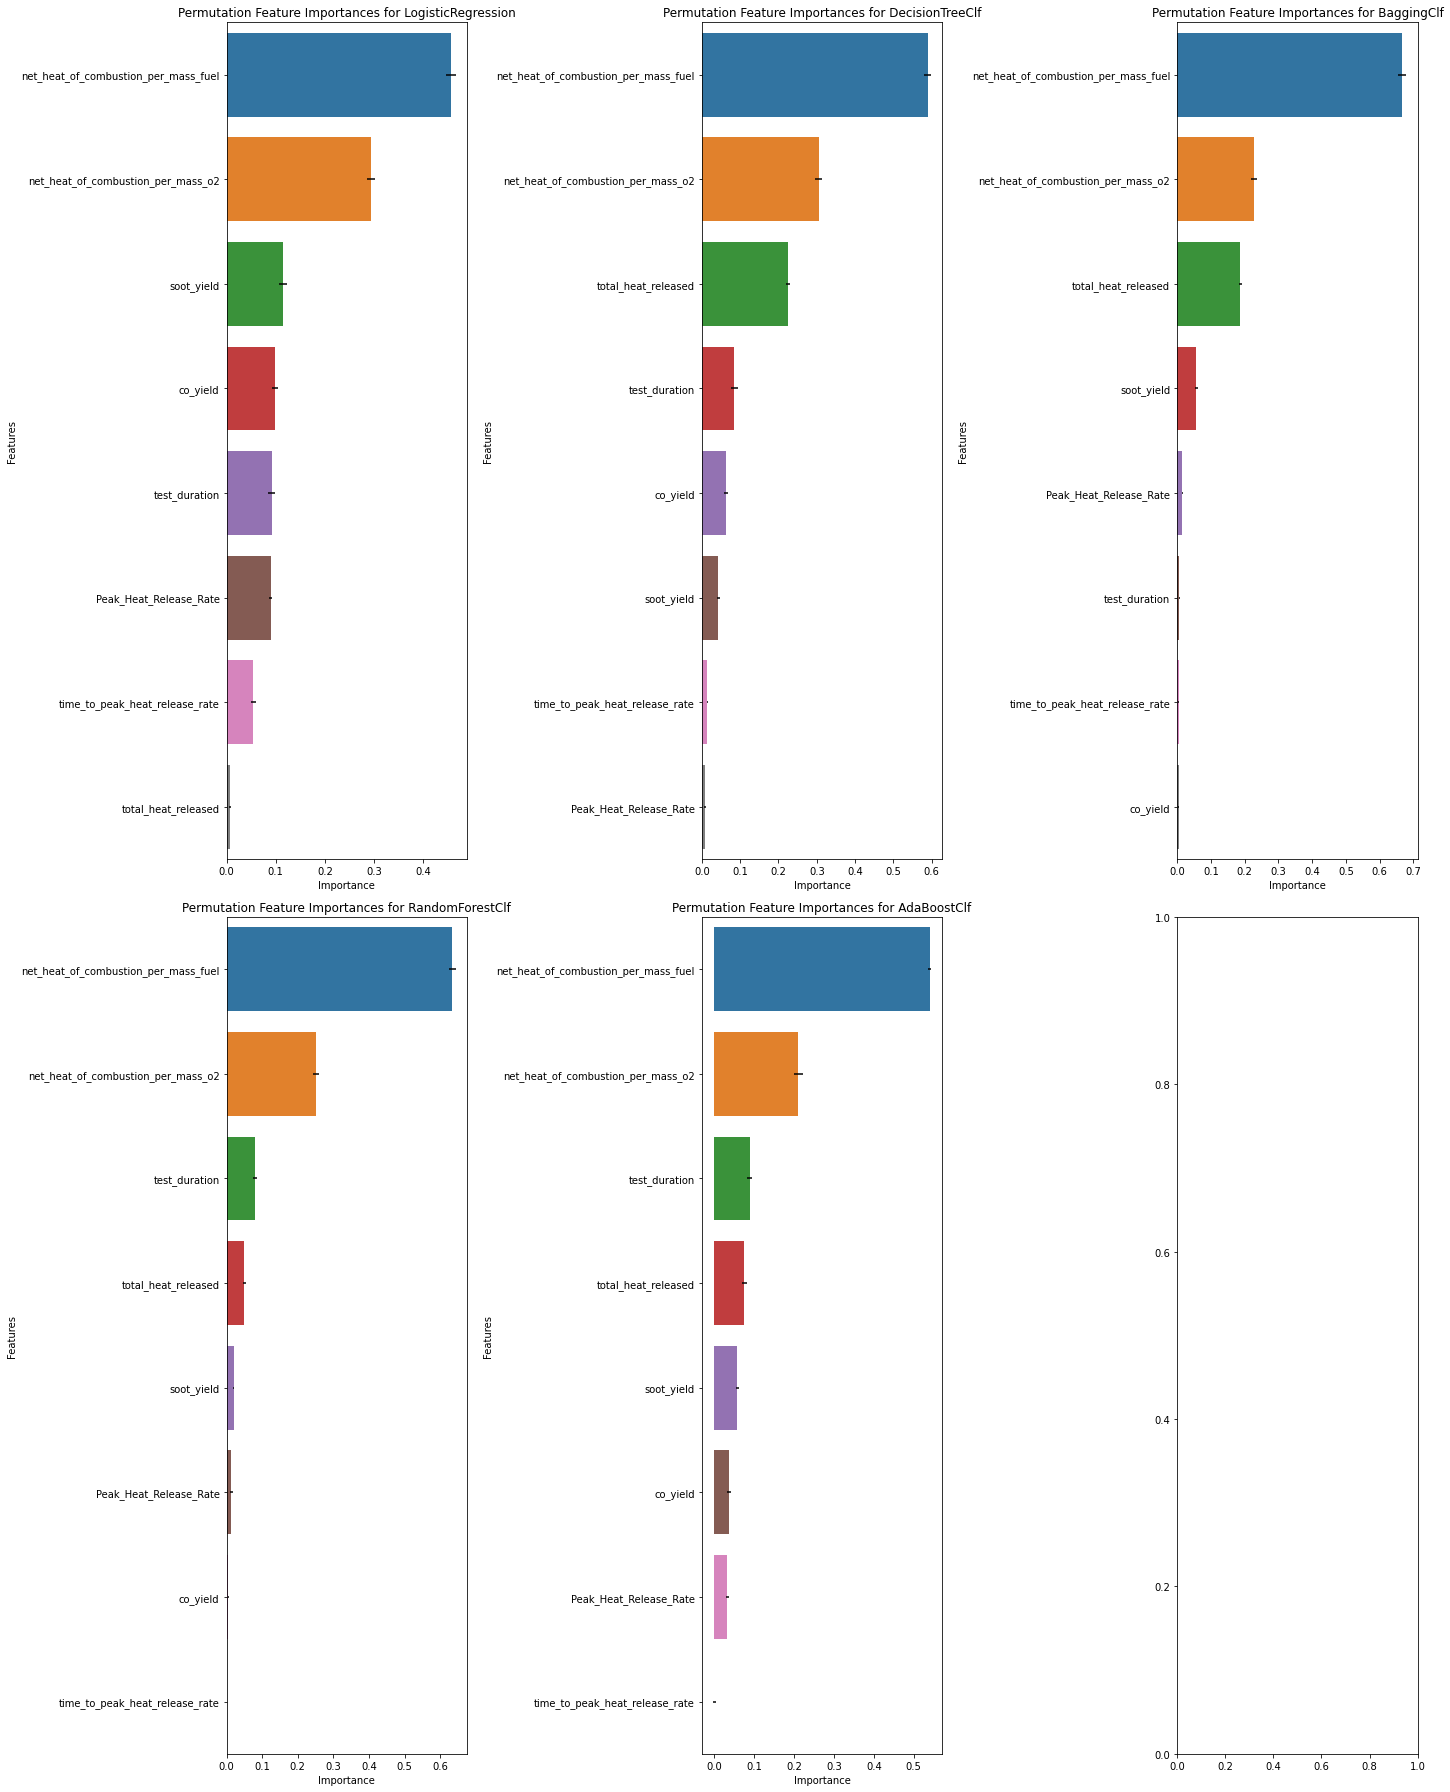

In [221]:
# Comparing feature importance from all models

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 25))
for i, ax in enumerate(axes.flatten()):
  if i<5:
    result = permutation_importance(model_objects[i], xtrain_imp_aug, ytrain_aug, scoring='accuracy', n_repeats=10, random_state=rs)
    idx = np.argsort(result['importances_mean'])[-1::-1]
    sns.barplot(y=xtrain_imp_aug.columns[idx], x=result['importances_mean'][idx], xerr=result['importances_std'][idx], orient='h', ax=ax)
    ax.set_xlabel("Importance"); 
    ax.set_ylabel("Features");
    ax.set_title(f"Permutation Feature Importances for {model_names[i]}", fontdict={'fontsize': 12})
  # if i==0:
  #   plot_confusion_matrix(model_objects[i], X_test_transformed, y_test, ax=ax)
  #   ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
  # else:
  #   plot_confusion_matrix(model_objects[i], X_test, y_test, ax=ax)
  #   ax.set_title(f"Confusion Matrix for {model_names[i]}", fontdict={'fontsize': 12})
# plt.suptitle("Comparison of Test Confusion Matrix Performance of All Models", fontsize=30)
plt.tight_layout()

# Clustering

In [222]:
# Applying TSNE to check if the available features have some predictive power to cluster different 'fuel_type' together
X_embedded = TSNE(n_components=2, perplexity=25, learning_rate='auto', init='pca', random_state=rs, n_jobs=-1).fit_transform(df_train_std)

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


In [223]:
X_embedded.shape

(1183, 2)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


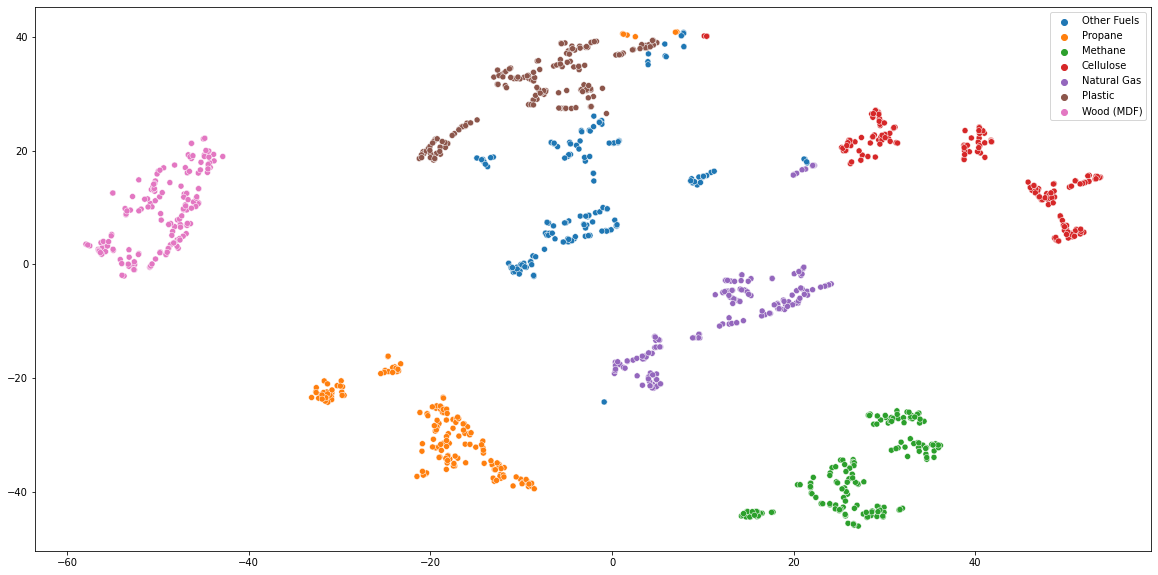

In [224]:
plt.figure(figsize=(20, 10))
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], hue=le.classes_[ytrain_res])

<font color='red'>From the above plot it seems that the available features have good predictive power to cluster different 'fuel_type' together.</font>

# USE CASES and FUTURE WORK

### USE CASES:
- Detection of constituent elements of a product. For example: adulteration of plastics in food products (https://www.thehindu.com/news/national/tamil-nadu/adulteration-provides-food-for-thought/article19096168.ece)
- Detection of arson fires

### FUTURE WORK:
- Segregation of elements in case of compounds. For example: silica, alumina & iron in case of granite
- Exploration of products that are fire-resistant.<br> (1: http://www.tc.faa.gov/its/worldpac/techrpt/ct9546.pdf;<br> 2: https://www.govinfo.gov/content/pkg/GOVPUB-C13-6bce5b94487b654f222c8f166c089bb4/pdf/GOVPUB-C13-6bce5b94487b654f222c8f166c089bb4.pdf)

# Project Flow Summary

So, I begin with the **MOTIVATION**:<br>
Can we identify the object that was burnt? And what are the most important characteristic features that will help in the classification?

1. Created the tabular dataset by extracting relevant data from JSON files hosted on AWS.

2. Performed feature processing, EDA and missing imputation on the original dataset.

3. Dropped highly correlated features to avoid multicollinearity issues and isuues with permutation feature importance.

4. Engineered 2 features **HOCf**(net heat of combustion / fuel mass) and **Ef** (net heat of combustion / o2 mass)

5. As the dataset is small, ~1000 observations, grouped 30 different fuel types whose value_counts were <10% of majority class under a new category **'Other Fuels'** to avoid dropping of samples.

6. Label Encoded different fuel types.

7. Performed stratified train-test split.

8. Standardized the data.

9. Next, we handled Class Imbalance in 2 ways.
  - **a) Method 1: Up-sampled minority class using SMOTE.**
    - i) Used Performance Metric from Logistic Regression as baseline.
	  - ii) Used different Tree based models to improve upon the baseline metrics.
	  - iii) Performed Hyperparameters optimization on all the models.
	  - iv) Random Forest was the best model and improved the baseline Test Accuracy by 9%.

  - **b) Method 2: Augmented the Original Data using Feature Measurement Uncertainty Values. And up-sampled the minority classes using samples from Augmented Data.**
	  - i) Again used LR as baseline and different Tree models to improve the performance.
	  - ii) Again Random Forest was the best model and improved the baseline Test Accuracy by 10%.

10. Model Interpretation using Permutation Importance and Shapley Values yielded that HOCf and Ef, which were the engineered fetures, are the most important features in classification of fuels.

11. From the Confusion Matrix we can observe that the most misclassifications occured for **'Other Fuels'** class as it is an umbrella category for 30 different fuel types some of whose characteristics matches with some of the major fuel types.

12. Probable use cases of this classification:
  - a) Detection of adulteration in products. Ex: adulteration of plastics in food products.
  - b) Detection of arson fires for denial/settlement of fire insurance claims.

13. Future Work:
  - a) How can we segregate elements in case of compounds? Maybe by incorporating spectrograms.
  - b) Formulation of products that are fire-resistant.
  - c) Using sequence models and time-series data to predict fire hazards.

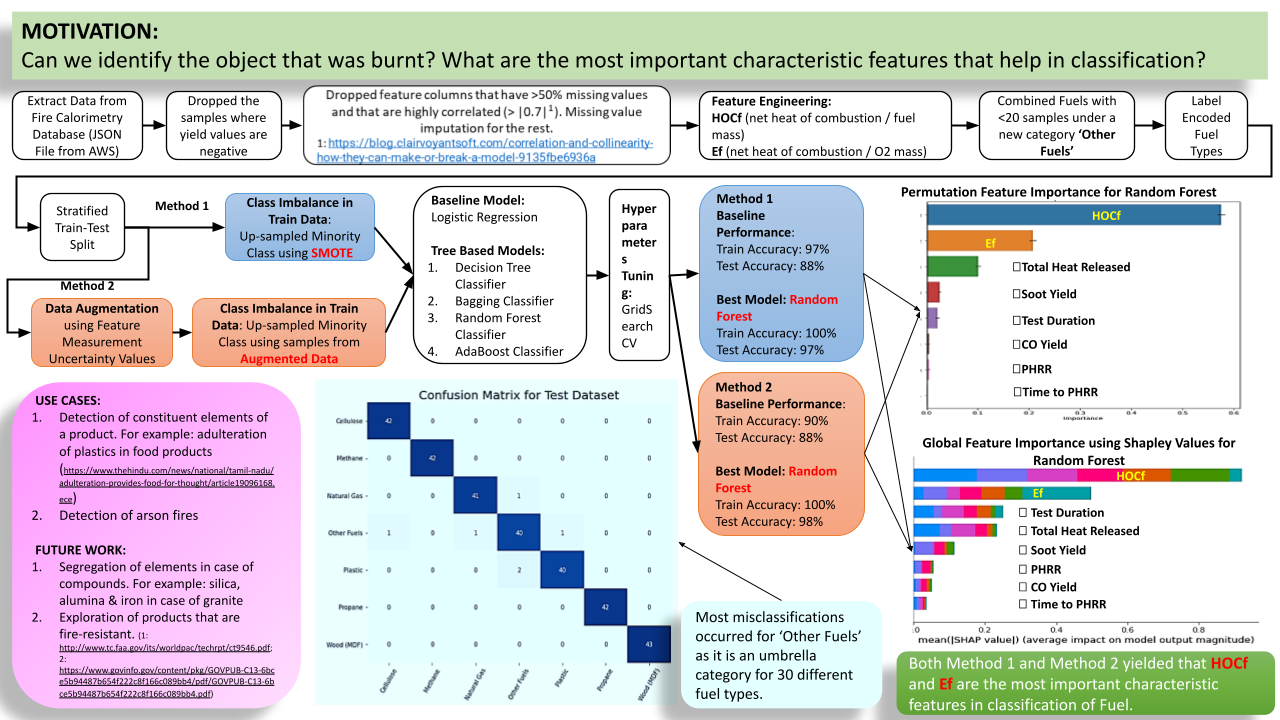